In [1]:
##analysis of game theoretical networks by focusing on individual node influence
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
#ABOVE added to use development version of cana
from __future__ import division
import os
import math
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
import graphviz
import cana
from cana.drawing import draw_canalizing_map_graphviz
from cana.drawing import draw_dynamics_canalization_map_graphviz
import matplotlib as mpl
import matplotlib.style
#mpl.style.use('classic')
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
import random
from copy import copy
mpl.rc('font', **{'size':16})
import matplotlib.pyplot as plt
from cana.datasets.bio import THALIANA, DROSOPHILA, BUDDING_YEAST, LEUKEMIA, BREAST_CANCER
from itertools import combinations
from IPython.display import display, Image, Latex, SVG, HTML
import subprocess
#
import json
import ast
#BELOW added for graphviz to work on windows
#os.environ["PATH"] += os.pathsep + "C:/Anaconda/pkgs/graphviz-2.38.0-4/Library/bin/"
#os.environ["PATH"] += os.pathsep + 'C:/Anaconda/Library/bin/graphviz/'
os.environ["PATH"] += os.pathsep + 'C:\Users\tjparmer\Miniconda2\Lib\site-packages\graphviz'
import networkx as nx
from cana.utils import statenum_to_binstate, binstate_to_statenum
from networkx_addon import information_propagation as ip
import time

#### Functions

In [3]:
#generate look-up table based on theta (if there at least as many 1's as theta, output is 1)
#shortcut for strategies where response is based on a threshold
node=24
theta=0.5

def output_transitions_LT(n,node,theta):
    """ Given a networkx graph n and node, generate a LUT for node based on theta threshold """
    total=2**len(n[node]) #total combinations to try
    output_list=[]
    for i in range(total):
        trial_string = statenum_to_binstate(i,len(n[node])) #from utils.py in cana
        #print trial_string
        #simply count the 1's to determine if the threshold is met
        if trial_string.count('1')/len(trial_string) >= theta: 
            output_list.append(1)
        else:
            output_list.append(0)
    return output_list
        
#print output_transitions_LT(N,node,theta)

In [4]:
#generate look-up table randomly based on p
import random
node=24
p=0.5

def output_transitions_rnd(n,node,p):
    """ Given a networkx graph n and node, generate a LUT for node with random outputs biased by p """
    total=2**len(n[node]) #total combinations to try
    output_list=[]
    for i in range(total):
        trial_string = statenum_to_binstate(i,len(n[node])) #from utils.py in cana
        #print trial_string
        #random selection
        if random.random() < p:
            output_list.append(0)
        else:
            output_list.append(1)
    return output_list
        
#print output_transitions_rnd(N,node,p)

In [5]:
#generate output transitions given a payoff matrix and a player's strategy
#NOTE: state 0 is defection, state 1 is cooperation
def output_transitions_GT(n,node,payoff,strategy="br"):
        """ Given a networkx graph n and node, generate a LUT for node based on a payoff matrix and strategy,
        by default the strategy is 'br' for best response; 
        payoff matrices should be in the form of payoff value per state: 00,01,10,11 for two players """
        total=2**len(n[node]) #total combinations to try
        output_list=[]
        for i in range(total):
            trial_string = statenum_to_binstate(i,len(n[node])) #from utils.py in cana
            #print trial_string
            #check the payoff matrix if either strategy was played
            payoff0=trial_string.count('0')*payoff[0] + trial_string.count('1')*payoff[1] #node defects
            payoff1=trial_string.count('0')*payoff[2] + trial_string.count('1')*payoff[3] #node cooperates
            if strategy=='br':
                if payoff1>=payoff0: #cooperation chosen in tie scenario
                    action=1
                else:
                    action=0
            elif strategy=='tft': #tit-for-tat, choose majority response of your neighbors
                if trial_string.count('1')>=trial_string.count('0'):
                    action=1
                else:
                    action=0
            #print action       
            output_list.append(action)
        return output_list
        
payoffs=[0.1,1.5,0,1.0]
#print output_transitions_GT(N,node,payoffs,strategy='tft')

In [6]:
#determine the inputs of a BooleanNode, graph, or digraph by checking the structural graph
from cana.boolean_node import BooleanNode
def predecessors(node,N):
    """ takes a BooleanNode and networkx (di)graph as inputs """
    if isinstance(node,BooleanNode):
        node=node.name
    if isinstance(N,nx.DiGraph):
        return N.predecessors(node)
    return N[node] #otherwise it's all of our neighbors

#node=NK.nodes[0]
#ND=nx.DiGraph(N)
#predecessors(node,ND)

In [7]:
#create BooleanNetwork object by converting all output transitions relative to theta, requires logic dictionary
#NOTE: BooleanNetworks must be 0-based
#from collections import defaultdict
#G = nx.Graph([('a','b'),('b','c')]) #does not work unless nodes 'a', 'b' given integer names
def convert_GT(N,payoff,strategy='br',subtract=False):
    """ takes a network and global threshold value (theta) and generates a BooleanNetwork object with LUTs based on theta """
    
    #logic = {i:{} for i in range(len(N.nodes()))}
    logic = {i:{} for i in N.nodes()}
    
    for node in N:
        if subtract: i=int(node)-1
        else: i=int(node)
        logic[i] = {'name': node, 'in':[], 'out':[]} 
        if subtract:
            logic[i]['in']=[int(key)-1 for key in predecessors(node,N)] #assumes nodes with integer names!, must decrease by 1 to make 0-based
        else:
            logic[i]['in']=[int(key) for key in predecessors(node,N)]
        logic[i]['out']=output_transitions_GT(N,node,payoff,strategy)
        #print node,N.degree([node]),len(logic[i]['out']),logic[i]['in']

    #N = cana.BooleanNetwork(name='', logic=logic, Nnodes=len(N), constants={}, keep_constants=True)
    return cana.BooleanNetwork.from_dict(logic)

payoffs=[0.1,1.5,0,1.0]
#NK = convert_GT(N,payoffs,strategy='tft')
#print NK

In [8]:
#create BooleanNetwork object by converting all output transitions randomly
#NOTE: BooleanNetworks must be 0-based
#G = nx.Graph([('a','b'),('b','c')]) #does not work unless nodes 'a', 'b' given integer names
def convert_rnd(N,p=0.5,subtract=False):
    """ takes a network and global activation probability (p) and generates a BooleanNetwork object with LUTs based on p """
    
    #logic = {i:{} for i in range(len(N.nodes()))}
    logic = {i:{} for i in N.nodes()}
    
    for node in N:
        if subtract: i=int(node)-1
        else: i=int(node)
        logic[i] = {'name': node, 'in':[], 'out':[]} 
        if subtract:
            logic[i]['in']=[int(key)-1 for key in predecessors(node,N)] #assumes nodes with integer names!, must decrease by 1 to make 0-based
        else:
            logic[i]['in']=[int(key) for key in predecessors(node,N)]
        logic[i]['out']=output_transitions_rnd(N,node,p)
        #print node,N.degree([node]),len(logic[i]['out']),logic[i]['in'],sum(logic[i]['out'])/len(logic[i]['out'])

    #N = cana.BooleanNetwork(name='', logic=logic, Nnodes=len(N), constants={}, keep_constants=True)
    return cana.BooleanNetwork.from_dict(logic)

p=0.5
#NKB = convert_rnd(NB,p)
#print NKB

In [5]:
#alternate version of CANA LUT table function that fixes bug, takes a BooleanNode
#NOTE: this first tries to read the look-up-table from an existing data structure, otherwise it calculates it
def look_up_table(node,ds={}):
    if ds:
        return ds[node.name]
    
    d = []
    for statenum, output in zip( xrange(2**node.k), node.outputs):
        # Binary State, Transition
        d.append( (statenum_to_binstate(statenum, base=node.k), output) )
    df = pd.DataFrame(d, columns=['In:','Out:'])
    return df

#look_up_table(NK.nodes[0])

In [10]:
import random
#threshold network conversion
def create_threshold_network(n):
    """ Create a digraph compatible with threshold network manipulation
    Expects a DCM-like digraph as input, returns a threshold-like digraph where every node is a literal and/or threshold node
    
    Valid nodes include these properties: label, threshold (tau), type, time delay, variable, state
    Valid edges include these properties: type 
    
    NOTE: the DCM originally has a separate fusion node for each literal enput of the same state involved in the same symmetry group
    However, this means that the same enput can activate multiple edges rather than just one
    As a solution, each group of fusion nodes that are associated with the same state and the same symmetry group are replaced
    by one threshold node with tau=n, where n is the number of fusion nodes that were combined into that threshold node """
    
    n=n.copy() #don't change the original graph
    
    #check for similar fusion nodes
    fusion_nodes=[name for name in n.nodes() if n.node[name]['type']=='fusion']
    groups={} #each group will share the same predecessors and successors
    i=0
    for f in fusion_nodes:
        predecessors=set(n.predecessors(f))
        successors=set(n[f])
        found=False
        for key in groups:
            if groups[key]['predecessors']==predecessors and groups[key]['successors']==successors: #we have a match
                groups[key]['nodes'].append(f)
                found=True
                break
        if not found: #make a new group
            groups[i]={'predecessors':predecessors, 'successors':successors, 'nodes':[f]}
            i+=1
    #delete fusion nodes and replace with new threshold nodes
    for t in groups: #add new threshold nodes
        name="F-T"+str(t)
        tau=len(groups[t]['nodes'])
        group=n.node[random.choice(tuple(groups[t]['successors']))]['group'] #take group attribute of random successor, necessary for visualization
        n.add_node(name,{'label':str(tau),'type':'threshold','tau':tau,'group':group})
        #adjust successor node thresholds; add 1 for new threshold node and then substract for each fusion node deleted
        for successor in groups[t]['successors']: #there should only be one
            n.add_edge(name,successor)
            n.node[successor]['tau'] += 1 - tau
            n.node[successor]['label'] = str(n.node[successor]['tau'])
        #add new edges to threshold nodes from predecessors
        for predecessor in groups[t]['predecessors']:
            n.add_edge(predecessor,name)
        
    #delete fusion nodes and adjacent edges
    for f in fusion_nodes:
        n.remove_node(f)
    #print groups
    
    for name in n.nodes():
        
        if 'label' not in n.node[name]:
            n.node[name]['label']='unknown'
            
        if 'type' not in n.node[name]:
            n.node[name]['type']='unknown'
            
        if 'tau' not in n.node[name]:
            if n.node[name]['type']=='threshold':
                n.node[name]['tau']=1
            else:
                n.node[name]['tau']=0
                
        if 'delay' not in n.node[name]:
            if n.node[name]['type']=='threshold':
                n.node[name]['delay']=0
            else:
                n.node[name]['delay']=1
        
        #assume variable name comes from the label
        if 'variable' not in n.node[name] and n.node[name]['type']=='variable':
            n.node[name]['variable']=n.node[name]['label']
            
        #assume states are only positive integers
        if 'state' not in n.node[name] and n.node[name]['type']=='variable':
            state_str=name.replace(n.node[name]['variable'],"") #remove variable name
            state_str=''.join([s for s in state_str if s.isdigit()]) #concatenate string from all integers left in name (in case of double-digit states)
            n.node[name]['state']=int(state_str)
                
        #print name,n.node[name]
        
    return n

#create_threshold_network(DCM)

In [11]:
from collections import deque
#specialized BFS to work for threshold network
def BFS_threshold(n,seed,input_type='steady',time_limit=1,conversion=True,pinned=set([])):
    
    """ Does specialized BFS on a threshold network n
    input_type may be 'pulse' if a single signal is sent through the network (seed guaranteed ON/OFF for only one time step)
    or 'steady' if the signal is held on (seed guaranteed ON/OFF for all time steps) 
    seed may be a single node or a list of starting nodes
    
    Implementation based on BFS with a priority queue of times {t: q} 
    where t is the time when those nodes become active and q are the nodes active at that time step 
    
    Returns a dictionary of nodes visited at each time step
    
    NOTE: a threshold network is required, this will break if fusion nodes have not been removed
    Assume that a conversion is needed; will not run conversion if conversion argument set to False 
    
    NOTE: if run with input_type='steady', unfolding contains only the new states visited at that time step
    while all previous states visited are also considered active
    if run with input_type='pulse', unfolding contains EVERY node that is active at that time step, 
    even if it has been active before
    the pinned argument is used to specify nodes that are pinned in one state, regardless of the input_type,
    and can specify a subset of the seed that's constitutively active when input_type='pulse'
    
    NOTE: if run with input_type='steady', then ignore any node that is a different state of the starting seed;
    because we are pinning control of that variable, we need to remove all other possible variable states from the network """
    
    if conversion: #note conversion is slow due to a network deep copy
        try:
            n=create_threshold_network(n)
        except:
            raise Exception("Network could not be converted to a thresholded representation")
        
    if not isinstance(seed,list): #convert seed to a list if it is a single node
        seed=[seed]
    
    for node in seed:
        if node not in n.nodes():
            raise Exception('Seed not in the network!  Hint: did you specify both the node and current state? e.g. wg-1')
            
    #if there is steady-state input (pinning control), note any contradictions to any node in the seed
    #NOTE: if given a logical contradiction, this function picks only ONE of the states to use
    #however, this doesn't affect steady-state (because the variable was already added to the queue and active step)
    if input_type=='steady':
        vals={n.node[x]['variable']:n.node[x]['state'] for x in seed if n.node[x]['type']=='variable'}
        contradictory_nodes={node for node in n if 
                        n.node[node]['type']=='variable' and n.node[node]['variable'] in vals and n.node[node]['state']!=vals[n.node[node]['variable']]}
    else:
        contradictory_nodes=set([])
    if pinned: #check pinned nodes as well
        vals={n.node[x]['variable']:n.node[x]['state'] for x in pinned if n.node[x]['type']=='variable'}
        contradictory_nodes.update({node for node in n if 
                        n.node[node]['type']=='variable' and n.node[node]['variable'] in vals and n.node[node]['state']!=vals[n.node[node]['variable']]})
        
    counter=0  #this will increment towards the time limit and provide an exit if we get stuck
    visited=set() #visited nodes during the entire history
    thresholds={} #global threshold dictionary to populate with discounted threshold nodes
        
    #create 'priority queue', actually a dictionary of time steps due to difficulty in changing priorities in a heap
    time_steps={0: deque(seed)} #FIFO queue for each time step of nodes to attempt to visit
    time=0 #global chronometer, iterates by one as dynamic unfolding takes place
    unfolding={} #track the unfolding of the dynamics over iterated time, mirrors time_steps but only holds visited nodes    
    active_step=set(seed) #active nodes for this time step, will be different than visited if input_type='pulse'
    for node in pinned:
        time_steps[0].append(node)
        active_step.add(node)
    
    
    while time<=max(time_steps): #allows for possibility of time jumps, i.e. updates further ahead than one time step
        
        #update counter
        old_length=len(visited)
        visited.update(active_step)
        #if len(visited)==old_length: #increase counter if we have not added anything new
        #if any(unfolding[t] == active_step for t in unfolding): #increase counter if we repeat a past partial configuration
        counter+=1
        #print time,len(visited)
        #reset thresholds and active_step if this is pulse (so that we may revisit nodes, including the starting nodes)
        #print time,active_step
        if input_type=='pulse':
            thresholds={}
            active_step=set()
            #add in pinned nodes first
            for node in pinned:
                time_steps.setdefault(time+1,deque())
                time_steps[time+1].append(node)
                active_step.add(node)
        
        #check for exit due to being stuck in a cycle
        if counter>=time_limit: 
            break
            

        #run BFS
        while time_steps.get(time): 
            node=time_steps[time].popleft()
            #add node to unfolding
            unfolding.setdefault(time,set())
            unfolding[time].add(node)
            
            #check neighbors - note that for steady state we assume all past actors are still activated, but pulse requires repeat activation
            for neighbor in n[node]:
                #ignore any contradictory nodes; better to ignore than remove because we don't want BFS to be destructive to the graph
                if neighbor in contradictory_nodes:
                    continue
                if neighbor not in active_step:
                    #check that neighbor passes the threshold test if it has a non-trivial threshold
                    if n.node[neighbor]['tau']>1:
                        thresholds.setdefault(neighbor,set())
                        thresholds[neighbor].add(node)  #add node due to this incoming edge, ensures node can only contribute once
                    if neighbor not in thresholds or len(thresholds[neighbor])>=n.node[neighbor]['tau']:
                        #at this point we have passed the threshold, so insert neighbor at proper time slot t
                        t = time + n.node[neighbor]['delay']
                        time_steps.setdefault(t,deque())
                        time_steps[t].append(neighbor)
                        active_step.add(neighbor)
                           
        #next iteration
        time+=1
    
    return unfolding

#DCM=ND.dynamics_canalization_map(output=None, )
#print BFS_threshold(DCM,['en-1','ptc-1'],'pulse',time_limit=12,pinned={'en-1'}) #'SLP-1','CIR-0','CIA-1', 'SLP-0','nWG-1'

In [12]:
#determine the outgoing transitions of a BooleanNode by checking the structural graph
from cana.boolean_node import BooleanNode
def neighbors(node,N):
    """ takes a BooleanNode and networkx (di)graph as inputs """
    if isinstance(node,BooleanNode):
        node=node.name
    return N[node]

#node=NK.nodes[0]
#ND=nx.DiGraph(N)
#neighbors(node,ND)

In [13]:
#function to evaluate an output transition; NOTE: inputs and outputs are strings
def output_transition(node,inputs,method='literal',act_theta=0.5):
    """ determine which, if any, output transition can occur; depends on the method;
    by default, the method is 'literal' (all input states need to be known)
    other methods include 'threshold', where input activation above theta triggers an output of 1 """
    
    inputs=''.join([ip if ip else '#' for ip in inputs])
    #print node.inputs,inputs
    output=False
    if method=='literal': #all inputs must be present
        if len([ip for ip in inputs if ip!='#'])==len(node.inputs): #we have enough information to update the state
            output=str(node.outputs[binstate_to_statenum(inputs)])
    elif method=='threshold': #checks to see if simple threshold is met
        if inputs.count('1')/float(len(inputs))>=act_theta:
            output='1'
        elif inputs.count('0')/float(len(inputs))>(1-act_theta):
            output='0'
    
    return output

In [14]:
#general BFS to work with a discrete dynamical system on a network; expects a BooleanNetwork object
#in contrast to a DCM, the given network has variable nodes and not s-units
#NOTE: all variable names are strings; the original interaction graph N is needed for easy traversal
#NOTE: the original graph N assumes integer variable names unless names='string'
def BFS_general(n,seed,N,input_type='steady',time_limit=1,pinned=set([]),method='literal',
                act_theta=0.5,names='int'):
    
    if not isinstance(seed,list): #convert seed to a list if it is a single node
        seed=[seed]
        
    #construct s-units from variable nodes, NOTE: assumes binary for now
    nodes={str(node.name)+'-0' for node in n.nodes}
    nodes=nodes.union({str(node.name)+'-1' for node in n.nodes})
    node_map={str(node.name):node for node in n.nodes} #assumes nodes have unique names
    
    for node in seed:
        if node not in nodes:
            raise Exception('Seed '+str(node)+' not in the network!  Hint: did you specify both the node and current state? e.g. wg-1')
            
    #create the initial state of the network
    nt_state={str(node.name): False for node in n.nodes}
    for node in seed:
        nt_state[node[:-2]]=node[-1] #assumes less than 10 states; otherwise string length will get messed up!
    for node in pinned: nt_state[node[:-2]]=node[-1]
    update_state={} #hold all updates for this time step
    #print len(nodes),nt_state
            
    #if there is steady-state input (pinning control), note any contradictions to any node in the seed
    #NOTE: if given a logical contradiction, this function picks only ONE of the states to use
    #however, this doesn't affect steady-state (because the variable was already added to the queue and active step)
    if input_type=='steady':
        #vals={n.node[x]['variable']:n.node[x]['state'] for x in seed if n.node[x]['type']=='variable'}
        constants={node[:-2] for node in seed}
    elif pinned: #check pinned nodes as well
        #vals={n.node[x]['variable']:n.node[x]['state'] for x in pinned if n.node[x]['type']=='variable'}
        constants={node[:-2] for node in pinned} 
    else: constants={}
    contradictory_nodes={node for node in nodes if node[:-2] in constants and 
                        nt_state[node[:-2]] and node[-1]!=nt_state[node[:-2]]}
    #print contradictory_nodes   
    counter=0  #this will increment towards the time limit and provide an exit if we get stuck
    visited=set() #visited nodes during the entire history
    #thresholds={} #global threshold dictionary to populate with discounted threshold nodes
        
    #create 'priority queue', actually a dictionary of time steps due to difficulty in changing priorities in a heap
    time_steps={0: deque(seed)} #FIFO queue for each time step of nodes to attempt to visit
    time=0 #global chronometer, iterates by one as dynamic unfolding takes place
    unfolding={} #track the unfolding of the dynamics over iterated time, mirrors time_steps but only holds visited nodes    
    active_step={node[:-2] for node in seed} #active nodes for this time step, will be different than visited if input_type='pulse'
    for node in pinned:
        time_steps[0].append(node)
        active_step.add(node[:-2])
    
    
    while time<=max(time_steps): #allows for possibility of time jumps, i.e. updates further ahead than one time step
        
        #update counter
        old_length=len(visited)
        visited.update(active_step)
        #if len(visited)==old_length: #increase counter if we have not added anything new
        #if any(unfolding[t] == active_step for t in unfolding): #increase counter if we repeat a past partial configuration
        counter+=1
        #print time,len(visited)
        #reset thresholds and active_step if this is pulse (so that we may revisit nodes, including the starting nodes)
        #print time,active_step
        if input_type=='pulse':
            #thresholds={}
            active_step=set()
            #add in pinned nodes first
            for node in pinned:
                time_steps.setdefault(time+1,deque())
                time_steps[time+1].append(node)
                active_step.add(node[:-2])
        
        #check for exit due to being stuck in a cycle
        if counter>=time_limit: 
            break

        #print {key:nt_state[key] for key in nt_state if nt_state[key]}
        #run BFS
        while time_steps.get(time): 
            node=time_steps[time].popleft()
            #add node to unfolding
            unfolding.setdefault(time,set())
            unfolding[time].add(node) #adding s-unit
            #print node
            
            #check neighbors - note that for steady state we assume all past actors are still activated, but pulse requires repeat activation
            if names=='string': var=node[:-2]
            else: var=int(node[:-2])
            for neighbor in neighbors(var,N): #NOTE: assumes that original nodes are integers
                neighbor=str(neighbor)
                if neighbor not in active_step:
                    #check that neighbor is able to update
                    inputs=[nt_state[str(ip)] for ip in node_map[neighbor].inputs] #if nt_state[str(ip)]]
                    output=output_transition(node_map[neighbor],inputs,method=method,act_theta=act_theta)
                    #print neighbor,node_map[neighbor].inputs,''.join([ip if ip else '#' for ip in inputs]),output
                    if output: #we have enough information to update the state
                        #at this point we have passed the update rule, so insert neighbor at proper time slot t
                        t = time + 1 #n.node[neighbor]['delay']
                        output=neighbor+'-'+output
                        #ignore any contradictory nodes; better to ignore than remove because we don't want BFS to be destructive to the graph
                        if output in contradictory_nodes:
                            continue
                        time_steps.setdefault(t,deque())
                        time_steps[t].append(output)
                        active_step.add(output[:-2])
                        update_state[output[:-2]]=output[-1]
        
        #next iteration
        if input_type=='pulse':
            nt_state={str(node.name): False for node in n.nodes} #reset all states except those that are pinned 
            for node in pinned: nt_state[node[:-2]]=node[-1]
        #add updates from this round
        for key in update_state: nt_state[key]=update_state[key]
        update_state={} #hold all updates for the next time step
        time+=1
    
    return unfolding

#print BFS_general(NK,['0-1','2-1','52-1','63-1'],N,'steady',time_limit=7,pinned={},method='threshold',act_theta=0.5) #'6-0', '52-1'
#print BFS_general(NKB,['0-1'],NB,'steady',time_limit=102,pinned={},method='threshold',act_theta=0.5)
#BFS_general(NKB,['10-1'],NB,'steady',time_limit=120,pinned={},method='threshold',act_theta=theta)

In [15]:
#run a random full-network configuration based on a single seed of one or more specified nodes
def run_simulation(NB,seed,N,input_type='pulse',time_limit=1,pinned={},method='literal',act_theta=0.5,unknown_prob=0.5,
                   runs=100,iterations=10,nodes={}):
    """ run various simulations of a single seed, while assuming other nodes have unknown_prob chance of activation 
    returns the generated simulations; NOTE: this depends on BFS_threshold
    iterations refers to the number of iterations past the initial configuration at t=0 (iterations+1 total) 
    NOTE: seed must be a list of s-units """

    iterations=iterations+1 #include 0
    #time_limit=iterations+1 #can modify later
    if not nodes:
        nodes={str(node.name) for node in NB.nodes}
    act_prob_sim = {i:{node: 0.0 for node in nodes} for i in range(iterations)}
    simulations={}
    if input_type=='pulse' and time_limit<iterations+1:
        print "Time limit must be greater than the number of iterations by at least 2"
        return

    #get the ground truth for the seed based on several runs
    for i in range(runs):
        #initiate a random condition
        alt_seed=[sunit for sunit in seed]
        for node in nodes-{sunit[:-2] for sunit in alt_seed}:
            if random.random()<unknown_prob:
                alt_seed.append(node+'-1')
            else:
                alt_seed.append(node+'-0')
        #print alt_seed
        
        #find the information diffusion for the sample based on the BFS general algorithm
        simulations[str(alt_seed)]={i:{node: 0 for node in nodes} for i in range(iterations)} #to calculate a baseline
        diffusion=BFS_general(NB,alt_seed,N,input_type,time_limit,pinned,method,act_theta) #pin seed for steady-state modules
        nodes_reached=set([])
        #print diffusion

        for index in range(iterations):
            if input_type=='steady-state':
                if index < len(diffusion): #otherwise, nodes_reached is already at maximum
                    nodes_reached={node for node in diffusion[index]}
                for node in nodes_reached:
                    if node[-1]=='1': #only record activation probability (as inactivation is the converse of this)
                        act_prob_sim[index][node[:-2]]+=1
                        simulations[str(alt_seed)][index][node[:-2]]=1
            elif input_type=='pulse': #all states *should be in diffusion; time_limit must be > iterations
                for node in act_prob_sim[index]:
                    if node+'-1' in diffusion[index]:
                        act_prob_sim[index][node]+=1
                        simulations[str(alt_seed)][index][node]=1
                    elif node+'-0' in diffusion[index]: #0 is the default state so no need to set it
                        pass
                    else: #this applies to isolated nodes, for example; take last known state by default
                        act_prob_sim[index][node]+=simulations[str(alt_seed)][index-1][node]
                        simulations[str(alt_seed)][index][node]=simulations[str(alt_seed)][index-1][node]
        #print act_prob_sim[index][:-2]
            
    #find average (our label)
    act_prob_sim={index:{node:act_prob_sim[index][node]/runs for node in act_prob_sim[index]} for index in range(iterations)}
    #print seed,act_prob_sim[iterations-1]
    
    return act_prob_sim,simulations

#seed=['52-1','6-0']
#act_prob_sim,simulations=run_simulation(NK,seed,N,'pulse',time_limit=12,pinned={s for s in seed},method='threshold',act_theta=0.5,runs=100)
#print act_prob_sim[10]
#iterations=15
#run_simulation(NK,alt_seed,N,'pulse',time_limit=iterations+2,pinned={},method='threshold',act_theta=0.5,runs=10,iterations=iterations)[0]

In [16]:
#run random full-network configurations
def run_simulations(NB,seeds,N,sunit_map,translator,input_type='pulse',pinned={},method='literal',length=None,runs=100,
                    act_theta=0.5,iterations=10,unknown_prob=0.5,nodes={},stats={},results=True,act_prob_sim={},simulations={}):
    """ run various simulations of the seeds, while assuming other nodes have unknown_prob chance of activation 
    prints out metrics and returns the generated simulations 
    iterations refers to the number of iterations past the initial configuration at t=0 (iterations+1 total)
    NOTE: this depends on BFS_threshold 
    NOTE: pinned may either be 'seeds' or a set of s-units """
    
    if not nodes:
        nodes={str(node.name) for node in NB.nodes}
    total=0
    
    for seed in seeds:
        sunits=to_list(seed,sunit_map,translator)
        #print seed,sunits
        if length and len(sunits)!=length:
            continue
        if len({sunit[:-2] for sunit in sunits})!=len(sunits): #there is a contradiction
            continue
        total+=1
        if pinned=='seeds': #pin each seed
            pset={s for s in sunits}
        else: pset={s for s in pinned}
        act_prob_sim[str(seed)],simulations[str(seed)]=run_simulation(NB,sunits,N,input_type=input_type,time_limit=iterations+2,
            pinned=pset,method=method,act_theta=act_theta,unknown_prob=unknown_prob,runs=runs,iterations=iterations,nodes=nodes)
        #sunits=to_list(str(seed),dsunit_map,dtranslator)
        #act_prob_sim[str(seed)] = {i:{node: 0.0 for node in nodes} for i in range(iterations)}
        #simulations[str(seed)]={}
    if results:
        print 'total seeds:',total
    return act_prob_sim,simulations

#seeds=[[105],[12]] #[['52-1'],['6-0']]
#act_prob_sim,simulations=run_simulations(NK,seeds,N,ksunit_map,ktranslator,length=1,runs=1,act_theta=0.5,iterations=10,
#                                         unknown_prob=0.5,stats={},results=True,input_type='pulse',pinned={'0-0','2-1'},method='threshold')
#act_prob_sim.keys()

In [17]:
#LUT pre-processing to only consider the rows that output to 1 or 0 (whichever state is in the minority)
#NOTE: this only works for Boolean outputs, and it chooses 1 if there is a tie
#NOTE: this currently does not work for single output LUTs
def LUT_reduce(df):
    """ reduces a LUT (given as a dataframe) to only rows with the minority output """
    
    state=df['Out:'].value_counts().idxmin()
    if len(df['Out:'].value_counts())==1: #we have a constant output
        state=1-state #df['Out:'].value_counts().argmin()
    return pd.DataFrame([row[1:] for row in df.itertuples() if row[2]==state]) #removes first index

#for node in NK.nodes:
#    df=look_up_table(node)
    #print df['Out:'].value_counts(),df['Out:'].value_counts().argmin()
#print len(df),"Reduced Length:", len(LUT_reduce(df))#, df['Out:'].value_counts()

In [18]:
#### compare general networks using a mean-field approximation
def mf_approx(node,act_prob,i,state=1,reduced=False,ds=None):
    """ mean-field approximation for the activation probability of the given node to the given state at iteration i,
    based on the probabilities of node states in its input configurations 
    
    The reduced argument indicates that LUTs have been reduced to their minority output (only works for binary outputs),
    which is stored in the ds data structure
    
    This function returns the new probability and the number of config rows that result in the given (or reduced) state """
    
    s=0.0
    t=0 #number of rows we check
    if not node.inputs: #constant with no inputs, so no way to update its state
        return act_prob[i-1][node.name],0
    if reduced and not len(look_up_table(node,ds=ds)): #this node has constant output
        if state==node.outputs[0]: return 1.0,0
        else: return 0.0,0
        
    for row in look_up_table(node,ds=ds).itertuples(): #look at each input configuration
        #solve equation based on probabilities of inputs
        #NOTE: with reduced, we look at all rows because the LUT has already been reduced
        if row[2]==state or reduced: #ignore those that don't lead to the required state activation
            config=row[1]
            p=1.0
            t+=1
            #TODO: fix this to work with non-binary inputs
            for j,inp in enumerate(config):
                if int(inp)==0: #contribution from OFF node
                    p*=1-act_prob[i-1][node.inputs[j]]
                else: #contribution from ON node
                    p*=act_prob[i-1][node.inputs[j]]
            s+=p
            
    if reduced and row[2]!=state: #only have to check one row because all row outputs are the same
        return 1-s,t
    
    return s,t

#print mf_approx(NK.nodes[25],act_prob,1,state=0,reduced=False,ds=None)
#mf_approx(NK.nodes[25],act_prob,1,state=0,reduced=True,ds=ds)

In [19]:
#list method that ensures that s-unit combinations are in the correct order
#order is based on node number and state, starting with 0
def to_list(seed,smap,translator=None):
    """ determine the sunits involved in the seed, based on the sunit_map 
    this make take either a tuple of s-units, or a string of s-units (requires the translator argument)
    the smap maps individual node numbers to names, the translator maps seed strings to node numbers """
    
    ls = []
    if isinstance(seed,str):
        seed = translator[seed]
        
    for node in seed:
        ls.append(smap[node])
    return ls


In [20]:
#define s-units and modules; map any node set to numbers starting with 0
def get_sunits(N):
    sunits,sunit_map=set([]),{}
    num=0
    for node in N.nodes:
        for state in ['0','1']:
            sunits.add(num)
            sunit_map[num]=str(node.name)+'-'+state
            num+=1
        
    return sunits,sunit_map

#get_sunits(NK)

In [21]:
#find all pathway modules per given seed size s using the mean-field approximation
def find_modules(N,s=1,sunits=None,sunit_map=None,modules={},translator={},iterations=10,tau=0.00001,pinning=set([]),
    reduced=False,ds=None,p=0.5,seeds=None,data=False,samples=None,verbose=True,pin_start=True,names='int'):
    """ find all pathway modules for a given network N and seed size s, with the given modules and translator,
    can iteratively add to modules for different s values; based on the parameters iterations and tau
    
    set pinning to True to make the assumption that once states are resolved, they never change,
    set reduced to true if the LUTs of the network components have been reduced,
    set ds to a data structure holding the LUTs of the network components to increase speed of computation
    set p to the default probability for each node that is not in the seed 
    set seeds to a list of which seeds (tuples) you want to find modules for (by s-unit number)
    set data to True to return act_prob in place of module sets 
    set pin_start to True to pin the starting nodes every iteration 
    ASSUMES node names are integers; set names='string' if this is not the case """
    
    #define s-units if they are not defined outside the function
    if not sunits or not sunit_map:
        sunits,sunit_map = get_sunits(N)
    #sunits={i for i in range(len(lsunits))}
    #define seeds
    if not seeds:
        if samples: #sampling with replacement to avoid memory issues with high combinations
            seeds=[]
            while len(seeds)<samples:
                ls=tuple(sorted([random.choice(list(sunits)) for j in range(s)])) #use a tuple to be consistent
                if len(set(ls))==s:
                    seeds.append(ls)
            #seeds=[sorted([random.choice(list(sunits)) for j in range(s)]) for i in range(samples)]
        else:
            seeds=list(combinations(sunits,s)) #[['en-1']] or list(combinations(sunits,s)) for example
    if verbose: print 'seeds:',len(seeds)
    for seed in seeds:
        modules[str(seed)] = set([])
        translator[str(seed)] = seed #map between the string and the actual seed numbers

    #iterate through given seeds
    for seed in seeds:
        #set the starting seed; should be a tuple
        act_units=to_list(seed,sunit_map) #list of activated s-unit names
        if names=='string':
            act_nodes={sunit[:-2] for sunit in act_units}
        else:
            act_nodes={int(sunit[:-2]) for sunit in act_units}
        act_prob = {i: {node.name: p for node in N.nodes} for i in range(iterations+1)}
        #print seed, act_units
        for sunit in act_units:
            if names=='string':
                var=sunit[:-2]
            else:
                var=int(sunit[:-2])
            if sunit[-1]=='0': #MODIFIED, this was causing an issue with variable names like 'cdk-0'
                act_prob[0][var]=0.0
            elif sunit[-1]=='1':
                act_prob[0][var]=1.0
                
        #iterate through the mean-field approximation
        for i in range(1,iterations+1):
            for node in N.nodes:
                if node.name in act_nodes and pin_start: #pin the starting nodes
                    act_prob[i][node.name]=act_prob[i-1][node.name]
                    continue
                s,t=mf_approx(node,act_prob,i,reduced=reduced,ds=ds) #solve equation based on probabilities of inputs
                if s>1: s=1.0 #fix rounding errors
                if s<0: s=0.0 #fix rounding errors
                #allow pinning
                if (0 in pinning) and act_prob[i-1][node.name]==0: act_prob[i][node.name]=0.0
                elif (1 in pinning) and act_prob[i-1][node.name]==1: act_prob[i][node.name]=1.0
                else:
                    act_prob[i][node.name]=s
                if i==iterations: 
                    pass
                    #print node.name,act_prob[i][node.name],t,2**node.k,node.inputs

        if data:
            modules[str(seed)]=act_prob
            continue
        #extract the module set
        for node in N.nodes: 
            if act_prob[i][node.name] < 0+tau:  
                #length+=1 #assume these nodes are known
                modules[str(seed)].add(node.name+'-0')
            if act_prob[i][node.name] > 1-tau:
                #length+=1 #assume these nodes are known
                modules[str(seed)].add(node.name+'-1')

    return modules,translator
    
#find_modules(NK,s=1,samples=1,sunit_map=ksunit_map,sunits={sunit for sunit in ksunits if int(sunit)%2==1},iterations=1,data=True)

In [22]:
#entropy function of possible configurations
from scipy.stats import entropy
def config_entropy(diffusion,nodes=None,base=2,binary=True,normalized=True,strict=False):
    """ determine the entropy of an iterable keyed as {timestep: {node: activation_probabilities} }
    to determine information gain from reducing possible network configurations, 
    normalization based on total possible entropy and total possible network configurations,
    strict only reduces configurations based on constants rather than probabilities """
    
    if not diffusion or not diffusion[0]: #no diffusion to measure
        return 0.0
    if not nodes:
        nodes=diffusion[0].keys()
    config_entropy={t:0.0 for t in diffusion}
    configs={t:1.0 for t in diffusion}
    #max possible entropy
    if binary:
        max_entropy=sum([entropy([.5,.5],base=base) for node in nodes])
        max_configs=2**len(nodes)
    #print max_entropy,"{:e}".format(max_configs)
    for t in diffusion:
        for node in nodes:
            config_entropy[t]+=entropy([diffusion[t][node],1-diffusion[t][node]],base=base)
            if strict and diffusion[t][node]<1 and diffusion[t][node]>0: #non-constant so consider both possibilities
                configs[t]*=2
            else:
                configs[t]*=1/max([diffusion[t][node],1-diffusion[t][node]])
        
    if normalized:
        return {t:config_entropy[t]/max_entropy for t in config_entropy},{t:configs[t]/max_configs for t in configs}
    return config_entropy,configs       

#diffusion=kmodules['()'] #'(3,)','(9, 32, 82)'
#config_entropy(diffusion,base=2,normalized=True,strict=True)

In [23]:
#reduce seeds based on length (range inclusive) and contradiction
def reduce_seeds(seeds,sunit_map,translator,lrange=None,length=1):
    new_seeds=set([])
    if not lrange: #NOTE: if lrange is set, length argument is ignored
        lrange=[length,length]
    for seed in seeds: 
        sunits=to_list(str(seed),sunit_map,translator)
        if len(sunits)<lrange[0] or len(sunits)>lrange[1]: #incorrect length
            continue
        if len({sunit[:-2] for sunit in sunits})!=len(sunits): #there is a contradiction
            continue
        new_seeds.add(seed)
        
    return new_seeds

#seeds=reduce_seeds(kmodules,ksunit_map,ktranslator,length=0,lrange=[0,1])
#len(seeds),len(kmodules)

In [24]:
#find all seed entropies over time
def seed_entropies(modules,seeds,nodes=None,base=2,binary=True,normalized=True,data=True,strict=False):
    """ determine the entropy of an iterable keyed as {timestep: {node: activation_probabilities} } for given nodes
    to determine information gain from reducing possible network configurations for all seeds from modules """
    
    seed_entropies,seed_configs={},{}
    for seed in seeds:
        ce=config_entropy(modules[seed],nodes=nodes,base=base,binary=binary,normalized=normalized,strict=strict)
        seed_entropies[seed],seed_configs[seed]=ce[0],ce[1]
        
    if data:
        #assume all seeds have the same number of iterations
        print "average entropy:",[np.mean([seed_entropies[seed][t] for seed in seed_entropies]) for t in seed_entropies[seed]]
        print "average configurations:",[np.mean([seed_configs[seed][t] for seed in seed_configs]) for t in seed_configs[seed]]
        
    return seed_entropies,seed_configs
    
#seeds=reduce_seeds(kmodules,ksunit_map,ktranslator,length=1) #['()','(3,)']
#len(seed_entropies(kmodules,seeds,normalized=True,strict=True)[0])

In [25]:
#compare mf probabilities against simulations to check the error in the approximation per iteration
#ASSUMES act_prob stored in modules and act_prob_sim is aggregated from simulations
#also compare only those transitions that are guaranteed to occur (p=1 or p=0) against our pathway modules
def compare_simulations(N,seeds,modules,act_prob_sim,tau=0.0,iterations=10,stats={},results=True):
    """ compares a mean-field approximation in dmodules to various simulations (runs) of the seeds 
    prints out metrics and returns the generated simulations 
    iterations refers to the number of iterations past the initial configuration at t=0 (iterations+1 total)
    NOTE: this applies only to Boolean networks with calculable DCMs and assumes steady-state perturbation """
    
    iterations=iterations+1 #include 0
    tps,fps=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    tns,fns=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    accuracy,recall,precision=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    errors,avg_sim=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)] #average similarity based on jaccard index
    total=len(seeds)
    nodes={str(node.name) for node in N.nodes}
    for seed in seeds: 

        #compare to our prediction
        for i in range(iterations):
            error=0.0 #error based on all node probabilities
            tp,fp,tn,fn=0.0,0.0,0.0,0.0 #keep track of statistics per iteration, based on nodes active within tau
            on_constants={node for node in act_prob_sim[seed][i] if act_prob_sim[seed][i][node]==1.0} #our constants (nodes always active)
            off_constants={node for node in act_prob_sim[seed][i] if act_prob_sim[seed][i][node]==0.0} #our constants (nodes always inactive)#
            predicted_on={str(node) for node in modules[seed][i] if modules[seed][i][node]>=(1-tau)}
            predicted_off={str(node) for node in modules[seed][i] if modules[seed][i][node]<=(tau)}
            #print on_constants,off_constants,predicted_on,predicted_off
            
            for node in modules[seed][i]:
                label=act_prob_sim[seed][i][str(node)]
                error+=abs(label-modules[seed][i][node])**2
                #stats based on actual module, NOTE: task is constant vs non-constant
                if label==1 and modules[seed][i][node]>=(1-tau) or label==0 and modules[seed][i][node]<=(tau): #correct prediction
                    tp+=1
                elif label==1 or label==0:
                    fn+=1
                elif modules[seed][i][node]>=(1-tau) or modules[seed][i][node]<=(tau): #false prediction
                    fp+=1
                else:
                    tn+=1
        
            intersection=len(on_constants.intersection(predicted_on))+len(off_constants.intersection(predicted_off))
            union=len(on_constants.union(predicted_on))+len(off_constants.union(predicted_off))
            if union:
                avg_sim[i]+=intersection/union
            else: #no predicted or actual constants
                avg_sim[i]+=1
            #errors[i]+=math.sqrt(error)/len(act_prob_sim[seed][i]) #normalize per node
            errors[i]+=error/len(act_prob_sim[seed][i]) #FIXED FORMULA
            #print len(on_constants),len(off_constants),errors[i],avg_sim[i],error
            #print tp,fn,fp,tn
            if on_constants or off_constants:
                tps[i]+=tp/(len(on_constants)+len(off_constants))
                fns[i]+=fn/(len(on_constants)+len(off_constants))
            else: #no true positives
                tps[i]+=1
            other_set=nodes-on_constants-off_constants
            if other_set:
                fps[i]+=fp/len(other_set)
                tns[i]+=tn/len(other_set)
            else: #no true negatives
                tns[i]+=1
            #summary statistics
            accuracy[i]+=(tp+tn)/(tp+tn+fp+fn)
            if (tp+fn)!=0:
                recall[i]+=(tp)/(tp+fn)
            else: #no positives in module
                recall[i]+=1
            if (tp+fp)!=0:
                precision[i]+=(tp)/(tp+fp)
            else: #no positive predictions in module
                precision[i]+=1
    
    #normalize and print
    stats['tps']=[round(tps[i]/total,2) for i in range(iterations)]
    stats['fns']=[round(fns[i]/total,2) for i in range(iterations)]
    stats['fps']=[round(fps[i]/total,2) for i in range(iterations)]
    stats['tns']=[round(tns[i]/total,2) for i in range(iterations)]
    stats['accuracy']=[round(accuracy[i]/total,2) for i in range(iterations)]
    stats['recall']=[round(recall[i]/total,2) for i in range(iterations)]
    stats['precision']=[round(precision[i]/total,2) for i in range(iterations)]
    stats['avg_sim']=[round(avg_sim[i]/total,2) for i in range(iterations)]
    stats['errors']=[round(errors[i]/total,3) for i in range(iterations)]
    if results:
        print 'total seeds:',total
        print 'true positives:',stats['tps']
        print 'false negatives:',stats['fns']
        print 'true negatives:',stats['tns']
        print 'false positives:',stats['fps']
        print 'accuracy:',stats['accuracy']
        print 'recall:',stats['recall']
        print 'precision:',stats['precision']
        print 'average similarity:',stats['avg_sim']
        print 'errors:',stats['errors']
    
    return stats

#seeds=reduce_seeds(kmodules,ksunit_map,ktranslator,length=1,lrange=[]) #dmodules.keys(),['(67,)','(66,)'] (odd numbers are positive)
#kstats=compare_simulations(NK,seeds,kmodules,act_prob_sim,tau=0.0,iterations=10,stats={},results=True)

In [26]:
#find the baseline: compare each simulation against all other simulations per seed
#assumes that the diffusions from the simulations are stored in the simulations dictionary
def compare_baseline(N,seeds,simulations,tau=0.0,iterations=10,stats={},results=True):
    """ compares a single simulation with all simulations of the same seed, prints out metrics and returns stats dictionary 
    NOTE: this applies only to Boolean networks """
    
    act_prob_base={seed:{} for seed in seeds}
    iterations=iterations+1 #include 0
    tps,fps=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    tns,fns=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    accuracy,recall,precision=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    errors,avg_sim=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)] #average similarity based on jaccard index
    total=0
    nodes={str(node.name) for node in N.nodes}
    for seed in seeds: 
        runs=len(simulations[seed]) #these should all be the same
        
        #compare each run against all others to get the baseline
        for run in simulations[seed]:
            total+=1
            
            act_prob_base[seed][run] = {i:{node: 0.0 for node in nodes} for i in range(iterations)}
            for i in range(iterations):
                for node in nodes:
                    act_prob_base[seed][run][i][node]=sum([simulations[seed][run2][i][node] for run2 in simulations[seed] if run!=run2])/(runs-1)        
            #print act_prob_base[seed][run]

            #compare to our prediction
            for i in range(iterations):
                error=0.0 #error based on all node probabilities
                tp,fp,tn,fn=0.0,0.0,0.0,0.0 #keep track of statistics per iteration, based on nodes active within tau
                on_constants={node for node in act_prob_base[seed][run][i] if act_prob_base[seed][run][i][node]==1.0} #our constants (nodes always active)
                off_constants={node for node in act_prob_base[seed][run][i] if act_prob_base[seed][run][i][node]==0.0} #our constants (nodes always inactive)
                predicted_on={node for node in act_prob_base[seed][run][i] if simulations[seed][run][i][node]>=(1-tau)}
                predicted_off={node for node in act_prob_base[seed][run][i] if simulations[seed][run][i][node]<=(tau)}
            
                for node in act_prob_base[seed][run][i]:
                    label=act_prob_base[seed][run][i][node]
                    error+=abs(label-simulations[seed][run][i][node])**2
                    #stats based on actual module, NOTE: task is constant vs non-constant
                    if label==1 and simulations[seed][run][i][node]>=(1-tau) or label==0 and simulations[seed][run][i][node]<=(tau):
                        tp+=1
                    elif label==1 or label==0:
                        fn+=1
                    elif simulations[seed][run][i][node]>=(1-tau) or simulations[seed][run][i][node]<=(tau):
                        fp+=1
                    else:
                        tn+=1
        
                intersection=len(on_constants.intersection(predicted_on))+len(off_constants.intersection(predicted_off))
                union=len(on_constants.union(predicted_on))+len(off_constants.union(predicted_off))
                avg_sim[i]+=intersection/union
                #errors[i]+=math.sqrt(error)/len(act_prob_base[seed][run][i]) #normalize per node
                errors[i]+=error/len(act_prob_base[seed][run][i]) #FIXED FORMULA
                #print tp,fn,fp,tn,errors[i]
                #print seed,act_prob_base[seed][run][i]
                
                if on_constants or off_constants:
                    tps[i]+=tp/(len(on_constants)+len(off_constants))
                    fns[i]+=fn/(len(on_constants)+len(off_constants))
                else: #no true positives
                    tps[i]+=1
                other_set=nodes-on_constants-off_constants
                if other_set:
                    fps[i]+=fp/len(other_set)
                    tns[i]+=tn/len(other_set)
                else: #no true negatives
                    tns[i]+=1
                
                #summary statistics
                accuracy[i]+=(tp+tn)/(tp+tn+fp+fn)
                if (tp+fn)!=0:
                    recall[i]+=(tp)/(tp+fn)
                else: #no positives in module
                    recall[i]+=1
                if (tp+fp)!=0:
                    precision[i]+=(tp)/(tp+fp)
                else: #no positive predictions in module
                    precision[i]+=1
    
    print total,'total runs,',total/runs,'seeds'
    #normalize and print
    stats['tps']=[round(tps[i]/total,2) for i in range(iterations)]
    stats['fns']=[round(fns[i]/total,2) for i in range(iterations)]
    stats['fps']=[round(fps[i]/total,2) for i in range(iterations)]
    stats['tns']=[round(tns[i]/total,2) for i in range(iterations)]
    stats['accuracy']=[round(accuracy[i]/total,2) for i in range(iterations)]
    stats['recall']=[round(recall[i]/total,2) for i in range(iterations)]
    stats['precision']=[round(precision[i]/total,2) for i in range(iterations)]
    stats['avg_sim']=[round(avg_sim[i]/total,2) for i in range(iterations)]
    stats['errors']=[round(errors[i]/total,3) for i in range(iterations)]
    if results:
        print 'true positives:',stats['tps']
        print 'false negatives:',stats['fns']
        print 'true negatives:',stats['tns']
        print 'false positives:',stats['fps']
        print 'accuracy:',stats['accuracy']
        print 'recall:',stats['recall']
        print 'precision:',stats['precision']
        print 'average similarity:',stats['avg_sim']
        print 'errors:',stats['errors']
        
    return stats
        
    
#seeds=reduce_seeds(kmodules,ksunit_map,ktranslator,length=0,lrange=[])
#stats=compare_baseline(NK,seeds,simulations,tau=0.0,iterations=10,stats={},results=True)

In [27]:
#returns a set of s-units by name that are resolved based on tau from a given node: act_prob mapping
#NOTE: this can return multiple variable states if tau is sufficiently large (which it should not be)
def resolved_sunits(node_probs,tau):
    
    sunit_set=set([])
    for node in node_probs:
        if node_probs[node]>=1-tau: sunit_set.add(str(node)+'-1') #inclusive
        if node_probs[node]<=0+tau: sunit_set.add(str(node)+'-0') #inclusive
    return sunit_set
    
#seed='(7,)'
#node_probs=bmodules[str(seed)][10] #{'wg': 0.01, 'WG': 0.0, 'ci': 0.0, 'en': 0.98, 'nWG': 1.0, 'ptc': 0.38}
#print node_probs, resolved_sunits(node_probs,tau=0.0)

In [28]:
#for a given set of s-units, determine if the given attractor is reachable
def attractor_is_reachable(sunit_set,attractors,key):
    return not sunit_set-attractors[key] #active nodes are a subset of the attractor

#sunit_set=resolved_sunits(node_probs,tau=0.05)
#attractor_is_reachable(sunit_set,dattractors,'00011110001000011')

#for a given set of s-units, determines which attractors are still reachable
def reachable_attractors(sunit_set,attractors):
    
    #NOTE: this assumes active nodes are present in the attractor, and hence pinning control
    reachables={}
    for attractor in attractors:
        if attractor_is_reachable(sunit_set,attractors,attractor): #helper module to check single attractor
            reachables[attractor]=attractors[attractor]
            
    return reachables #,len(reachables)/len(attractors)

In [29]:
#reduce given seed to a set of driver nodes; goal is to find minimal sets that reach an attractor or target entropy
#NOTE: this can do odd reductions if multiple nodes are needed to reduce entropy together that do not reduce entropy individually
def reduce_selection(seed,N,sunits,sunit_map,modules={},translator={},reduced=False,ds=None,pinning={},
                     iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,pin_start=True,names='int'):
    """ reduce seed in modules to a subset by removing any nodes that do not increase entropy when removed,
    checks entropy at the specified time step t, returns the reduced set as a seed (tuple)
    NOTE: seed must be passed as a list if it's not in translator """

    if not str(seed) in modules or not modules[str(seed)]: #check for missing or empty modules
        #NOTE: s arbitrarily set to 1 in find_modules because its value doesn't matter
        modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,names=names,
                                        iterations=iterations,data=True,seeds=[seed],p=unknown_prob,verbose=False,pin_start=pin_start)
    seed_entropy,seed_configs=config_entropy(modules[str(seed)],base=base,normalized=normalized)
    min_entropy=seed_entropy[t] #select based on final entropy if t=iterations
    seed=translator[str(seed)] #force seed to be in list form

    #test removing nodes one by one
    drivers=set([])
    for sunit in seed:
        alt_seed=tuple(sorted(set(seed)-{sunit}))
        if not str(alt_seed) in modules or not modules[str(alt_seed)]: #check for missing or empty modules
            modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,names=names,
                                        iterations=iterations,data=True,seeds=[alt_seed],p=unknown_prob,verbose=False,pin_start=pin_start)
        #print alt_seed,modules[str(alt_seed)],config_entropy(modules[str(seed)],base=base,normalized=normalized)[0][t]
        seed_entropy,seed_configs=config_entropy(modules[str(alt_seed)],base=base,normalized=normalized)
        if seed_entropy[t]>min_entropy: #this is a driver node because it reduces entropy
            drivers.add(sunit)
    return tuple(sorted(drivers)) #note that this should already be sorted
    
#seed=(0,)
#reduce_selection(seed,NKB,bsunits,bsunit_map,bmodules,btranslator,reduced=True,ds=ds,t=10)
#reduce_selection(seed,n,dsunits,dsunit_map,dmodules,dtranslator,reduced=True,ds=dd,t=t,iterations=iterations,pin_start=False,names="string")

In [30]:
#determine seed selection to best reduce entropy in the system
#strategies: random, greedy, top x; may solve for specific attractor
def top_selection(N,sunits,sunit_map,modules={},translator={},seeds=None,max_s=10,top=1,reduced=False,ds=None,pinning={},tau=0.0,
    iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,attractor=None,attractors=None,pin_start=True,force=False,
                  drivers=False,names='int',start_seed=()):
    """ determines seed selection across seed sizes to most reduce entropy in the system, 
    considers the top x per seed size s; returns selections and the entropies dictionary 
    if attractor is given (requires attractors dictionary), only considers seeds that may resolve in that attractor 
    t is the iteration to compare entropies on 
    seeds specifies which nodes to use to try to reduce entropy in the network (e.g. all or fvs only)
    drivers = True allows for early exit of the function to return the selection once it reaches zero entropy
    set names = 'string' for biological networks, 'int' for RBNs
    start_seed allows the selection to start with a given seed (e.g. input nodes), pass as a tuple """

    if not seeds:
        if not modules:
            modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,names=names,
                                            iterations=iterations,data=True,seeds=None,p=unknown_prob,verbose=False,pin_start=pin_start)
        seeds=reduce_seeds(modules,sunit_map,translator,length=1) #all s-units in the network
    #start_seed=str(start_seed)
    start_length=len(to_list(start_seed,sunit_map,translator))
    #print start_seed,start_length
    candidates,selections=set([str(start_seed)]),[str(start_seed)] #top level candidates to reduce entropy; starts with no selection by default
    diffusion=find_modules(N,start_length,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,iterations=iterations,
                           data=True,seeds=[start_seed],p=unknown_prob,verbose=False,pin_start=pin_start,names=names)[0][str(start_seed)]
    seed_entropy,seed_configs=config_entropy(diffusion,base=base,normalized=normalized)
    entropies={str(start_seed): seed_entropy[t]}
    if drivers and entropies[str(start_seed)]==0: #early exit if start seed is a driver set
        return selections,entropies
    #print len(modules),len(translator)

    for s in range(start_length+1,max_s+1):
        for module in candidates:
            for single in seeds:
                neg,pos=int(translator[single][0]/2)*2,int(translator[single][0]/2)*2+1 #OFF and ON state; assumes binary!
                if neg in translator[module] or pos in translator[module]: continue #repetition or contradiction
                seed=tuple(sorted(set(translator[module]).union(set(translator[single]))))
                if not str(seed) in modules:
                    modules,translator=find_modules(N,s,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                            iterations=iterations,data=True,seeds=[seed],p=unknown_prob,verbose=False,pin_start=pin_start,names=names)
                if attractor: #skip all seeds that won't resolve in the given attractor
                    sunit_set=resolved_sunits(modules[str(seed)][t],tau=tau)
                    #print seed,sunit_set
                    if type(attractor)==str: #represents a fixed point
                        if not attractor_is_reachable(sunit_set,attractors,attractor): continue
                    else:
                        lc_configs={a:attractors[attractor][i] for i,a in enumerate(attractor)}
                        #print [lc_configs[a] for a in attractor],sum([attractor_is_reachable(sunit_set,lc_configs,a) for a in attractor])
                        if sum([attractor_is_reachable(sunit_set,lc_configs,a) for a in attractor])<len(attractor):
                            continue #checks every config in limit cycle (s-units must be fixed in all attractor configs)
                seed_entropy,seed_configs=config_entropy(modules[str(seed)],base=base,normalized=normalized)
                entropies[str(seed)]=seed_entropy[t] #select based on final entropy if t=iterations
        if force: #enforce selection every iteration; will be random if new node does not reduce entropy
            candidates=reduce_seeds(entropies,sunit_map,translator,length=s) #force a new selection every iteration
            candidates=set(sorted(candidates,key=lambda x: entropies[x])[:top])
        else: 
            candidates=set(sorted(entropies,key=lambda x: entropies[x])[:top])
        if candidates:
            min_candidate=min(candidates,key=lambda x: entropies[x])
            selections.append(min_candidate) #select the one with lowest entropy
            if drivers and min_candidate in entropies and entropies[min_candidate]==0:
                return selections,entropies #early exit in looking for driver sets
        #print [to_list(seed,sunit_map,translator) for seed in sorted(entropies,key=lambda x: entropies[x])[:top]]
        #for seed in candidates: print s,candidates,selections,entropies[seed] #,sorted(entropies,key=lambda x: entropies[x]),
    return selections,entropies

#selections,entropies=top_selection(NKB,bsunits,bsunit_map,bmodules,btranslator,seeds=None,max_s=10,top=1,reduced=True,ds=ds,
#                attractor=None,attractors=None,force=True,drivers=True) #attractor='01100001111111010'
#selections,entropies=top_selection(n,dsunits,dsunit_map,dmodules,dtranslator,max_s=20,reduced=True,ds=dd,force=True,
#    attractor=None,attractors=dattractors,drivers=True,names='string',start_seed=(24, 27, 29, 30, 33, 34, 36, 38, 40, 43, 44, 47, 48, 50))
#for seed in selections: print seed, entropies[seed], to_list(seed,dsunit_map,dtranslator)

In [31]:
def determine_attractor_inputs(n,sunit_map,attractor,attractors):
    """ return the network's input nodes in the appropriate state for the desired attractor 
    for limit cycles, this chooses the first configuration arbitrarily """
    
    inputs=[node.name for node in network_inputs(n)]
    if type(attractor)==tuple: #limit cycle
        attractor=attractors[attractor][0] #only consider the first configuration as inputs won't change anyways
    else:
        attractor=attractors[attractor]
    rmap=reverse_sunit_map(sunit_map)
    #print attractor
    return tuple(sorted([rmap[sunit] for sunit in attractor if sunit[:-2] in inputs]))

#attractor=dattractors.keys()[0]
#determine_attractor_inputs(n,dsunit_map,attractor,dattractors)

In [32]:
#helper functions for DCM modules
#TODO: convert this to work with RBNs
#NOTE: some networks have s-units T-0/T-1, etc; the convention here is that T- or F- with an _ later is a t-unit or fusion unit
#additionally, an s-unit must end with a digit (state) and 'F-T' indicates fusion nodes created in the threshold network
def is_sunit(s):
    """ determines if a particular unit is an s-unit based on the name """
    if not s or len(s)<3 or not s[-1].isdigit() or s[:3]=='F-T' or ((s[:2]=='F-' or s[:2]=='T-') and '_' in s):
        return False
    return True

def reduce_step(step):
    """ reduces a module step to only include s-units """
    new_step={s for s in step if is_sunit(s)}
    return new_step

def reduce_module(module):
    """ reduces a module to only include s-units """
    new_module={t: {s for s in module[t] if is_sunit(s)} for t in module}
    return new_module

def extract_sunits(module,pinned=True):
    """ extracts the unique s-units in a DCM module """
    module=reduce_module(module)
    if pinned:
        units={s for t in module for s in module[t]}
    else:
        units={s for s in module[max(module)]} #extract only the last time step
    return units

def extract_variables(module,pinned=True):
    units=extract_sunits(module,pinned=pinned)
    return {s[:-2] for s in units} #remove the state and force uniqueness of variables

def count_sunits(module,pinned=True):
    """ counts the unique s-units in a DCM module """
    units=extract_sunits(module,pinned=pinned)
    return len(units)

def count_variables(module,pinned=True):
    return len(extract_variables(module,pinned=pinned))

#DCMB=n.dynamics_canalization_map(output=None, )
#diffusion=BFS_threshold(DCMB,['Am-1'],'steady',time_limit=12,pinned={}) #[1]
#print diffusion
#for t in diffusion: 
#    for s in diffusion[t]: pass #print s,is_sunit(s)
#print reduce_module(diffusion)
#print extract_sunits(diffusion,pinned=False), count_sunits(diffusion,pinned=True)

In [33]:
#returns the driver set based on the top selection greedy heuristic 
#NOTE: returns None if no driver set found, () if empty set found
def driver_selection(N,sunits,sunit_map,modules={},translator={},seeds=None,max_s=10,top=1,reduced=False,ds=None,pinning={},tau=0.0,
    iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,attractor=None,attractors=None,pin_start=True,force=False,
                     names='int',start_seed=()):
    """ return the driver set if possible based on the top selection greedy heuristic"""

    selections,entropies=top_selection(N,sunits,sunit_map,modules,translator,seeds=seeds,max_s=max_s,top=top,reduced=reduced,ds=ds,
        pinning=pinning,tau=tau,iterations=iterations,unknown_prob=unknown_prob,t=t,base=base,normalized=normalized,attractor=attractor,
                        attractors=attractors,pin_start=pin_start,force=force,drivers=True,names=names,start_seed=start_seed)
    for seed in selections: 
        if entropies[seed]==0.0:
            rs=reduce_selection(seed,N,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,t=t,
                                       iterations=iterations,pin_start=pin_start,names=names)
            return rs
            
#driver_selection(NKB,bsunits,bsunit_map,bmodules,btranslator,seeds=None,max_s=10,top=1,reduced=True,ds=ds,
#                attractor=None,attractors=None,force=True)
#start_seed=determine_attractor_inputs(n,dsunit_map,attractor,dattractors)
#driver_selection(n,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=30,top=1,reduced=True,ds=dd,t=t,
#    attractor=None,attractors=dattractors,pin_start=True,force=True,iterations=iterations,names='string',start_seed=start_seed) #(24, 27, 29, 30)

In [34]:
#for a given RBN model with fixed k, finds the driver set
def RBN_driver_selection(n=10,max_s=10,top=1,reduced=False,pinning={},tau=0.0,iterations=10,unknown_prob=0.5,
    t=10,base=2,normalized=True,pin_start=True,force=False,k=3,p=0.5,dcm=False):
    """ creates a RBN with fixed k; k MUST be at least 2; p is the bias towards 0 (1-activation prob)
    return the driver set if possible based on the top selection greedy heuristic"""
    
    #create the network, assumes k>=2
    if k==2:
        N = nx.cycle_graph(n).to_directed() #directed ring structure, ensures one connected component
    else:
        N = nx.random_regular_graph(int(k),n) #NOTE: this is undirected and isn't guaranteed to be connected
    
    #define the model
    N = convert_rnd(N,p)
    if reduced:
        ds={node.name: LUT_reduce(look_up_table(node)) for node in N.nodes}
    else:
        ds=None
    modules,translator={},{}
    sunits,sunit_map=get_sunits(N)
    
    #run the selection
    data={'size':0,'resolved':0,'time':0}
    start_time = time.time()
    selection=driver_selection(N,sunits,sunit_map,modules,translator,seeds=None,max_s=max_s,top=top,
        reduced=reduced,ds=ds,pinning=pinning,tau=tau,iterations=iterations,unknown_prob=unknown_prob,
        t=t,base=base,normalized=normalized,pin_start=pin_start,force=force,attractor=None,attractors=None)
    if selection is not None: #otherwise one was not found in the timeframe
        data['time']=time.time()-start_time
        data['size']=len(selection)
        if dcm:
            seed=to_list(selection,sunit_map,translator)
            DCM=N.dynamics_canalization_map(output=None, )
            #TODO: make this dynamic based off of parameters chosen above (steady or pulse)
            diffusion=BFS_threshold(DCM,seed,'steady',time_limit=iterations+2,pinned={})
            data['resolved']=count_sunits(diffusion,pinned=False)
            
    return selection,data

    
#RBN_driver_selection(n=10,max_s=10,top=1,reduced=True,pinning={},tau=0.0,iterations=10,unknown_prob=0.5,
#    t=10,base=2,normalized=True,pin_start=True,force=False,k=3,p=0.5,dcm=False)

In [35]:
#generate statistics for RBNs of a given n and fixed k
def RBN_driver_selections(N=[],models=10,max_s=10,top=1,reduced=False,pinning={},tau=0.0,iterations=10,
    unknown_prob=0.5,t=10,base=2,normalized=True,pin_start=True,force=False,k=3,p=0.5,dcm=False,stats={}):
    """ generates several RBNs with fixed k over a range of n; k MUST be at least 2
    return statistics on average driver sets based on the top selection greedy heuristic"""
    
    for n in N:
        stats.setdefault(n,{'size':0.0,'time':0.0,'resolved':0.0})
        total=0
        for i in range(models):
            selection,data=RBN_driver_selection(n=n,max_s=max_s,top=top,reduced=reduced,pinning=pinning,
                tau=tau,iterations=iterations,unknown_prob=unknown_prob,t=t,base=base,normalized=normalized,
                pin_start=pin_start,force=force,k=k,p=p,dcm=dcm)
            if selection is None:
                print 'no selection for n=',n,' and k=',k
            else:
                total+=1
                stats[n]['size']+=data['size']
                stats[n]['time']+=data['time']
                stats[n]['resolved']+=data['resolved']
        if total:
            stats[n]['size']/=total
            stats[n]['time']/=total
            stats[n]['resolved']/=total
                
    return stats
        
#RBN_driver_selections(N=[10],models=10,max_s=10,top=1,reduced=True,pinning={},tau=0.0,iterations=10,
#    unknown_prob=0.5,t=10,base=2,normalized=True,pin_start=True,force=True,k=3,p=0.0,dcm=False,stats={})     

In [36]:
#for a given RBN model with fixed k, finds the error of the mean-field approximation
def RBN_mf_error(n=100,reduced=False,pinning={},tau=0.0,iterations=10,unknown_prob=0.5,s=0,seeds=None,
    pin_start=True,k=1,p=0.5,samples=None,runs=100,act_theta=0.5,method='literal',baselines=True):
    """ creates a RBN with fixed k; k may be 1,2, or higher; p is the bias towards 0 (1-activation prob)
    return the error of the mf-approximation for all seeds of size s"""
    
    #create the network
    if k==1 or k==2:
        NB = nx.cycle_graph(n).to_directed() #directed ring structure, ensures one connected component
    else:
        NB = nx.random_regular_graph(int(k),n) #NOTE: this is undirected and isn't guaranteed to be connected
        
    if k==1:  #remove excess edges from a directed graph (for k=1 ring structure)
        NB.remove_edge(0,n-1)
        for node in NB:
            if (node,node-1) in NB.edges(): NB.remove_edge(node,node-1)
    #print 'edges: ',len(NB.edges())
    
    #define the model
    NKB = convert_rnd(NB,p)
    if reduced:
        ds={node.name: LUT_reduce(look_up_table(node)) for node in NKB.nodes}
    else:
        ds=None
    modules,translator={},{}
    sunits,sunit_map=get_sunits(NKB)
    
    #find all modules of length s to compare against
    modules,translator=find_modules(NKB,s,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,
            tau=tau,iterations=iterations,pinning=pinning,p=p,seeds=seeds,data=True,samples=samples) 
    seeds=modules.keys()
    
    #create simulations
    act_prob_sim,simulations={},{}
    act_prob_sim,simulations=run_simulations(NKB,seeds,NB,sunit_map,translator,length=s,runs=runs,
        act_theta=act_theta,iterations=iterations,unknown_prob=unknown_prob,stats={},results=False,
        input_type='pulse',pinned="seeds",method=method,act_prob_sim=act_prob_sim,simulations=simulations)

    #compare simulations to the mean-field approximation
    stats=compare_simulations(NKB,seeds,modules,act_prob_sim,tau=tau,iterations=iterations,stats={},results=False)

    #compare to baselines
    bstats=compare_baseline(NKB,seeds,simulations,tau=tau,iterations=iterations,stats={},results=False)

    return stats,bstats
    
#RBN_mf_error(n=100,reduced=True,pinning={},tau=0.0,iterations=10,unknown_prob=0.5,s=0,seeds=None,
#    pin_start=True,k=3,p=0.5,samples=None,runs=100,act_theta=0.5,method='literal')

In [37]:
#determine simulation stats for a given seed
def aggregate_simulation(seed,simulations,act_prob_sim={}):
    act_prob_sim.setdefault(seed,{})
    runs=len(simulations[seed])
    for run in simulations[seed]:
        for t in simulations[seed][run]:
            act_prob_sim[seed].setdefault(t,{})
            for node in simulations[seed][run][t]:
                act_prob_sim[seed][t].setdefault(node,0.0)
                act_prob_sim[seed][t][node]+=simulations[seed][run][t][node]
                
    #aggregate
    act_prob_sim[seed]={t:{node:act_prob_sim[seed][t][node]/runs for node in act_prob_sim[seed][t]} for t in act_prob_sim[seed]}
    return act_prob_sim

#seed='(107, 111, 116)'
#low_sim=aggregate_simulation(seed,low_simulation)

In [38]:
#compare mf probabilities against simulations to check the error in the approximation per iteration
#ASSUMES act_prob stored in dmodules
#also compare only those transitions that are guaranteed to occur (p=1 or p=0) against our pathway modules
def compare_simulations_GRNs(ND,seeds,dsunit_map,dmodules,dtranslator,length=1,runs=100,tau=0.0,iterations=10,
                        unknown_prob=0.5,stats={},results=True,time_limit=1):
    """ compares a mean-field approximation in dmodules to various simulations (runs) of the seeds 
    prints out metrics and returns the generated simulations 
    iterations refers to the number of iterations past the initial configuration at t=0 (iterations+1 total)
    NOTE: this applies only to Boolean networks with calculable DCMs and assumes steady-state perturbation """
    
    act_prob_sim={}
    simulations={} #store the random simulations per seed
    iterations=iterations+1 #include 0
    DCM=ND.dynamics_canalization_map(output=None, )
    #p=0.5 #expected probability of unknown nodes
    tps,fps=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    tns,fns=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    accuracy,recall,precision=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    errors,avg_sim=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)] #average similarity based on jaccard index
    total=0
    nodes={node.name for node in ND.nodes}
    for seed in seeds: 
        sunits=to_list(str(seed),dsunit_map,dtranslator)
        if len(sunits)!=length:
            continue
        if len({sunit[:-2] for sunit in sunits})!=len(sunits): #there is a contradiction
            continue
        total+=1
        act_prob_sim[seed] = {i:{node: 0.0 for node in nodes} for i in range(iterations)}
        simulations[seed]={}

        #get the ground truth for the seed based on several runs
        for i in range(runs):
            #initiate a random condition
            alt_seed=[sunit for sunit in sunits]
            for node in nodes-{sunit[:-2] for sunit in alt_seed}:
                if random.random()<unknown_prob:
                    alt_seed.append(node+'-1')
                else:
                    alt_seed.append(node+'-0')
            #find the information diffusion for the sample based on the BFS threshold algorithm
            #print alt_seed
            simulations[seed][str(alt_seed)]={i:{node.name: 0 for node in ND.nodes} for i in range(iterations)} #to calculate a baseline
            diffusion=BFS_threshold(DCM,alt_seed,'pulse',time_limit=time_limit,pinned=sunits) #pin seed for steady-state modules
            nodes_reached=set([])
            #print diffusion
            for index in range(iterations):
                if index < len(diffusion): #otherwise, nodes_reached is already at maximum
                    nodes_reached={node for node in diffusion[index] if node in DCM and DCM.node[node]['type']=='variable'}
                for node in nodes_reached:
                    if node[-1]=='1': #only record activation probability (as inactivation is the converse of this)
                        act_prob_sim[seed][index][node[:-2]]+=1
                        simulations[seed][str(alt_seed)][index][node[:-2]]=1
            #print len(nodes_reached),act_prob_sim[seed][0]
            #print act_prob_sim[seed][index]
        #find average (our label)
        act_prob_sim[seed]={index:{node:act_prob_sim[seed][index][node]/runs for node in act_prob_sim[seed][index]} for index in range(iterations)}
        #print seed,sunits,act_prob_sim[seed][iterations-1]

        #compare to our prediction
        for i in range(iterations):
            error=0.0 #error based on all node probabilities
            tp,fp,tn,fn=0.0,0.0,0.0,0.0 #keep track of statistics per iteration, based on nodes active within tau
            on_constants={node for node in act_prob_sim[seed][i] if act_prob_sim[seed][i][node]==1.0} #our constants (nodes always active)
            off_constants={node for node in act_prob_sim[seed][i] if act_prob_sim[seed][i][node]==0.0} #our constants (nodes always inactive)
            #diffusion=ip.linear_threshold(N,[str(s) for s in sorted([int(sunit[:-2]) for sunit in sunits])])
            #constants={node for ls in diffusion for node in ls} #alternate, true module at runs=infinity
            predicted_on={node for node in act_prob_sim[seed][i] if dmodules[seed][i][node]>=(1-tau)}
            predicted_off={node for node in act_prob_sim[seed][i] if dmodules[seed][i][node]<=(tau)}
            #print on_constants,off_constants,predicted_on,predicted_off
            for node in act_prob_sim[seed][i]:
                label=act_prob_sim[seed][i][node]
                error+=abs(label-dmodules[seed][i][node])**2
                #stats based on actual module, NOTE: task is constant vs non-constant
                if label==1 and dmodules[seed][i][node]>=(1-tau) or label==0 and dmodules[seed][i][node]<=(tau): #correct prediction
                    tp+=1
                elif label==1 or label==0:
                    fn+=1
                elif dmodules[seed][i][node]>=(1-tau) or dmodules[seed][i][node]<=(tau): #false prediction
                    fp+=1
                else:
                    tn+=1
        
            intersection=len(on_constants.intersection(predicted_on))+len(off_constants.intersection(predicted_off))
            union=len(on_constants.union(predicted_on))+len(off_constants.union(predicted_off))
            if union:
                avg_sim[i]+=intersection/union
            else: #no predicted or actual constants
                avg_sim[i]+=1
            errors[i]+=math.sqrt(error)/len(act_prob_sim[seed][i]) #normalize per node
            #print len(on_constants),len(off_constants),errors[i],avg_sim[i],error
            #print tp,fn,fp,tn
            if on_constants or off_constants:
                tps[i]+=tp/(len(on_constants)+len(off_constants))
                fns[i]+=fn/(len(on_constants)+len(off_constants))
            else: #no true positives
                tps[i]+=1
            other_set=nodes-on_constants-off_constants
            if other_set:
                fps[i]+=fp/len(other_set)
                tns[i]+=tn/len(other_set)
            else: #no true negatives
                tns[i]+=1
            #summary statistics
            accuracy[i]+=(tp+tn)/(tp+tn+fp+fn)
            if (tp+fn)!=0:
                recall[i]+=(tp)/(tp+fn)
            else: #no positives in module
                recall[i]+=1
            if (tp+fp)!=0:
                precision[i]+=(tp)/(tp+fp)
            else: #no positive predictions in module
                precision[i]+=1
    
    #normalize and print
    stats['tps']=[round(tps[i]/total,2) for i in range(iterations)]
    stats['fns']=[round(fns[i]/total,2) for i in range(iterations)]
    stats['fps']=[round(fps[i]/total,2) for i in range(iterations)]
    stats['tns']=[round(tns[i]/total,2) for i in range(iterations)]
    stats['accuracy']=[round(accuracy[i]/total,2) for i in range(iterations)]
    stats['recall']=[round(recall[i]/total,2) for i in range(iterations)]
    stats['precision']=[round(precision[i]/total,2) for i in range(iterations)]
    stats['avg_sim']=[round(avg_sim[i]/total,2) for i in range(iterations)]
    stats['errors']=[round(errors[i]/total,3) for i in range(iterations)]
    if results:
        print 'total seeds:',total
        print 'true positives:',stats['tps']
        print 'false negatives:',stats['fns']
        print 'true negatives:',stats['tns']
        print 'false positives:',stats['fps']
        print 'accuracy:',stats['accuracy']
        print 'recall:',stats['recall']
        print 'precision:',stats['precision']
        print 'average similarity:',stats['avg_sim']
        print 'errors:',stats['errors']
    
    return simulations

#seeds=dmodules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#seeds=subsample #['(0, 33)'], ['(7,)'], ['(13,)']
#dstats={}
#length=1
#simulations=compare_simulations(ND,seeds,dsunit_map,dmodules,dtranslator,length=length,runs=1,tau=0.0,iterations=10,
#                        unknown_prob=0.5,stats=dstats,results=True,time_limit=12)

##### Brute-force Computations

In [39]:
#reverse sunit_map (or any dictionary)
def reverse_sunit_map(sunit_map):
    #print sunit_map
    return {sunit_map[key]:key for key in sunit_map}

#reverse_sunit_map(dsunit_map)

In [40]:
#determine ground-truth driver sets based on brute-force computation
#reverse variable:s-unit lookup
def get_variable_map(N,sunit_map):
    var_map={node.name:[] for node in N.nodes}
    for s in sunit_map:
        if sunit_map[s][:-2] not in var_map: #.split("-")[0] not in var_map:
            raise KeyError("Variable Name invalid:",sunit_map[s].split("-")[0])
        var_map[sunit_map[s][:-2]].append(s) #.split("-")[0]].append(s)
    return var_map

#var_map=get_variable_map(ND,dsunit_map)

In [41]:
#create function to only consider subsets of free variables (exponential rather than combinatoric search)
def exponential_configs(N,sunits,sunit_map,pinned_sunits,free_vars=None):
    pinned_vars={sunit_map[x][:-2] for x in pinned_sunits} #.split("-")[0] for x in pinned_sunits}
    var_map=get_variable_map(N,sunit_map)
    if not free_vars: #assume all other variables are free
        free_vars=set(var_map.keys())-pinned_vars
    #print pinned_vars,free_vars
    #implement an exponential search over all combinations of free_vars
    configs=[]
    for statenum in xrange(2**len(free_vars)): #ASSUMES BINARY STATES
        configs.append(statenum_to_binstate(statenum, base=len(free_vars)))
    configs=[[var_map[var][int(binstate[j])] for j,var in enumerate(free_vars)] for i,binstate in enumerate(configs)]
    for config in configs:
        config.extend(list(pinned_sunits)) #include the pinned variables in the config
    #print [[sunit_map[s] for s in x] for x in configs]
    return configs

#configs=exponential_configs(n,dsunits,dsunit_map,{},{}) #{0,2},{'WG','en','EN','ptc','PTC'}
#print len(configs)

In [42]:
#translate a config (list of s-units) into {node: value} dictionary
def translate_config_to_vars(config,N,sunit_map):
    seed=[sunit_map[s] for s in config]
    if len(seed)!=len(N.nodes):
        #print "please provide one value for all variables"
        return
    config={node:'#' for node in N.nodes}
    for s in seed:
        for node in N.nodes:
            if node.name==s[:-2]: #s.split("-")[0]:
                config[node]=s.split("-")[-1] #s.split("-")[1]
    for n in config:
        if config[n]=='#':
            print "could not resolve all variable states in config!"
    return config

#print to_list(configs[1],dsunit_map,dtranslator)
#config=translate_config_to_vars(configs[1],n,dsunit_map)

In [43]:
#iterate config dictionary based on LUTs (synchronous)
def network_step(config,pinned_vars={}):
    node_dic={node.name: node for node in config} #lookup node object by name
    new_step={node:config[node] for node in config} #NOTE: don't use a deepcopy or it will duplicate keys
    #print len(new_step),len(config)
    for node in config:
        if not node.name in pinned_vars: #otherwise, keep the value the same
            inputs=[str(config[node_dic[x]]) for x in node.inputs]
            input_str=''.join(inputs)
            new_step[node]=node.outputs[binstate_to_statenum(input_str)]
            #print node.name,node.inputs,input_str,new_step[node]#,node.look_up_table()
    #print len(new_step),len(config),{x.name:new_step[x] for x in new_step}
    return new_step

#print {x.name:config[x] for x in config},len(config)
#config=network_step(config,{}) #'Clb5,6', 'CellSize', 'Sic1'
#print {x.name:config[x] for x in config},len(config)

In [44]:
#function to determine the length of an attractor
def attractor_length(diffusion):
    diffusion=[diffusion[t] for t in diffusion]
    cycle=1 #assume no limit cycle
    for i,step in enumerate(diffusion):
        if step in diffusion[:i]:
            cycle=i-diffusion.index(step)
            break
    return cycle

#for t in range(15,27): print diffusion[t]
#attractor_length(diffusion) #['UbcH10-0', 'CycB-0', 'Rb-1', 'Cdc20-0', 'E2F-0', 'p27-1', 'CycD-0', 'CycA-0', 'Cdh1-1', 'CycE-0']

In [45]:
#function for solving transfer functions while allowing for pinned nodes
#starts from an initial configuration and continues until a steady-state or time limit is reached
#returns a diffusion dictionary {t: {set of s-units reached}}
def network_dynamics(config,pinned_vars={},time_limit=10,update='synchronous'):
    t=0
    diffusion={0: {x.name+'-'+str(config[x]) for x in config}}
    while t<time_limit:
        if update=='synchronous':
            config=network_step(config,pinned_vars=pinned_vars)
        else: #TODO: provide asynchronous functions
            pass
        t+=1
        new_step={x.name+'-'+str(config[x]) for x in config}
        if new_step==diffusion[t-1]: break #we have found a steady-state
        diffusion[t]=new_step #else, keep iterating
    return diffusion

#diffusion=network_dynamics(config,{},time_limit=10) #{'Clb5,6'}
#print diffusion

In [46]:
#do a brute-force search over (full or partial) configs to determine all (full or partial) steady-states
def find_attractors_bruteforce(N,DCM,sunits,sunit_map,pinned_sunits,free_vars=None,time_limit=10,update='synchronous',verbose=False):
    configs=exponential_configs(N,sunits,sunit_map,pinned_sunits,free_vars)
    pinned=[sunit_map[s] for s in pinned_sunits]
    fixed_points={} #may be full or partial
    solutions=set([])
    lengths={} #holds the length of the found attractors (1 for fixed points, >1 for limit cycles)
    for seed in configs:
        nodes_reached=None
        config=translate_config_to_vars(seed,N,sunit_map)
        seed=[sunit_map[s] for s in seed]
        #print seed,pinned
        if len(seed)==len(N.nodes): #exact computation
            diffusion=network_dynamics(config,pinned_vars={x[:-2] for x in pinned},time_limit=time_limit,update=update) #{x.split("-")[0] for x in pinned}
        else: #rely on partial information computation via the DCM
            diffusion=BFS_threshold(DCM,seed,'pulse',time_limit=time_limit,pinned=pinned) #pin seed for steady-state modules
            diffusion=reduce_module(diffusion) #get rid of t-units
        solutions.add(max(diffusion))
        for t in diffusion:
            if frozenset(diffusion[t]) in fixed_points: #check for a configuration already seen (guarantees future iterations are the same)
                nodes_reached=frozenset(diffusion[t])
        if not nodes_reached:
            nodes_reached=frozenset(extract_sunits(diffusion,pinned=False)) #consider only the last iteration (long-term behavior)
        #print nodes_reached,diffusion
        #if max(diffusion)>12: return diffusion #len(nodes_reached)>12
        fixed_points.setdefault(nodes_reached,0)
        fixed_points[nodes_reached]+=1
        lengths.setdefault(nodes_reached,set([]))
        lengths[nodes_reached].add(attractor_length(diffusion))
    if verbose: 
        print "max time:",max(solutions)#,solutions #determine how long it takes to find solutions for a given system
        print "fixed point lengths:",lengths
    return fixed_points    
    
#fixed_points=find_attractors_bruteforce(ND,DCM,dsunits,dsunit_map,{},{},time_limit=15) #{0,2},{'WG','en','EN','ptc','PTC'}
#len(fixed_points)
#configs=find_attractors_bruteforce(n,None,dsunits,dsunit_map,{},{},time_limit=16)

In [47]:
#convert attractors from the STG of the network to a dictionary representation where each attractor is {variable names:ON or OFF}
def attractors_to_dict(n,mode='stg'):
    
    attractor_dict={}
    attractors=n.attractors(mode=mode)
    for attractor in attractors:
        label=n._stg.node[attractor[0]]['label'] #only pay attention to the first state for now
        #for i,var in enumerate(N.nodes): print i,type(var.name),type(label)
        #attractor_dict[label]={var.name:label[i] for i,var in enumerate(N.nodes)}
        if len(attractor)==1: #fixed point
            attractor_dict[label]={var.name+'-'+label[i] for i,var in enumerate(n.nodes)} #alternative, assumes labeling standard
        else: #limit cycle
            label=tuple([n._stg.node[attractor[i]]['label'] for i in range(len(attractor))])
            attractor_dict[label]=[{var.name+'-'+n._stg.node[attractor[a]]['label'][i] for i,var in enumerate(n.nodes)} for a in range(len(attractor))]
    return attractor_dict

#attractors=attractors_to_dict(n)

In [48]:
#create translator function if needing a translator but not wanting to run the actual mf-approximation
def create_translator(N,s=1,sunits=None,sunit_map=None,translator={},seeds=None,samples=None):
    """ find all pathway modules seeds for a given network N and seed size s, with the given translator,
    can iteratively add to translator for different s values; returns updated translator
    set seeds to a list of which seeds you want to find modules for (by s-unit number)
    or set samples to sample the space of possible seeds """
    
    #define s-units if they are not defined outside the function
    if not sunits or not sunit_map:
        sunits,sunit_map = get_sunits(N)
    #sunits={i for i in range(len(lsunits))}
    #define seeds
    if not seeds:
        if samples: #sampling with replacement to avoid memory issues with high combinations
            seeds=[]
            while len(seeds)<samples:
                ls=tuple(sorted([random.choice(list(sunits)) for j in range(s)])) #use a tuple to be consistent
                if len(set(ls))==s:
                    seeds.append(ls)
        else:
            seeds=list(combinations(sunits,s)) #[['en-1']] or list(combinations(sunits,s)) for example
    #print 'seeds:',len(seeds)
    for seed in seeds:
        if isinstance(seed,str): seed=eval(seed) #NOTE: eval in case these are strings
        translator[str(seed)] = seed #map between the string and the actual seed numbers
        
    return translator

#create_translator(ND,s=9,sunits=dsunits,sunit_map=dsunit_map,translator={},seeds=[(1, 4, 8, 12, 20, 25, 26, 30, 33)],samples=None)
#dtranslator=create_translator(ND,s=2,sunits=dsunits,sunit_map=dsunit_map,translator=dtranslator,seeds=None,samples=None)

In [9]:
#return all input nodes (no inputs except themselves)
def network_inputs(n):
    return [node for node in n.nodes if not node.inputs or (len(node.inputs)==1 and node.inputs[0]==node.name)]

#[node.name for node in network_inputs(n)]

#### Data

In [45]:
#generate erdos-renyi graph
#n=number of nodes, p=probability for edge creation = 2kn/(n**2-n)
k=4.0 #average k
n=100
p=2*k*n/(n**2-n)/2
N = nx.erdos_renyi_graph(n, p, directed=False)
print len(N.edges()),p

219 0.040404040404


In [46]:
print {node for node in N if len(N[node])==1},N[63]

set([16, 31]) {27: {}, 43: {}, 53: {}, 87: {}, 56: {}, 91: {}}


In [15]:
from collections import Counter
edge_dist={}
for node in N:
    edge_dist.setdefault(len(N[node]),0)
    edge_dist[len(N[node])]+=1
print Counter(edge_dist),edge_dist,sum([k*edge_dist[k] for k in edge_dist]), sum(N.degree(N.nodes()).values())/n
#for node in N: print node, len(N[node]), N.degree([node])

Counter({4: 20, 3: 18, 6: 16, 2: 14, 5: 14, 7: 7, 1: 5, 8: 3, 0: 2, 10: 1}) {0: 2, 1: 5, 2: 14, 3: 18, 4: 20, 5: 14, 6: 16, 7: 7, 8: 3, 10: 1} 416 4.16


In [16]:
#remove nodes with no degree because they can't participate in any games
print nx.isolates(N)
#N.remove_nodes_from(nx.isolates(N))
print len(N),N.nodes()

[30, 33]
100 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [783]:
#DEFINE MODEL
payoffs=[0.1,1.5,0,1.0] #prisoner's dilemma [0,1.5,-0.5,1.0]
payoffs=[0,0.5,0.5,1.0] #harmony
payoffs=[0,0.5,-0.5,1.0] #stag hunt (coordination)
payoffs=[0,1.5,0.5,1.0] #snowdrift (anti-coordination)
NK = convert_GT(N,payoffs,strategy='br') #strategy='tft','br'
print NK

<BNetwork(Name='', N=100, Nodes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])>


In [40]:
print BFS_general(NK,['0-0','2-1','52-0','63-1'],N,'pulse',time_limit=7,pinned={},method='threshold',act_theta=0.5) #'6-0', '52-1'
#print [node.state for node in NK.nodes]
#print NK.nodes[0].inputs
NK.nodes[0].outputs[binstate_to_statenum('101001')]

{0: set(['52-0', '2-1', '0-0', '63-1'])}


1

In [868]:
#prisoner's dilemma tit-for-tat is equal to a LTM with theta=0.5
#each node can be given its own threshold, DG.node[n]['threshold'] = 0.5 by default
#each edge can be given its own influence, DG[e[0]][e[1]]['influence'] = 1.0 / in_deg[e[1]] by default
theta=0.5
DN=nx.DiGraph(N)
for node in N.nodes():
    N.node[node]['threshold']=theta
    DN.node[node]['threshold']=theta
    
#print NK.nodes[0].inputs
in_deg = DN.in_degree() #note that influence is based on each node's in-degree
#for e in N.edges(): print e,N[e[0]][e[1]]
for e in DN.edges():
    DN [e[0]][e[1]]['influence'] = 1.0 / in_deg[e[1]]
    #print e,DN[e[0]][e[1]],in_deg[e[1]]
    
#print N.in_degree()

In [584]:
#max diffusion for one node activation
#can check BFS_general against influence propagation for the tit-for-tat model with the threshold evaluation method
#NOTE: a cooperation threshold of 0.0 still results in some defection if there are isolated nodes
influence={}
ltmodules={}
#DN=ND
#theta=0.5
for node in DN.nodes():
    diffusion = ip.linear_threshold(DN,[node])
    nodes_reached = {n for ls in diffusion for n in ls}
    influence[node] = len(nodes_reached)
    ltmodules[node]=diffusion#nodes_reached

print nx.isolates(N),theta
for key in sorted(influence,key=lambda x: influence[x],reverse=True)[:10]:
    set1={node for step in ltmodules[key] for node in step}
    unfolding=BFS_general(NK,[str(key)+'-1'],N,'steady',time_limit=12,pinned={},method='threshold',act_theta=theta)
    set2={node for step in unfolding for node in unfolding[step]}
    print key,'\t',influence[key],'\t',ltmodules[key],
    print len(set1),len(set2),sorted(set2)

[30, 33] 0.5
36 	3 	[[36], [32, 88], []] 3 3 ['32-1', '36-1', '88-1']
42 	3 	[[42], [27, 23], []] 3 3 ['23-1', '27-1', '42-1']
95 	3 	[[95], [54, 39], []] 3 3 ['39-1', '54-1', '95-1']
1 	2 	[[1], [81], []] 2 2 ['1-1', '81-1']
3 	2 	[[3], [27], []] 2 2 ['27-1', '3-1']
8 	2 	[[8], [17], []] 2 2 ['17-1', '8-1']
19 	2 	[[19], [94], []] 2 2 ['19-1', '94-1']
21 	2 	[[21], [74], []] 2 2 ['21-1', '74-1']
25 	2 	[[25], [74], []] 2 2 ['25-1', '74-1']
29 	2 	[[29], [32], []] 2 2 ['29-1', '32-1']


In [127]:
##NOTE: can only use DCM on networks with small maximum k
#DCM=NK.dynamics_canalization_map(output=None, ) 
#diffusion=BFS_threshold(DCM,alt_seed,'pulse',time_limit=time_limit,pinned=sunits) #pin seed for steady-state modules

In [786]:
#calculate how much cooperation there is
#NOTE: there may be defection (in the limit), even when cooperation is biased
seed=[]
i=10
act_prob_sim,simulations=run_simulation(NK,seed,N,'pulse',time_limit=i+2,pinned={},method='literal',act_theta=0.5,runs=100,iterations=i)
#print act_prob_sim[10]
last_iteration=max(act_prob_sim)
avg_coop=np.mean([act_prob_sim[last_iteration][node] for node in act_prob_sim[last_iteration]])
print "Average amount of cooperation:",avg_coop
avg_payoff=[(1-avg_coop)**2 * payoffs[0],(1-avg_coop)*avg_coop * payoffs[1],(1-avg_coop)*avg_coop * payoffs[2],avg_coop**2 * payoffs[3]]
print payoffs,avg_payoff #,[(1-avg_coop)**2,(1-avg_coop)*avg_coop,(1-avg_coop)*avg_coop,avg_coop**2]
print "Expected payoff of next game:",sum(avg_payoff)

Average amount of cooperation: 0.3517
[0, 1.5, 0.5, 1.0] [0.0, 0.34201066499999999, 0.11400355500000001, 0.12369289000000004]
Expected payoff of next game: 0.57970711


In [790]:
#graph average cooperation per T (final iteration) for the snowdrift game
xvalues=np.arange(1.1,2.01,0.1) #np.linspace(1,2,11)
yvalues=np.arange(1.0,0.0,-0.1) #np.linspace(1,0,11)
#xvalues=[1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
#yvalues=[1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

arr=[]
for S in yvalues: #[0.5]:
    arr.append([])
    for T in xvalues:
        payoffs=[0,T,S,1.0] #snowdrift (anti-coordination)
        NK = convert_GT(N,payoffs,strategy='br')
        act_prob_sim,simulations=run_simulation(NK,[],N,'pulse',time_limit=i+2,pinned={},method='literal',act_theta=0.5,runs=100,iterations=i)
        last_iteration=max(act_prob_sim)
        avg_coop=np.mean([act_prob_sim[last_iteration][node] for node in act_prob_sim[last_iteration]])
        #print "Average amount of cooperation:",avg_coop,S,T
        arr[-1].append(round(avg_coop,2))
    #yvalues.append(avg_coop)
print arr

[[0.21, 0.16, 0.13, 0.14, 0.27, 0.26, 0.31, 0.35, 0.37, 0.63], [0.21, 0.17, 0.12, 0.14, 0.26, 0.31, 0.33, 0.33, 0.68, 0.62], [0.21, 0.12, 0.16, 0.25, 0.21, 0.36, 0.33, 0.61, 0.66, 0.66], [0.2, 0.13, 0.17, 0.23, 0.33, 0.35, 0.62, 0.62, 0.63, 0.72], [0.18, 0.16, 0.23, 0.33, 0.32, 0.66, 0.66, 0.68, 0.77, 0.75], [0.18, 0.12, 0.25, 0.39, 0.64, 0.66, 0.69, 0.79, 0.74, 0.86], [0.17, 0.15, 0.37, 0.61, 0.64, 0.76, 0.76, 0.85, 0.85, 0.85], [0.15, 0.22, 0.51, 0.62, 0.78, 0.85, 0.86, 0.87, 0.88, 0.86], [0.15, 0.36, 0.73, 0.77, 0.85, 0.86, 0.86, 0.87, 0.84, 0.83], [0.35, 0.77, 0.86, 0.85, 0.84, 0.82, 0.81, 0.8, 0.79, 0.79]]


(0.1, 1)

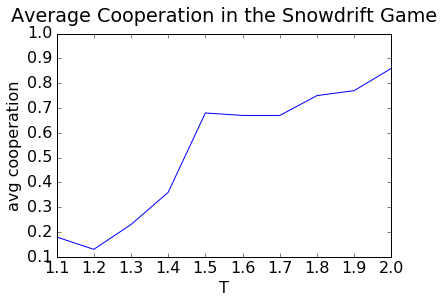

In [789]:
yvalues=arr[0]
plt.plot(xvalues,yvalues)
plt.title("Average Cooperation in the Snowdrift Game",y=1.03)
plt.xlabel("T")
plt.ylabel("avg cooperation")
plt.xlim([1.1,2.0])
plt.ylim([0.1,1])

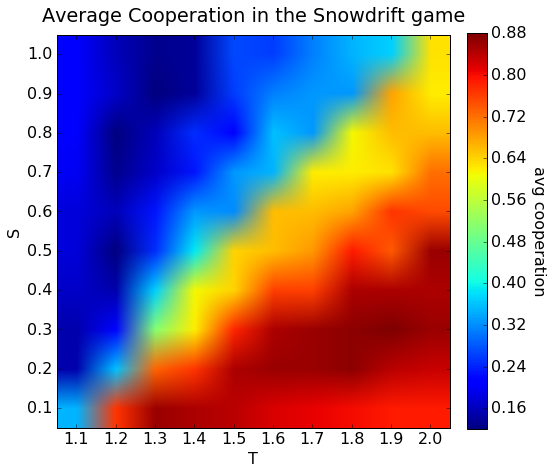

In [792]:
#plot the 2D density map
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(arr)

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("avg cooperation", rotation=-90, va="bottom")
ax.set_xticks(np.arange(len(xvalues)))
ax.set_yticks(np.arange(len(yvalues)))
ax.set_xticklabels(xvalues)
ax.set_yticklabels(yvalues)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
#for i in range(len(arr)):
#    for j in range(len(arr[0])):
#        text = ax.text(j, i, arr[i][j],ha="center", va="center", color="w")

ax.set_title("Average Cooperation in the Snowdrift game",y=1.02)
ax.set_xlabel("T")
ax.set_ylabel("S")
fig.tight_layout()
plt.show()

In [188]:
#example of a simulation where only 31 nodes are active after 10 iterations
#note that large components can be stuck in a minority action
alt_seed=['24-1', '25-1', '26-0', '27-1', '20-1', '21-0', '22-1', '23-1', '28-0', '29-0', '0-0', '4-1', '8-0', '59-0', '58-0', '55-1', '54-0', '57-0', '56-0', '51-0', '50-1', '53-0', '52-0', '88-0', '89-1', '82-0', '83-0', '80-0', '81-0', '86-0', '87-0', '84-1', '85-1', '3-0', '7-0', '39-1', '38-0', '33-1', '32-0', '31-0', '30-0', '37-1', '36-0', '35-0', '34-0', '60-0', '61-0', '62-1', '63-0', '64-1', '65-0', '66-1', '67-1', '68-1', '69-1', '2-0', '6-0', '99-0', '98-1', '91-1', '90-1', '93-0', '92-0', '95-0', '94-0', '97-0', '96-1', '11-1', '10-0', '13-0', '12-0', '15-1', '14-0', '17-1', '16-0', '19-0', '18-0', '48-0', '49-0', '46-1', '47-0', '44-0', '45-1', '42-0', '43-0', '40-1', '41-0', '1-1', '5-0', '9-0', '77-1', '76-0', '75-0', '74-0', '73-1', '72-1', '71-0', '70-0', '79-0', '78-1']

In [203]:
print last_iteration
#act_prob_sim[last_iteration]
#sim=run_simulation(NK,alt_seed,N,'pulse',time_limit=15,pinned={},method='threshold',act_theta=0.5,runs=1)[1]
#for k in sorted(sim[str(alt_seed)][10],key=lambda x:int(x)): print k+':'+str(sim[str(alt_seed)][10][k])+' ',
#N[21]

10


[(0.4, 0.9906), (0.41, 0.9891), (0.42, 0.9787), (0.43, 0.9403), (0.44, 0.9223), (0.45, 0.9522), (0.46, 0.9284), (0.47, 0.9548), (0.48, 0.9523), (0.49, 0.9192), (0.5, 0.9472), (0.51, 0.0476), (0.52, 0.0792), (0.53, 0.0755), (0.54, 0.0483), (0.55, 0.0532), (0.56, 0.1044), (0.57, 0.0771), (0.58, 0.0176), (0.59, 0.0144), (0.6, 0.0107)]


(0, 1.02)

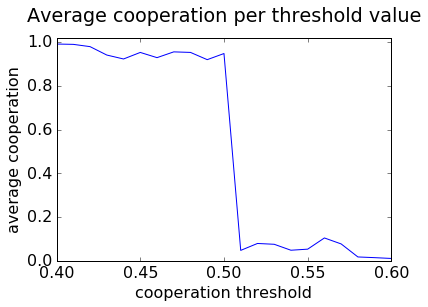

In [303]:
#'phase diagram' of cooperation vs theta
seed=[]
i=10
thetas=np.arange(0,1.1,.05)
thetas=np.linspace(0.4,0.6,21)
yvalues=[]
for theta in thetas:
    act_prob_sim,simulations=run_simulation(NK,seed,N,'pulse',time_limit=i+2,pinned={},method='threshold',act_theta=theta,runs=100,iterations=i)
    last_iteration=max(act_prob_sim)
    yvalues.append(np.mean([act_prob_sim[last_iteration][node] for node in act_prob_sim[last_iteration]]))
    
print zip([round(theta,2) for theta in thetas],[round(y,4) for y in yvalues])
plt.plot(thetas,yvalues)
plt.title("Average cooperation per threshold value",y=1.05)
plt.xlabel("cooperation threshold")
plt.ylabel("average cooperation")
plt.xlim([0.4,0.6])
plt.ylim([0,1.02])

In [44]:
#find all modules of different lengths
nu={}
uinfluence={}
for key in N.nodes():
    unfolding=BFS_general(NK,[str(key)+'-1'],N,'steady',time_limit=10,pinned={},method='threshold',act_theta=0.5)
    nu[key]=unfolding
    uinfluence[key]={node for step in unfolding for node in unfolding[step]}
for key in sorted(uinfluence,key=lambda  x: len(uinfluence[x]),reverse=True)[:10]:
    print key,'\t',len(uinfluence[key])#,nu[key]

36 	3
42 	3
95 	3
1 	2
3 	2
8 	2
19 	2
21 	2
25 	2
29 	2


In [728]:
#reduce LUTs for the NK network
p=0.5 #global activation probability of nodes
iterations=1 #0 is considered the starting state, then iterations 1,2,3...
act_prob = {i: {node.name: p for node in NK.nodes} for i in range(iterations+1)}
ds={node.name: LUT_reduce(look_up_table(node)) for node in NK.nodes}
print len(ds)#,ds
#for node in NK.nodes:
#    print node.name
#    print mf_approx(node,act_prob,1,state=1,reduced=True,ds=ds)
#    print mf_approx(node,act_prob,1,state=1,reduced=False,ds=None),'\n'

100


In [731]:
#find probability that node i will be found in state 1 at time t, depends on the marginal probabilities of its input configurations
p=0.5 #global activation probability of nodes
iterations=10 #0 is considered the starting state, then iterations 1,2,3...
act_prob = {i: {node.name: p for node in NK.nodes} for i in range(iterations+1)}
#act_prob[0][NK.nodes[33].name]=1.0
#act_prob[0]['4']=1.0
tau,total=0.0001,[]
total_act=0 #rows that output 1
for i in range(1,iterations+1):
    for node in NK.nodes:
        s,t=mf_approx(node,act_prob,i,reduced=True,ds=ds,state=1) #solve equation based on probabilities of inputs
        if False: #keep active nodes pinned to 1
            act_prob[i][node.name]=1
        else:
            act_prob[i][node.name]=s
        if i==iterations: 
            #print node.name,s,t,2**node.k,node.inputs
            total_act+=t #only need to count once
            if act_prob[i][node.name] > (1-tau): total.append(node.name)

total_rows=0
avg_act=0.0 #average activation value
for node in NK.nodes: 
    total_rows+=2**node.k
    avg_act+=act_prob[i][node.name]
print total_act/total_rows, avg_act/len(NK.nodes), len(total), total, act_prob[iterations]

0.400682011935 0.0201429302438 0 [] {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0038677188649233196, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0006024933699519952, 20: 0.0, 21: 2.465190328815662e-32, 22: 0.0, 23: 1.1562051238644955e-07, 24: 0.0, 25: 0.0, 26: 0.0, 27: 1.1553653678220144e-07, 28: 0.0, 29: 4.469991427753094e-22, 30: 0.5, 31: 0.0, 32: 0.5047025496940701, 33: 0.5, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.00041748159661247897, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 5.322964291565313e-12, 71: 2.220446049250313e-16, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 8

In [47]:
#find mf-approximation of seeds of given length
kmodules,ktranslator={},{}
ksunits,ksunit_map=get_sunits(NK)
print len(ksunits),#ksunit_map

200


In [732]:
#find pathway modules for the network
start_time = time.time()
#{sunit for sunit in ksunits if int(sunit)%2==1} #only check positive seeds
kmodules,ktranslator=find_modules(NK,1,{sunit for sunit in ksunits},ksunit_map,kmodules,ktranslator,
                                  reduced=True,ds=ds,tau=0.0,iterations=10,pinning={},p=0.5,seeds=None,data=True,samples=None) 
#seeds=[[67,38],[66]]
print("--- Total time: %s seconds ---" % (time.time()-start_time))

seeds: 200
--- Total time: 47.4639999866 seconds ---


In [733]:
#top results by final cooperation
#print kmodules['()']
print len(kmodules)
i=1
for seed in sorted(kmodules,key=lambda x: sum([kmodules[x][i][s] for s in kmodules[x][i]]),reverse=True)[:]:
    sunits=to_list(seed,ksunit_map,ktranslator)
    print sunits,sum([kmodules[seed][i][s] for s in kmodules[seed][i]])

201
['28-0'] 61.69140625
['57-0'] 61.232421875
['12-0'] 61.146484375
['89-0'] 61.126953125
['71-0'] 61.115234375
['47-0'] 61.095703125
['43-0'] 61.076171875
['80-0'] 61.064453125
['22-0'] 61.052734375
['49-0'] 61.001953125
['99-0'] 60.98046875
['83-0'] 60.98046875
['73-0'] 60.939453125
['44-0'] 60.876953125
['98-0'] 60.876953125
['31-0'] 60.814453125
['79-0'] 60.814453125
['3-0'] 60.794921875
['46-0'] 60.794921875
['33-1'] 60.783203125
['1-0'] 60.783203125
['30-1'] 60.783203125
['95-0'] 60.783203125
['59-0'] 60.783203125
['76-0'] 60.763671875
['41-0'] 60.751953125
['0-0'] 60.751953125
['66-0'] 60.751953125
['50-0'] 60.720703125
['96-0'] 60.720703125
['65-0'] 60.689453125
['19-0'] 60.689453125
['90-0'] 60.689453125
['68-0'] 60.669921875
['69-0'] 60.669921875
['24-0'] 60.658203125
['77-0'] 60.658203125
['78-0'] 60.658203125
['75-1'] 60.626953125
['61-0'] 60.626953125
['10-1'] 60.626953125
['15-1'] 60.626953125
['13-0'] 60.626953125
['38-0'] 60.626953125
['20-0'] 60.625
['40-1'] 60.595703

In [52]:
#correlation between total activation and degree
from scipy.stats import pearsonr,spearmanr
#only consider positive activations to get a list of nodes
activation_list=sorted(kmodules,key=lambda x: sum([kmodules[x][i][s] for s in kmodules[x][i]]),reverse=True)[:len(NK.nodes)]
a1=[int(ksunit_map[s][:-2]) for seed in activation_list for s in ktranslator[seed]] #sorted by sum of node activations
a2=sorted(N.nodes(),key=lambda x: N.degree(x),reverse=True) #sorted by degree
print a1,a2
pearsonr(a1,a2),spearmanr(a1,a2)

[28, 57, 12, 89, 71, 47, 43, 80, 22, 49, 99, 83, 73, 98, 44, 79, 31, 46, 3, 95, 59, 1, 76, 41, 66, 0, 50, 96, 90, 65, 19, 69, 68, 77, 78, 24, 13, 61, 38, 20, 45, 7, 87, 9, 48, 55, 84, 36, 37, 58, 29, 42, 93, 35, 91, 62, 53, 5, 21, 85, 72, 92, 25, 18, 86, 64, 16, 60, 8, 26, 51, 56, 14, 4, 2, 11, 63, 34, 67, 32, 70, 88, 54, 52, 97, 40, 94, 39, 74, 75, 10, 15, 23, 27, 17, 82, 6, 81, 33, 30] [28, 12, 22, 71, 47, 49, 57, 73, 83, 89, 99, 0, 1, 3, 7, 38, 41, 43, 44, 50, 68, 77, 79, 80, 87, 96, 98, 13, 20, 24, 31, 45, 46, 59, 65, 66, 69, 76, 78, 90, 95, 2, 8, 9, 11, 14, 18, 19, 25, 37, 42, 48, 51, 53, 56, 61, 62, 63, 67, 72, 84, 4, 5, 16, 21, 26, 29, 34, 35, 36, 55, 58, 60, 64, 85, 86, 91, 92, 93, 6, 17, 23, 27, 32, 39, 52, 54, 70, 74, 81, 82, 88, 97, 10, 15, 40, 75, 94, 30, 33]


((-0.11395139513951395, 0.25895311843633173),
 (-0.11395139513951395, 0.25895311843633523))

In [734]:
#find the error of the mean-field approximation based on simulations
#act_prob_sim,simulations={},{}
seeds=reduce_seeds(kmodules,ksunit_map,ktranslator,length=1,lrange=[])
act_prob_sim,simulations=run_simulations(NK,seeds,N,ksunit_map,ktranslator,length=1,runs=100,act_theta=0.5,iterations=10,
                                         unknown_prob=0.5,stats={},results=True,input_type='pulse',pinned="seeds",
                                         method='literal',act_prob_sim=act_prob_sim,simulations=simulations)
len(act_prob_sim)

total seeds: 200


211

In [737]:
#for i in range(11): del act_prob_sim[i]
len(act_prob_sim)

200

In [738]:
#compare simulations to the mean-field approximation
#act_prob_sim['(105,)'][10]
#kmodules['(105,)'][10]
length=1
seeds=reduce_seeds(kmodules,ksunit_map,ktranslator,length=length,lrange=[]) #dmodules.keys(),['(67,)','(66,)'] (odd numbers are positive)
kstats=compare_simulations(NK,seeds,kmodules,act_prob_sim,tau=0.0,iterations=10,stats={},results=True)

total seeds: 200
true positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97, 0.92, 0.27, 0.17]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.08, 0.73, 0.83]
accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97, 0.92, 0.28, 0.18]
recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.16, 0.02, 0.01]
average similarity: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.16, 0.02, 0.01]
errors: [0.005, 0.005, 0.006, 0.011, 0.019, 0.025, 0.033, 0.032, 0.036, 0.032, 0.036]


In [739]:
#compare simulations to a baseline
start_time = time.time()
length=1
seeds=reduce_seeds(kmodules,ksunit_map,ktranslator,length=length,lrange=[])
kbstats=compare_baseline(NK,seeds,simulations,tau=0.0,iterations=10,stats={},results=True)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

20000 total runs, 200.0 seeds
true positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
false positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
accuracy: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
average similarity: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
errors: [0.05, 0.048, 0.048, 0.047, 0.048, 0.046, 0.047, 0.045, 0.047, 0.045, 0.046]
--- Total time: 509.951999903 seconds ---


In [740]:
#dynamically create variables to plot
exec('errors'+str(length)+"=kstats['errors']")
exec('sim'+str(length)+"=kstats['avg_sim']")
exec('accuracy'+str(length)+"=kstats['accuracy']")
exec('precision'+str(length)+"=kstats['precision']")
exec('recall'+str(length)+"=kstats['recall']")

In [741]:
#graph baseline
exec('berrors'+str(length)+"=kbstats['errors']")
exec('bsim'+str(length)+"=kbstats['avg_sim']")
exec('baccuracy'+str(length)+"=kbstats['accuracy']")
exec('bprecision'+str(length)+"=kbstats['precision']")
exec('brecall'+str(length)+"=kbstats['recall']")

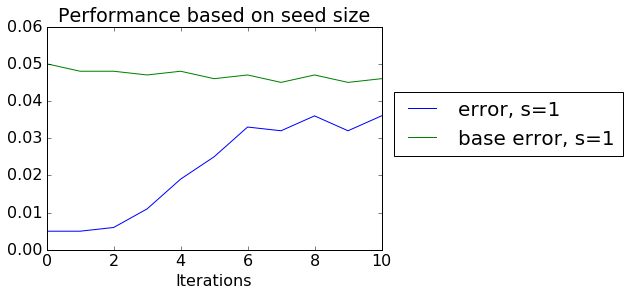

In [742]:
#plot the error over time
iterations=11
length=1
xvalues=[i for i in range(iterations)]
var1=str(length) #what to graph

#plt.plot(xvalues,eval('accuracy'+var1),label='accuracy, s='+var1) #accuracy
#plt.plot(xvalues,eval('precision'+var1),label='precision, s='+var1) #precision
plt.plot(xvalues,eval('errors'+var1),label='error, s='+var1) #errors
#plt.plot(xvalues,eval('sim'+var1),label='constant similarity, s='+var1) #average similarity of constants

#baselines
#plt.plot(xvalues,eval('baccuracy'+var1),label='base accuracy, s='+var1)
#plt.plot(xvalues,eval('bprecision'+var1),label='base precision, s='+var1)
#plt.plot(xvalues,eval('bsim'+var1),label='base similarity, s='+var1)
plt.plot(xvalues,eval('berrors'+var1),label='base error, s='+var1)

plt.title('Performance based on seed size')
plt.xlabel('Iterations')
#plt.ylabel('')
#plt.ylim([-0.01,1.05])
plt.legend(bbox_to_anchor=(2.0, 0.8), fontsize=20)
plt.legend(bbox_to_anchor=(1.6, 0.95), fontsize=20) #errors
plt.legend(bbox_to_anchor=(1.75, 0.75), fontsize=20) #with baselines

In [53]:
#single seed entropy
diffusion=kmodules['()'] #'(3,)','(9, 32, 82)'
config_entropy(diffusion,base=2,normalized=True,strict=True)

({0: 1.0,
  1: 0.93924432833819682,
  2: 0.77417929213849357,
  3: 0.3802633969142144,
  4: 0.068393574082251399,
  5: 0.021272047857294429,
  6: 0.020000072970311002,
  7: 0.020000000000001125,
  8: 0.02,
  9: 0.02,
  10: 0.02},
 {0: 1.0,
  1: 1.0,
  2: 1.0,
  3: 1.0,
  4: 1.0,
  5: 0.5,
  6: 2.710505431213761e-20,
  7: 1.262177448353619e-29,
  8: 3.1554436208840472e-30,
  9: 3.1554436208840472e-30,
  10: 3.1554436208840472e-30})

seeds: 201
Average entropy: [99.0, 92.45, 76.09, 38.15, 7.8, 2.35, 2.01, 1.99, 1.98, 1.98, 1.98]
Normalized entropy: [0.99, 0.92, 0.76, 0.38, 0.08, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02] [1.0, 0.93, 0.77, 0.39, 0.08, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]


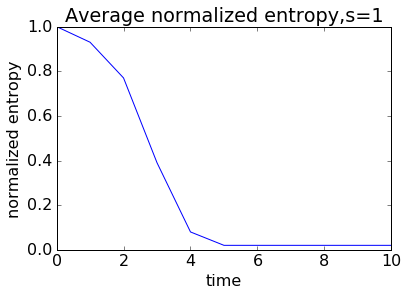

Total possible configurations: [0.5, 0.46, 0.46, 0.46, 0.46, 0.26, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.91, 0.91, 0.91, 0.91, 0.52, 0.0, 0.0, 0.0, 0.0, 0.0]


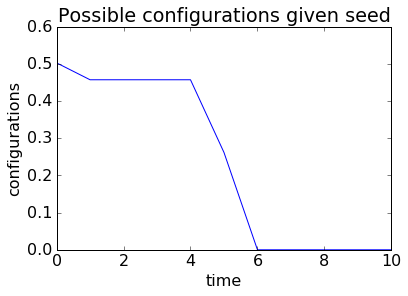

In [54]:
# top results by entropy
length,iterations=1,10
#seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=length) #['()','(3,)']
seeds=kmodules.keys() #simulation entropies
print 'seeds:',len(seeds)
seed_entropy,seed_configs=seed_entropies(kmodules,seeds,normalized=True,data=False) #dmodules, submodules, dact_prob_sim
xvalues=[t for t in range(iterations+1)]
yvalues=[np.mean([seed_entropy[seed][t] for seed in seed_entropy]) for t in xvalues]
print 'Average entropy:',[round(y * 100,2) for y in yvalues]
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 100) for y in yvalues]
#print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
plt.plot(xvalues,[round(yvalue/yvalues[0],2) for yvalue in yvalues])
#plt.ylim([.5,1.01])
plt.title("Average normalized entropy,s="+str(length))
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=seed_entropies(kmodules,seeds,normalized=True,data=False,strict=True) #submodules,dact_prob_sim
x1values=xvalues
y1values=[np.mean([seed_configs[seed][t] for seed in seed_configs]) for t in x1values]
print 'Total possible configurations:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
plt.plot(x1values,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

In [55]:
#list of seed entropies
i=1
seed_entropy,seed_configs=seed_entropies(kmodules,seeds,normalized=False,data=False)
sorted_entropies=sorted(seed_entropy,key=lambda x: seed_entropy[x][i]) #sort by final entropy, lowest entropy first
len(sorted_entropies)#,seed_entropy[sorted_entropies[0]]
for seed in sorted_entropies[:10]: 
    print round(seed_entropy[seed][i],2),'bits',to_list(seed,ksunit_map,ktranslator)#,'length:',len(hdmodules[seed])

90.47 bits ['57-1']
90.8 bits ['80-1']
90.93 bits ['22-1']
90.94 bits ['42-1']
90.99 bits ['79-1']
90.99 bits ['31-1']
91.02 bits ['89-1']
91.04 bits ['1-1']
91.05 bits ['95-1']
91.07 bits ['43-1']


In [56]:
#correlation between entropy reduction and degree
from scipy.stats import pearsonr,spearmanr
#only consider positive activations to get a list of nodes
activation_list=sorted_entropies[:len(NK.nodes)]
a1=[int(ksunit_map[s][:-2]) for seed in activation_list for s in ktranslator[seed]] #sorted by sum of node activations
a2=sorted(N.nodes(),key=lambda x: N.degree(x),reverse=True) #sorted by degree
print a1,a2
pearsonr(a1,a2),spearmanr(a1,a2)

[57, 80, 22, 42, 79, 31, 89, 1, 95, 43, 59, 36, 12, 76, 44, 83, 28, 3, 71, 66, 48, 41, 84, 19, 47, 49, 77, 61, 73, 50, 46, 90, 25, 8, 69, 43, 62, 93, 19, 24, 21, 65, 55, 92, 61, 53, 37, 29, 96, 99, 7, 13, 91, 35, 87, 9, 56, 45, 86, 16, 20, 80, 28, 2, 78, 0, 14, 5, 68, 98, 98, 63, 64, 18, 85, 58, 51, 38, 26, 60, 57, 67, 72, 11, 4, 34, 81, 27, 17, 0, 97, 40, 74, 94, 52, 99, 38, 23, 68, 82] [28, 12, 22, 71, 47, 49, 57, 73, 83, 89, 99, 0, 1, 3, 7, 38, 41, 43, 44, 50, 68, 77, 79, 80, 87, 96, 98, 13, 20, 24, 31, 45, 46, 59, 65, 66, 69, 76, 78, 90, 95, 2, 8, 9, 11, 14, 18, 19, 25, 37, 42, 48, 51, 53, 56, 61, 62, 63, 67, 72, 84, 4, 5, 16, 21, 26, 29, 34, 35, 36, 55, 58, 60, 64, 85, 86, 91, 92, 93, 6, 17, 23, 27, 32, 39, 52, 54, 70, 74, 81, 82, 88, 97, 10, 15, 40, 75, 94, 30, 33]


((-0.10483656200361127, 0.29924734783198592),
 (-0.10856043859745249, 0.2823134486125467))

#### Random Boolean Networks

In [78]:
#exact and average degree k=1,2,3 (ordered, critical, and chaotic phases); compare average error by k
#generate random or erdos-renyi graph
#n=number of nodes, p=probability for edge creation = 2kn/(n**2-n)
k=3.0 #average k
n=100
p=2*k*n/(n**2-n)/2
#NB = nx.erdos_renyi_graph(n, p, directed=False)
NB = nx.random_regular_graph(int(k),n) #NOTE: this is undirected and isn't guaranteed to be connected
#NB = nx.grid_2d_graph(10,10,periodic=True) #lattices
#NB = nx.cycle_graph(n).to_directed() #directed ring structure
print len(NB.edges()),p

150 0.030303030303


In [99]:
#remove excess edges from a directed graph (for k=1 ring structure)
NB.remove_edge(0,99)
for node in NB:
    if (node,node-1) in NB.edges(): NB.remove_edge(node,node-1)
print len(NB.edges())

100


In [79]:
#check node degree distribution
#for node in NB: print  node,NB[node]
from collections import Counter
edge_dist={}
for node in NB:
    edge_dist.setdefault(len(NB[node]),0)
    edge_dist[len(NB[node])]+=1
print Counter(edge_dist),edge_dist,sum([k*edge_dist[k] for k in edge_dist]), sum(NB.degree(NB.nodes()).values())/n
print nx.isolates(NB)
print neighbors(0,NB),predecessors(0,NB)
print [len(ls) for ls in sorted(nx.connected_components(NB), key = len, reverse=True)]

Counter({3: 100}) {3: 100} 300 3.0
[]
{74: {}, 21: {}, 30: {}} {74: {}, 21: {}, 30: {}}
[100]


In [80]:
#DEFINE MODEL
p=0.5
NKB = convert_rnd(NB,p)
print NKB
#BFS_general(NKB,['10-1'],NB,'steady',time_limit=120,pinned={},method='literal',act_theta=theta)

<BNetwork(Name='', N=100, Nodes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])>


In [462]:
#max diffusion for one node activation
#NOTE: for a ring structure, one node will resolve the entire network
#can check BFS_general against influence propagation assuming threshold tau=p
influence={}
ltmodules={}

for node in NB.nodes():
    diffusion = ip.linear_threshold(NB,[node])
    nodes_reached = {n for ls in diffusion for n in ls}
    influence[node] = len(nodes_reached)
    ltmodules[node]=diffusion#nodes_reached

#print nx.isolates(N),theta
for key in sorted(influence,key=lambda x: influence[x],reverse=True)[:10]:
    set1={node for step in ltmodules[key] for node in step}
    unfolding=BFS_general(NKB,[str(key)+'-1'],NB,'steady',time_limit=12,pinned={},method='literal',act_theta=theta)
    set2={node for step in unfolding for node in unfolding[step]}
    #print key,'\t',influence[key],'\t',ltmodules[key],
    print len(set1),len(set2)#,sorted(set2)

1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


In [550]:
#calculate how much cooperation (activation) there is
#NOTE: for k=1, this quickly converges to the same attractor every simulation
#coop_by_k={1:0.0}
seed=[]
i=10
act_prob_sim,simulations=run_simulation(NKB,seed,NB,'pulse',time_limit=i+2,pinned={},method='literal',act_theta=0.5,runs=100,iterations=i)
last_iteration=max(act_prob_sim)
print act_prob_sim[last_iteration]
avg_coop=np.mean([act_prob_sim[last_iteration][node] for node in act_prob_sim[last_iteration]])
print "Average amount of cooperation:",avg_coop
coop_by_k[3]+=avg_coop
print coop_by_k[3]

{'24': 0.39, '25': 0.35, '26': 0.79, '27': 0.02, '20': 0.71, '21': 0.4, '22': 0.0, '23': 0.6, '28': 0.59, '29': 0.38, '0': 0.56, '4': 0.55, '8': 0.57, '59': 0.68, '58': 0.55, '55': 0.94, '54': 0.15, '57': 0.3, '56': 0.28, '51': 0.81, '50': 0.55, '53': 0.0, '52': 0.81, '88': 0.36, '89': 0.51, '82': 0.51, '83': 0.72, '80': 0.43, '81': 0.49, '86': 0.38, '87': 0.09, '84': 1.0, '85': 0.11, '3': 0.61, '7': 0.38, '39': 0.58, '38': 0.81, '33': 0.3, '32': 0.88, '31': 0.52, '30': 0.86, '37': 0.5, '36': 0.39, '35': 0.4, '34': 0.51, '60': 0.71, '61': 1.0, '62': 0.48, '63': 0.44, '64': 0.78, '65': 0.52, '66': 0.95, '67': 0.17, '68': 0.78, '69': 0.83, '2': 0.26, '6': 0.74, '99': 0.27, '98': 0.59, '91': 0.38, '90': 0.63, '93': 0.66, '92': 0.25, '95': 0.0, '94': 0.52, '97': 0.5, '96': 0.24, '11': 0.85, '10': 0.1, '13': 0.22, '12': 0.52, '15': 0.63, '14': 0.48, '17': 0.53, '16': 0.48, '19': 1.0, '18': 0.05, '48': 0.0, '49': 0.88, '46': 0.8, '47': 0.69, '44': 0.29, '45': 0.26, '42': 0.66, '43': 0.27, '4

In [1491]:
#find all modules of different lengths
nu={}
uinfluence={}
for key in NB.nodes():
    unfolding=BFS_general(NKB,[str(key)+'-1'],NB,'steady',time_limit=102,pinned={},method='literal',act_theta=0.5)
    nu[key]=unfolding
    uinfluence[key]={node for step in unfolding for node in unfolding[step]}
for key in sorted(uinfluence,key=lambda  x: len(uinfluence[x]),reverse=True)[:10]:
    print key,'\t',len(uinfluence[key]),nu[key]

0 	1 {0: set(['0-1'])}
1 	1 {0: set(['1-1'])}
2 	1 {0: set(['2-1'])}
3 	1 {0: set(['3-1'])}
4 	1 {0: set(['4-1'])}
5 	1 {0: set(['5-1'])}
6 	1 {0: set(['6-1'])}
7 	1 {0: set(['7-1'])}
8 	1 {0: set(['8-1'])}
9 	1 {0: set(['9-1'])}


In [81]:
#reduce LUTs for the NKB network
p=0.5 #global activation probability of nodes
iterations=1 #0 is considered the starting state, then iterations 1,2,3...
act_prob = {i: {node.name: p for node in NKB.nodes} for i in range(iterations+1)}
ds={node.name: LUT_reduce(look_up_table(node)) for node in NKB.nodes}
print len(ds)#,ds

100


In [421]:
#find probability that node i will be found in state 1 at time t, depends on the marginal probabilities of its input configurations
p=0.5 #global activation probability of nodes
iterations=10 #0 is considered the starting state, then iterations 1,2,3...
act_prob = {i: {node.name: p for node in NKB.nodes} for i in range(iterations+1)}
#act_prob[0][NK.nodes[33].name]=1.0
#act_prob[0]['4']=1.0
tau,total=0.0001,[]
total_act=0 #rows that output 1
for i in range(1,iterations+1):
    for node in NKB.nodes:
        s,t=mf_approx(node,act_prob,i,reduced=True,ds=ds,state=1) #solve equation based on probabilities of inputs
        if False: #keep active nodes pinned to 1
            act_prob[i][node.name]=1
        else:
            act_prob[i][node.name]=s
        if i==iterations: 
            #print node.name,s,t,2**node.k,node.inputs
            total_act+=t #only need to count once
            if act_prob[i][node.name] > (1-tau): total.append(node.name)

total_rows=0
avg_act=0.0 #average activation value
for node in NKB.nodes: 
    total_rows+=2**node.k
    avg_act+=act_prob[i][node.name]
print total_act/total_rows, avg_act/len(NKB.nodes), len(total), total, act_prob[iterations]

0.3525 0.549773046846 5 [60, 71, 73, 79, 94] {0: 0.4045249550209702, 1: 0.6087891093364732, 2: 0.6574954167173046, 3: 0.5952392538801973, 4: 0.44395625480955836, 5: 0.5741735274998527, 6: 0.47063232927883003, 7: 0.7468701679948264, 8: 0.36874793656290283, 9: 0.24541337896626178, 10: 0.13129771937385537, 11: 0.2669699304990887, 12: 0.11380305938013083, 13: 0.5523939027636582, 14: 0.2207753603141091, 15: 0.3955942714225571, 16: 0.2832630362922616, 17: 0.6428846874557763, 18: 0.5476359013827378, 19: 0.6182689108059545, 20: 0.010768560897486764, 21: 0.5897224096815668, 22: 0.008617052112615571, 23: 0.5007377040564156, 24: 0.943981295161521, 25: 0.5923850914908189, 26: 0.6173514330555538, 27: 0.1084444792791296, 28: 0.4921892393459102, 29: 0.440593911169049, 30: 0.8723253649367848, 31: 0.2783947645038136, 32: 0.9772122654308566, 33: 0.11642891569883708, 34: 0.9842627067573075, 35: 0.10907944357932353, 36: 0.357947458907656, 37: 0.5847481577490208, 38: 0.5650805966676303, 39: 0.3949049281188

In [552]:
#check that k=1 structures update correctly; this will resolve with no seeds because some outputs will be constant
#act_prob[4]
#for node in NKB.nodes: print node.name,'\n',ds[node.name],'\n',node.look_up_table(),node.outputs,'\n'

In [82]:
#find mf-approximation of seeds of given length
bmodules,btranslator={},{}
bsunits,bsunit_map=get_sunits(NKB)
print len(bsunits)#,bsunit_map

200


In [83]:
#find pathway modules for the network
start_time = time.time()
#{sunit for sunit in ksunits if int(sunit)%2==1} #only check positive seeds
bmodules,btranslator=find_modules(NKB,0,{sunit for sunit in bsunits},bsunit_map,bmodules,btranslator,
                                  reduced=True,ds=ds,tau=0.0,iterations=10,pinning={},p=0.5,seeds=None,data=True,samples=None) 
#seeds=[[67,38],[66]]
print("--- Total time: %s seconds ---" % (time.time()-start_time))

seeds: 1
--- Total time: 0.743999958038 seconds ---


In [84]:
#top results by final activation
print len(bmodules)
i=1
for seed in sorted(bmodules,key=lambda x: sum([bmodules[x][i][s] for s in bmodules[x][i]]),reverse=True)[:]:
    sunits=to_list(seed,bsunit_map,btranslator)
    print sunits,sum([bmodules[seed][i][s] for s in bmodules[seed][i]])

1
[] 50.0


In [85]:
#find the error of the mean-field approximation based on simulations
act_prob_sim,simulations={},{}
start_time = time.time()
length=0
seeds=reduce_seeds(bmodules,bsunit_map,btranslator,length=length,lrange=[])
act_prob_sim,simulations=run_simulations(NKB,seeds,NB,bsunit_map,btranslator,length=length,runs=100,act_theta=0.5,iterations=10,
                                         unknown_prob=0.5,stats={},results=True,input_type='pulse',pinned="seeds",
                                         method='literal',act_prob_sim=act_prob_sim,simulations=simulations)
print("--- Total time: %s seconds ---" % (time.time()-start_time))
len(act_prob_sim)

total seeds: 1
--- Total time: 1.875 seconds ---


1

In [86]:
act_prob_sim #notice that for k=1, the same attractor is always reached

{'()': {0: {'0': 0.53,
   '1': 0.6,
   '10': 0.55,
   '11': 0.48,
   '12': 0.53,
   '13': 0.53,
   '14': 0.5,
   '15': 0.42,
   '16': 0.53,
   '17': 0.41,
   '18': 0.53,
   '19': 0.45,
   '2': 0.43,
   '20': 0.44,
   '21': 0.5,
   '22': 0.42,
   '23': 0.58,
   '24': 0.47,
   '25': 0.52,
   '26': 0.43,
   '27': 0.45,
   '28': 0.55,
   '29': 0.52,
   '3': 0.46,
   '30': 0.52,
   '31': 0.41,
   '32': 0.5,
   '33': 0.49,
   '34': 0.53,
   '35': 0.5,
   '36': 0.59,
   '37': 0.5,
   '38': 0.48,
   '39': 0.52,
   '4': 0.4,
   '40': 0.46,
   '41': 0.46,
   '42': 0.47,
   '43': 0.51,
   '44': 0.47,
   '45': 0.54,
   '46': 0.49,
   '47': 0.48,
   '48': 0.4,
   '49': 0.47,
   '5': 0.49,
   '50': 0.53,
   '51': 0.52,
   '52': 0.48,
   '53': 0.51,
   '54': 0.54,
   '55': 0.49,
   '56': 0.52,
   '57': 0.51,
   '58': 0.66,
   '59': 0.54,
   '6': 0.55,
   '60': 0.47,
   '61': 0.49,
   '62': 0.48,
   '63': 0.53,
   '64': 0.59,
   '65': 0.48,
   '66': 0.51,
   '67': 0.51,
   '68': 0.56,
   '69': 0.46,
 

In [89]:
#compare simulations to the mean-field approximation
length=0
seeds=reduce_seeds(bmodules,bsunit_map,btranslator,length=length,lrange=[]) #dmodules.keys(),['(67,)','(66,)'] (odd numbers are positive)
bstats=compare_simulations(NKB,seeds,bmodules,act_prob_sim,tau=0.0,iterations=10,stats={},results=True)

total seeds: 1
true positives: [1.0, 1.0, 1.0, 0.5, 0.2, 0.17, 0.11, 0.1, 0.07, 0.06, 0.06]
false negatives: [0.0, 0.0, 0.0, 0.5, 0.8, 0.83, 0.89, 0.9, 0.93, 0.94, 0.94]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 1.0, 1.0, 0.99, 0.96, 0.95, 0.92, 0.91, 0.87, 0.85, 0.85]
recall: [1.0, 1.0, 1.0, 0.5, 0.2, 0.17, 0.11, 0.1, 0.07, 0.06, 0.06]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 1.0, 1.0, 0.5, 0.2, 0.17, 0.11, 0.1, 0.07, 0.06, 0.06]
errors: [0.005, 0.004, 0.005, 0.007, 0.008, 0.007, 0.008, 0.009, 0.01, 0.011, 0.011]


In [90]:
#compare simulations to a baseline
start_time = time.time()
length=0
seeds=reduce_seeds(bmodules,bsunit_map,btranslator,length=length,lrange=[])
bbstats=compare_baseline(NKB,seeds,simulations,tau=0.0,iterations=10,stats={},results=True)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

100 total runs, 1.0 seeds
true positives: [1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]
true negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
false positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
accuracy: [0.0, 0.01, 0.01, 0.02, 0.05, 0.06, 0.09, 0.1, 0.14, 0.16, 0.16]
recall: [1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0]
precision: [0.0, 0.01, 0.01, 0.02, 0.05, 0.06, 0.09, 0.1, 0.14, 0.16, 0.16]
average similarity: [0.0, 0.01, 0.01, 0.02, 0.05, 0.06, 0.09, 0.1, 0.14, 0.16, 0.16]
errors: [0.05, 0.046, 0.044, 0.043, 0.042, 0.041, 0.04, 0.04, 0.039, 0.038, 0.038]
--- Total time: 3.07300019264 seconds ---


In [561]:
#average over multiple networks
k=3
#errors_by_k,baselines_by_k={},{}
#errors_by_k[k]=[0.0 for i in range(11)]
#baselines_by_k[k]=[0.0 for i in range(11)]
for i in range(len(bstats['errors'])): errors_by_k[k][i]+=bstats['errors'][i]
for i in range(len(bbstats['errors'])): baselines_by_k[k][i]+=bbstats['errors'][i]
errors_by_k[k],baselines_by_k[k]

([0.049999999999999996,
  0.046,
  0.06099999999999999,
  0.076,
  0.091,
  0.098,
  0.10399999999999998,
  0.10899999999999999,
  0.11499999999999999,
  0.11699999999999999,
  0.119],
 [0.49999999999999994,
  0.4709999999999999,
  0.4539999999999999,
  0.4479999999999999,
  0.4419999999999999,
  0.4339999999999999,
  0.4299999999999999,
  0.42499999999999993,
  0.42299999999999993,
  0.41899999999999993,
  0.4179999999999999])

In [108]:
#average over multiple networks
#errors_by_k,baselines_by_k={},{}
k=3
t=15
models=100
errors_by_k[k]=[0.0 for i in range(t+1)]
baselines_by_k[k]=[0.0 for i in range(t+1)]
for m in range(models):
    print m,
    bstats,bbstats=RBN_mf_error(n=100,reduced=True,pinning={},tau=0.0,iterations=t,unknown_prob=0.5,s=0,seeds=None,
        pin_start=True,k=k,p=0.5,samples=None,runs=100,act_theta=0.5,method='literal')
    for i in range(len(bstats['errors'])): errors_by_k[k][i]+=bstats['errors'][i]
    for i in range(len(bbstats['errors'])): baselines_by_k[k][i]+=bbstats['errors'][i]
errors_by_k[k]=[error/models for error in errors_by_k[k]]
baselines_by_k[k]=[error/models for error in baselines_by_k[k]]

0 seeds: 1
100 total runs, 1.0 seeds
1 seeds: 1
100 total runs, 1.0 seeds
2 seeds: 1
100 total runs, 1.0 seeds
3 seeds: 1
100 total runs, 1.0 seeds
4 seeds: 1
100 total runs, 1.0 seeds
5 seeds: 1
100 total runs, 1.0 seeds
6 seeds: 1
100 total runs, 1.0 seeds
7 seeds: 1
100 total runs, 1.0 seeds
8 seeds: 1
100 total runs, 1.0 seeds
9 seeds: 1
100 total runs, 1.0 seeds
10 seeds: 1
100 total runs, 1.0 seeds
11 seeds: 1
100 total runs, 1.0 seeds
12 seeds: 1
100 total runs, 1.0 seeds
13 seeds: 1
100 total runs, 1.0 seeds
14 seeds: 1
100 total runs, 1.0 seeds
15 seeds: 1
100 total runs, 1.0 seeds
16 seeds: 1
100 total runs, 1.0 seeds
17 seeds: 1
100 total runs, 1.0 seeds
18 seeds: 1
100 total runs, 1.0 seeds
19 seeds: 1
100 total runs, 1.0 seeds
20 seeds: 1
100 total runs, 1.0 seeds
21 seeds: 1
100 total runs, 1.0 seeds
22 seeds: 1
100 total runs, 1.0 seeds
23 seeds: 1
100 total runs, 1.0 seeds
24 seeds: 1
100 total runs, 1.0 seeds
25 seeds: 1
100 total runs, 1.0 seeds
26 seeds: 1
100 total 

In [110]:
for k in [1,2,3]:
    print k
    print [round(error,4) for error in errors_by_k[k]]
    print [round(error,4) for error in baselines_by_k[k]]

1
[0.0024, 0.0012, 0.0007, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.2526, 0.1287, 0.0648, 0.0325, 0.0166, 0.0083, 0.0039, 0.0019, 0.0008, 0.0004, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0]
2
[0.0026, 0.0019, 0.0054, 0.012, 0.0183, 0.0213, 0.0239, 0.0262, 0.0265, 0.027, 0.0278, 0.0291, 0.0285, 0.0285, 0.0288, 0.0305]
[0.2524, 0.1885, 0.1497, 0.1246, 0.1099, 0.1002, 0.0953, 0.0932, 0.0929, 0.092, 0.0915, 0.0912, 0.092, 0.0914, 0.091, 0.0912]
3
[0.0025, 0.0022, 0.0038, 0.0064, 0.0092, 0.0115, 0.0137, 0.0156, 0.0173, 0.0191, 0.0208, 0.0223, 0.0239, 0.025, 0.026, 0.0272]
[0.2526, 0.221, 0.2055, 0.1962, 0.1895, 0.1826, 0.1769, 0.1727, 0.1694, 0.1657, 0.1628, 0.1604, 0.1583, 0.1563, 0.1546, 0.1532]


In [113]:
print baselines_by_k

{1: [0.25261, 0.12865999999999997, 0.06480999999999998, 0.03245999999999998, 0.01655999999999999, 0.008260000000000003, 0.0039400000000000025, 0.0019400000000000005, 0.0008, 0.00039000000000000005, 0.00013000000000000002, 6e-05, 0.0, 0.0, 0.0, 0.0], 2: [0.25242999999999993, 0.18847000000000005, 0.14966999999999997, 0.12458, 0.10987, 0.10016000000000005, 0.09528, 0.09320000000000002, 0.09286000000000001, 0.09195, 0.09150000000000004, 0.09124000000000004, 0.09197000000000001, 0.09144000000000002, 0.09102000000000007, 0.09115000000000004], 3: [0.2525899999999999, 0.22095999999999996, 0.20554000000000006, 0.19617999999999994, 0.18948000000000007, 0.18258000000000002, 0.17693000000000006, 0.17270000000000002, 0.16935, 0.16569, 0.16275000000000003, 0.16038999999999998, 0.15831, 0.15633999999999995, 0.15457999999999997, 0.15318999999999997]}


In [562]:
#averages for given k
k=3
print coop_by_k[k]/10,errors_by_k[k]
print [round(error/10,4) for error in errors_by_k[k]]
print [round(error/10,4) for error in baselines_by_k[k]]

0.49816000000000005 [0.049999999999999996, 0.046, 0.06099999999999999, 0.076, 0.091, 0.098, 0.10399999999999998, 0.10899999999999999, 0.11499999999999999, 0.11699999999999999, 0.119]
[0.005, 0.0046, 0.0061, 0.0076, 0.0091, 0.0098, 0.0104, 0.0109, 0.0115, 0.0117, 0.0119]
[0.05, 0.0471, 0.0454, 0.0448, 0.0442, 0.0434, 0.043, 0.0425, 0.0423, 0.0419, 0.0418]


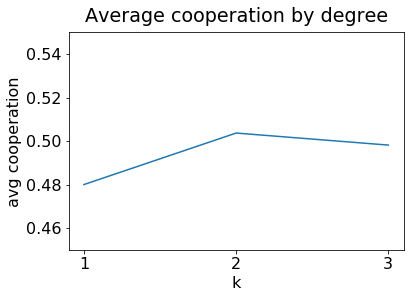

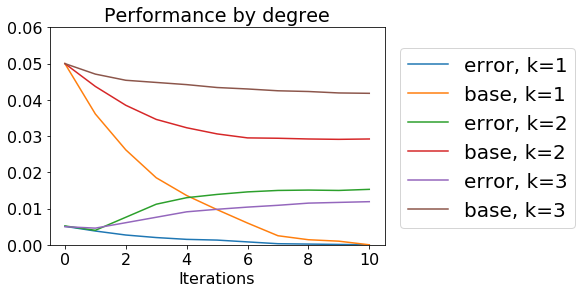

In [563]:
#plot cooperation and error by degree
plt.plot([1,2,3],[coop_by_k[i]/10 for i in coop_by_k])
plt.title("Average cooperation by degree",y=1.02)
plt.ylabel("avg cooperation")
plt.xlabel("k")
plt.ylim([.45,.55])
plt.xticks([1,2,3])
plt.show()

for k in errors_by_k:
    plt.plot([i for i in range(11)],[error/10 for error in errors_by_k[k]],label='error, k='+str(k))
    plt.plot([i for i in range(11)],[error/10 for error in baselines_by_k[k]],label='base, k='+str(k))
plt.title('Performance by degree')
plt.xlabel('Iterations')
plt.ylim([0,.06])
plt.legend(bbox_to_anchor=(1.6, 0.95), fontsize=20)

In [564]:
#dynamically create variables to plot
length=3
exec('errors'+str(length)+"=bstats['errors']")
exec('sim'+str(length)+"=bstats['avg_sim']")
exec('accuracy'+str(length)+"=bstats['accuracy']")
exec('precision'+str(length)+"=bstats['precision']")
exec('recall'+str(length)+"=bstats['recall']")

In [565]:
#graph baseline
exec('berrors'+str(length)+"=bbstats['errors']")
exec('bsim'+str(length)+"=bbstats['avg_sim']")
exec('baccuracy'+str(length)+"=bbstats['accuracy']")
exec('bprecision'+str(length)+"=bbstats['precision']")
exec('brecall'+str(length)+"=bbstats['recall']")

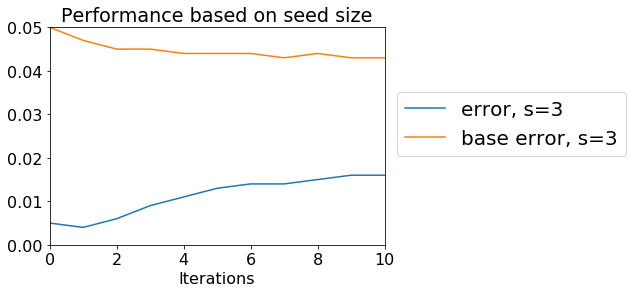

In [566]:
#plot the error over time
iterations=11
length=3
xvalues=[i for i in range(iterations)]
var1=str(length) #what to graph

#plt.plot(xvalues,eval('accuracy'+var1),label='accuracy, s='+var1) #accuracy
#plt.plot(xvalues,eval('precision'+var1),label='precision, s='+var1) #precision
plt.plot(xvalues,eval('errors'+var1),label='error, s='+var1) #errors
#plt.plot(xvalues,eval('sim'+var1),label='constant similarity, s='+var1) #average similarity of constants

#baselines
#plt.plot(xvalues,eval('baccuracy'+var1),label='base accuracy, s='+var1)
#plt.plot(xvalues,eval('bprecision'+var1),label='base precision, s='+var1)
#plt.plot(xvalues,eval('bsim'+var1),label='base similarity, s='+var1)
plt.plot(xvalues,eval('berrors'+var1),label='base error, s='+var1)

plt.title('Performance based on seed size')
plt.xlabel('Iterations')
#plt.ylabel('')
plt.ylim([-0.0,0.05])
plt.xlim([0,10])
plt.legend(bbox_to_anchor=(2.0, 0.8), fontsize=20)
plt.legend(bbox_to_anchor=(1.6, 0.95), fontsize=20) #errors
plt.legend(bbox_to_anchor=(1.75, 0.75), fontsize=20) #with baselines

#### Driver Set Sizes

In [105]:
#check that we don't get sizes greater than 0 when bias is zero
N0 = nx.cycle_graph(20).to_directed()
N0 = nx.random_regular_graph(int(3),20)
N0 = convert_rnd(N0,0.0)
d0={node.name: LUT_reduce(look_up_table(node)) for node in N0.nodes}
s0units,s0unit_map=get_sunits(N0)
print driver_selection(N0,s0units,s0unit_map,{},{},seeds=None,max_s=10,top=1,reduced=True,ds=d0,force=True)
diffusion=find_modules(N0,0,s0units,s0unit_map,{},{},reduced=True,ds=d0,iterations=10,
                           data=True,seeds=[()],p=0.5,verbose=False,pin_start=True)
#diffusion[0]['()'][1] #should all be 1.0

()


In [278]:
#run over several biases for a fixed n and fixed k
n,k=50,3.0
biases=[0,.1,.2,.3,.4,.5]
yvalues,times=[],[]
for b in biases:
    #for each bias, make sure to reset stats!
    stats=RBN_driver_selections(N=[n],models=100,max_s=25,top=1,reduced=True,pinning={},tau=0.0,iterations=10,
    unknown_prob=0.5,t=10,base=2,normalized=True,pin_start=True,force=True,k=k,p=b,dcm=False,stats={})
    print stats
    yvalues.append(stats[n]['size'])
    times.append(stats[n]['time'])

{50: {'resolved': 0.0, 'time': 1.8878000140190125, 'size': 0.0}}
{50: {'resolved': 0.0, 'time': 44.396130001544954, 'size': 2.02}}
{50: {'resolved': 0.0, 'time': 165.76478999614716, 'size': 5.81}}
{50: {'resolved': 0.0, 'time': 282.2658999991417, 'size': 9.43}}
{50: {'resolved': 0.0, 'time': 356.18843999862673, 'size': 11.99}}
{50: {'resolved': 0.0, 'time': 383.34782999515534, 'size': 13.2}}


[0.0, 2.02, 5.81, 9.43, 11.99, 13.2]
{2.0: [0.0, 0.56, 1.67, 2.77, 3.48, 3.71], 3.0: [0.0, 0.77, 2.3, 3.58, 4.83, 5.18]}


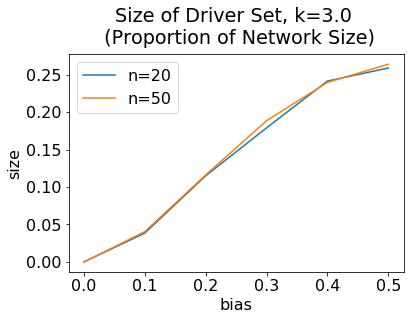

In [282]:
#graph biases for a given n,k
print yvalues
#sizes={}
#sizes[k]=yvalues
#for key in sizes:
#    plt.plot(biases,[s/20 for s in sizes[key]],label='k='+str(key))
plt.plot(biases,[s/20 for s in sizes[3]],label='n=20')
plt.plot(biases,[y/50 for y in yvalues],label='n=50')
plt.xlabel("bias")
plt.ylabel("size")
#plt.title("Size of Driver Set, n={} \n (Proportion of Network Size)".format(n),y=1.02)
plt.title("Size of Driver Set, k={} \n (Proportion of Network Size)".format(k),y=1.02)
plt.legend()
print sizes

[1.8878000140190125, 44.396130001544954, 165.76478999614716, 282.2658999991417, 356.18843999862673, 383.34782999515534]
{2.0: [0.31588000774383546, 2.3376500034332275, 6.250590007305146, 11.279599990844726, 14.798439998626709, 16.31821000814438], 3.0: [0.3128200078010559, 4.008030033111572, 10.46759001970291, 17.164460005760194, 22.65887000322342, 24.271189994812012]}


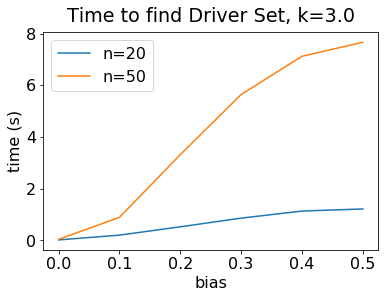

In [283]:
#graph time per biases for a given n,k
#ktimes={}
#ktimes[k]=times
print times
#for key in ktimes:
#    plt.plot(biases,ktimes[key],label='k='+str(key))
plt.plot(biases,[s/20 for s in ktimes[3]],label='n=20')
plt.plot(biases,[y/50 for y in times],label='n=50')
plt.xlabel("bias")
plt.ylabel("time (s)")
#plt.title("Time to find Driver Set, n={}".format(n),y=1.02)
plt.title("Time to find Driver Set, k={}".format(k),y=1.02)
plt.legend()
print ktimes

In [ ]:
#TODO: driver selection over n

#### Cell Collective

In [3]:
#read in the Cell Collective networks
from cana import BooleanNetwork
#mypath=C:\Users\Sir Thomius\Documents\Dynamics\Build based on Cell Collective 2020.08\models used in PNAS 2021 paper\duplicate removed\
mypath="C:\\Users\\Sir Thomius\\Documents\\Dynamics\\Build based on Cell Collective 2020.08\\models used in PNAS 2021 paper\\duplicate removed\\"
mypath="C:\\Users\\tjparmer\\Documents\\Dynamics\\Build based on Cell Collective 2020.08\\models used in PNAS 2021 paper\\duplicate removed\\"
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
networks=[]
for f in onlyfiles:
    B=BooleanNetwork.from_file(mypath+"\\"+f)
    #print f,len(B.nodes),max([len(node.inputs) for node in B.nodes])
    B.name=f[:-4] #ensure the network has a name and remove .txt
    networks.append(B)

print len(networks)

74


In [6]:
#gather network statistics
network_data={}
for network in networks:
    size=len(network.nodes)
    max_k=max([len(node.inputs) for node in network.nodes])
    avg_k=np.mean([len(node.inputs) for node in network.nodes])
    avg_bias=np.mean([np.sum([row[2] for row in look_up_table(node).itertuples()])/len(node.look_up_table()) for node in network.nodes])
    #print network.name,size,max_k,avg_k,avg_bias
    network_data[network.name]={'size': size,'max_k': max_k,'avg_k': avg_k,'avg_bias': avg_bias}
#for network in network_data: print network,network_data[network]['avg_bias']
#for node in B.nodes: 
#    print node.name,node.look_up_table(),np.sum([row[2] for row in look_up_table(node).itertuples()])/len(node.look_up_table())
len(network_data)

74

In [132]:
#minimal driver sets for cell collective networks
#cell_drivers={}
iterations=10
t=iterations
#gsolutions,gnames={},{}
begin_time = time.time()
for n in sorted(networks,key=lambda x: network_data[x.name]['size'])[:]:
    if n.name!='CD4 T cell signaling': continue
    start_time = time.time() 
    dd={node.name: LUT_reduce(look_up_table(node)) for node in n.nodes}
    dnodes=dd.keys()
    print n.name#,len(dd)
    dmodules,dtranslator={},{'()':()}
    dsunits,dsunit_map=get_sunits(n)
    #find unconstrained selection
    selection=driver_selection(n,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=50,top=1,reduced=True,ds=dd,t=t,
        attractor=None,attractors=None,pin_start=True,force=True,iterations=iterations,names='string',start_seed=())
    if selection: 
        print selection, to_list(selection,dsunit_map,dtranslator)
        gsolutions[n.name]=selection
        gnames[n.name]=to_list(selection,dsunit_map,dtranslator)
        length=len(selection)
    else: 
        print None
        length=0
    cell_drivers[n.name]={'size': length, 'time': time.time()-start_time}
    #clean up memory
    del dd
    del dmodules
    del dtranslator
print("--- Total time: %s seconds ---" % (time.time()-begin_time))

CD4 T cell signaling
(56, 69, 269, 308, 310, 312, 314, 317, 319, 321, 323, 324, 326, 329, 330, 332, 334, 336, 338, 341, 343, 344, 347, 348, 350, 352, 354, 356, 359, 361, 362, 364, 367, 368, 371, 373, 374) ['RORGT-0', 'IL4R-1', 'IL2R_HIGH-1', 'IL10_e-0', 'IL9_e-0', 'CAV1_ACTIVATOR-0', 'IL6RA-0', 'TGFB_e-1', 'B7-1', 'IFNGR1-1', 'IL15RA-1', 'IFNGR2-0', 'Galpha_QL-0', 'IL22_e-1', 'IL18_e-0', 'Galpha_iL-0', 'IL27_e-0', 'alpha_13L-0', 'IL2_e-0', 'GalphaS_L-1', 'APC-1', 'GP130-0', 'IFNG_e-1', 'IL12_e-0', 'IL21_e-0', 'IL23_e-0', 'IL2RB-0', 'IL10RA-0', 'IL27RA-1', 'IL6_e-1', 'ECM-0', 'CGC-0', 'IL15_e-1', 'IL10RB-0', 'MHC_II-1', 'IL4_e-1', 'IFNB_e-0']
--- Total time: 17373.2900002 seconds ---


In [15]:
with open("cell_drivers_names.txt") as f:
    gnames=eval(f.read())
len(gnames)

73

In [11]:
#cell_drivers['CD4 T cell signaling']
#gsolutions
gnames['Apoptosis Network'],#[x.name for x in network_inputs(n)]

(['IAP-1', 'NFkB-1', 'TNF-0', 'GF-0'],)

In [16]:
#manual neighbors function for cana; takes BooleanNetwork, BooleanNode as inputs
def neighbors_BN(n,node):
    return [x.name for x in n.nodes if node.name in x.inputs]

#ND = DROSOPHILA()
#for node in ND.nodes: print node.name,neighbors_BN(ND,node)

In [20]:
#plot nodes inclusion in minimal driver set as part of in-degree/out-degree plot
driver_nodes={}
for n in networks:
    #inputs=[x.name for x in network_inputs(n)]
    if n.name in gnames: 
        included=[node[:-2] for node in gnames[n.name]]
    else: included=[]
    #print n.name,included
    indeg=[len(node.inputs) if not node in network_inputs(n) else 0 for node in n.nodes] #specify inputs as in-degree=0
    outdeg=[len(neighbors_BN(n,node)) for node in n.nodes]
    inc=[int(node.name in included) for node in n.nodes]
    driver_nodes[n.name]={'in-degree':indeg,'out-degree':outdeg,'included':inc}
    #print len(network_inputs(n)), len([x for x in indeg if x==0])
    
#driver_nodes

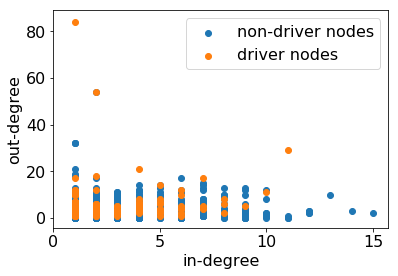

In [151]:
#scatter plot of in-degree, out-degree
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
xvalues0=[x for n in networks for i,x in enumerate(driver_nodes[n.name]['in-degree']) if not driver_nodes[n.name]['included'][i]] #drivers
yvalues0=[x for n in networks for i,x in enumerate(driver_nodes[n.name]['out-degree']) if not driver_nodes[n.name]['included'][i]] #drivers
xvalues1=[x for n in networks for i,x in enumerate(driver_nodes[n.name]['in-degree']) if driver_nodes[n.name]['included'][i]] #drivers
yvalues1=[x for n in networks for i,x in enumerate(driver_nodes[n.name]['out-degree']) if driver_nodes[n.name]['included'][i]] #drivers
labels=[colors[x] for n in networks for x in driver_nodes[n.name]['included']]
plt.scatter(xvalues0,yvalues0,label='non-driver nodes') #c=labels
plt.scatter(xvalues1,yvalues1,label='driver nodes')
plt.xlabel("in-degree")
plt.ylabel("out-degree")
plt.xticks([0,5,10,15])
plt.legend()

In [52]:
#minimal driver set results; first run
cell_drivers={'Apoptosis Network': {'resolved': 41, 'size': 4, 'time': 19.77900004386902},
 'Arabidopsis thaliana Cell Cycle': {'resolved': 14, 'size': 1, 'time': 0.9249999523162842},
 'Aurora Kinase A in Neuroblastoma': {'resolved': 23, 'size': 5, 'time': 7.287999868392944},
 'B bronchiseptica and T retortaeformis coinfection': {'resolved': 53, 'size': 4,'time': 35.80299997329712},
 'B cell differentiation': {'resolved': 22, 'size': 5, 'time': 6.3500001430511475},
 'BT474 Breast Cell Line Long-term ErbB Network': {'resolved': 25, 'size': 9, 'time': 13.075999975204468},
 'BT474 Breast Cell Line Short-term ErbB Network': {'resolved': 16, 'size': 6,'time': 3.4839999675750732},
 'Bordetella bronchiseptica': {'resolved': 33, 'size': 2, 'time': 6.601000070571899},
 'Bortezomib Responses in U266 Human Myeloma Cells': {'resolved': 56, 'size': 6, 'time': 77.24600005149841},
 'Budding Yeast Cell Cycle': {'resolved': 20, 'size': 4, 'time': 4.420000076293945},
 'Budding Yeast Cell Cycle 2009': {'resolved': 11, 'size': 2, 'time': 2.132000207901001},
 'CD4+ T cell Differentiation': {'resolved': 38, 'size': 11, 'time': 45.53600001335144},
 'Cardiac development': {'resolved': 12, 'size': 2, 'time': 1.3340001106262207},
 'Cell Cycle Transcription by Coupled CDK and Network Oscillators': {'resolved': 9, 'size': 1, 'time': 0.247999906539917},
 'Cholesterol Regulatory Pathway': {'resolved': 34, 'size': 3, 'time': 9.830000162124634},
 'Colitis-associated colon cancer': {'resolved': 70, 'size': 6, 'time': 84.58200001716614},
 'Cortical Area Development': {'resolved': 0, 'size': 0, 'time': 0.07599997520446777},
 'Death Receptor Signaling': {'resolved': 28, 'size': 4, 'time': 8.575000047683716},
 'FGF pathway of Drosophila Signalling Pathways': {'resolved': 23, 'size': 9, 'time': 10.068000078201294},
 'Fanconi anemia and checkpoint recovery': {'resolved': 15, 'size': 1, 'time': 0.9609999656677246},
 'Glucose Repression Signaling 2009': {'resolved': 73, 'size': 18, 'time': 244.4210000038147},
 'Guard Cell Abscisic Acid Signaling': {'resolved': 44, 'size': 5, 'time': 27.236999988555908},
 'HCC1954 Breast Cell Line Long-term ErbB Network': {'resolved': 13, 'size': 7, 'time': 11.225000143051147},
 'HCC1954 Breast Cell Line Short-term ErbB Network': {'resolved': 16, 'size': 6, 'time': 3.5139999389648438},
 'HGF Signaling in Keratinocytes': {'resolved': 68, 'size': 6, 'time': 90.69199991226196},
 'HH Pathway of Drosophila Signaling Pathways': {'resolved': 24, 'size': 13, 'time': 14.083000183105469},
 'IL-1 Signaling': {'resolved': 118, 'size': 15, 'time': 604.1490001678467},
 'IL-6 Signalling': {'resolved': 86, 'size': 16, 'time': 304.56500005722046},
 'Iron acquisition and oxidative stress response in aspergillus fumigatus': {'resolved': 22, 'size': 3, 'time': 4.0929999351501465},
 'Lac Operon': {'resolved': 13, 'size': 3, 'time': 1.3009998798370361},
 'MAPK Cancer Cell Fate Network': {'resolved': 53, 'size': 4, 'time': 40.28200006484985},
 'Mammalian Cell Cycle': {'resolved': 20, 'size': 1, 'time': 1.2239999771118164},
 'Mammalian Cell Cycle 2006': {'resolved': 10, 'size': 3, 'time': 0.7990000247955322},
 'Metabolic Interactions in the Gut Microbiome': {'resolved': 7, 'size': 4, 'time': 1.4119999408721924},
 'Neurotransmitter Signaling Pathway': {'resolved': 16, 'size': 2, 'time': 1.426999807357788},
 'Oxidative Stress Pathway': {'resolved': 19, 'size': 1, 'time': 1.0989999771118164},
 'PC12 Cell Differentiation': {'resolved': 62, 'size': 2, 'time': 22.924999952316284},
 'Predicting Variabilities in Cardiac Gene': {'resolved': 12, 'size': 2, 'time': 1.313000202178955},
 'Processing of Spz Network from the Drosophila Signaling Pathway': {'resolved': 24, 'size': 6, 'time': 8.421000003814697},
 'Regulation of the L-arabinose operon of Escherichia coli': {'resolved': 12, 'size': 4, 'time': 1.6150000095367432},
 'SKBR3 Breast Cell Line Long-term ErbB Network': {'resolved': 25, 'size': 6, 'time': 10.647000074386597},
 'SKBR3 Breast Cell Line Short-term ErbB Network': {'resolved': 16, 'size': 6, 'time': 3.434000015258789},
 'Senescence Associated Secretory Phenotype': {'resolved': 51, 'size': 3, 'time': 23.128999948501587},
 'Septation Initiation Network': {'resolved': 31, 'size': 9, 'time': 20.52500009536743},
 'Signaling Pathway for Butanol Production in Clostridium beijerinckii NRRL B-598': {'resolved': 66, 'size': 14, 'time': 162.44299983978271},
 'T Cell Receptor Signaling': {'resolved': 101, 'size': 7, 'time': 205.7829999923706},
 'T cell differentiation': {'resolved': 23, 'size': 5, 'time': 6.836000204086304},
 'T-Cell Signaling 2006': {'resolved': 40, 'size': 4, 'time': 18.016000032424927},
 'T-LGL Survival Network 2008': {'resolved': 61, 'size': 8, 'time': 87.62199997901917},
 'T-LGL Survival Network 2011': {'resolved': 60, 'size': 7, 'time': 74.84100008010864},
 'T-LGL Survival Network 2011 Reduced Network': {'resolved': 18, 'size': 1, 'time': 1.003000020980835},
 'Toll Pathway of Drosophila Signaling Pathway': {'resolved': 11, 'size': 2, 'time': 0.6419999599456787},
 'Treatment of Castration-Resistant Prostate Cancer': {'resolved': 42, 'size': 14, 'time': 55.2720000743866},
 'Trichostrongylus retortaeformis': {'resolved': 26, 'size': 3, 'time': 5.909999847412109},
 'Tumour Cell Invasion and Migration': {'resolved': 32, 'size': 4, 'time': 14.36299991607666},
 'VEGF Pathway of Drosophila Signaling Pathway': {'resolved': 18, 'size': 8, 'time': 5.519000053405762},
 'Wg Pathway of Drosophila Signalling Pathways': {'resolved': 26, 'size': 14,'time': 17.953999996185303},
 'CD4 T cell signaling': {'size': 37, 'time': 3729.173000097275},
 'CD4+ T Cell Differentiation and Plasticity': {'size': 6,
  'time': 5.718999862670898},
 'Differentiation of T lymphocytes': {'size': 10, 'time': 70.48699998855591},
 'EGFR & ErbB Signaling': {'size': 28, 'time': 3169.226000070572},
 'FA BRCA pathway': {'size': 3, 'time': 8.236000061035156},
 'HIV-1 interactions with T Cell Signalling Pathway': {'size': 15,
  'time': 1313.805999994278},
 'Human Gonadal Sex Determination': {'size': 1, 'time': 1.7029998302459717},
 'IGVH mutations in chronic lymphocytic leukemia': {'size': 25,
  'time': 475.8550000190735},
 'Influenza A Virus Replication Cycle': {'size': 11,
  'time': 591.8919999599457},
 'Lymphoid and myeloid cell specification and transdifferentiation': {'size': 4,
  'time': 15.93999981880188},
 'Lymphopoiesis Regulatory Network': {'size': 15, 'time': 271.06900000572205},
 'Pro-inflammatory Tumor Microenvironment in Acute Lymphoblastic Leukemia': {'size': 4,
  'time': 9.776000022888184},
 'Signal Transduction in Fibroblasts': {'size': 24,
  'time': 3992.8830001354218},
 'Signaling in Macrophage Activation': {'size': 19, 'time': 5926.226999998093},
 'Stomatal Opening Model': {'size': 5, 'time': 48.061999797821045},
 'TOL Regulatory Network': {'size': 10, 'time': 19.236999988555908},
 'Yeast Apoptosis': {'size': 13, 'time': 184.06900000572205}}
len(cell_drivers)

74

In [252]:
#json dump cell collective data
#with open('cell_collective_statistics.json', 'w') as fp:
#    json.dump(network_data, fp)
#with open('cell_collective_drivers.json', 'w') as fp:
#    json.dump(cell_drivers, fp)
#with open('cell_collective_cana.json', 'w') as fp:
#    json.dump(cana_data, fp)
#with open('HH-pathway_entropies_s1.json', 'w') as fp: #CD4 or HH-Pathway
#    json.dump(seed_entropy, fp)
#with open('HH-pathway_translator_s1.json', 'w') as fp:
#    json.dump(dptranslator, fp)
#with open('HH-pathway_sunit_map_s1.json', 'w') as fp:
#    json.dump(dpsunit_map, fp)
len(dptranslator)

49

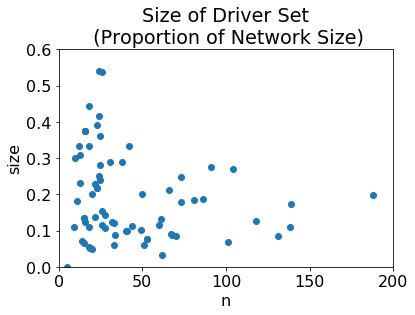

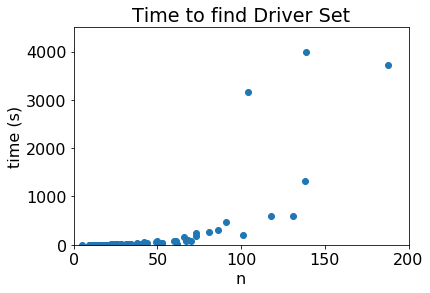

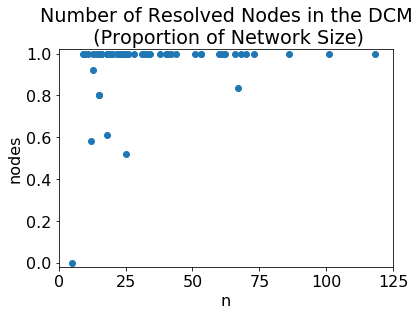

In [63]:
#graph minimal driver set size
subnetworks=[n for n in networks] #if network_data[n.name]['max_k']>=9
xvalues=[network_data[n.name]['size'] for n in subnetworks]
yvalues=[cell_drivers[n.name]['size']/network_data[n.name]['size'] for n in subnetworks]
plt.scatter(xvalues,yvalues)
plt.title('Size of Driver Set\n (Proportion of Network Size)')
plt.ylim([0,.6])
plt.xlim([0,200]) #one outlier of size 321
plt.ylabel('size')
plt.xlabel('n')
plt.show()

#graph time to find minimal driver sets
xvalues=[network_data[n.name]['size'] for n in subnetworks]
yvalues=[cell_drivers[n.name]['time'] for n in subnetworks]
plt.scatter(xvalues,yvalues)
plt.title('Time to find Driver Set')
plt.ylim([0,4500])
plt.xlim([0,200]) #one outlier of size 321
plt.ylabel('time (s)')
plt.xlabel('n')
plt.show()

#graph number of resolved nodes in the DCM; NOTE, this is not found yet for max_k >= 9
xvalues=[network_data[n.name]['size'] for n in subnetworks if network_data[n.name]['max_k']<9]
yvalues=[cell_drivers[n.name]['resolved']/network_data[n.name]['size'] for n in subnetworks if network_data[n.name]['max_k']<9]
plt.scatter(xvalues,yvalues)
plt.title('Number of Resolved Nodes in the DCM\n (Proportion of Network Size)')
plt.ylim([-0.02,1.02])
plt.xlim([0,125]) #one outlier of size 321
plt.ylabel('nodes')
plt.xlabel('n')
plt.show()

[4, 5, 4, 5, 4, 4, 5, 4, 6, 4, 4, 5, 5, 3, 4, 4, 5, 4, 2, 4, 5, 4, 3, 2, 5, 5, 4, 5, 6, 5, 5, 6, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 7, 5, 4, 5, 4, 5, 5, 4, 4, 5, 4, 6, 4, 5, 4, 4, 3, 3, 3, 4, 5, 5, 5, 3, 5, 4, 6]


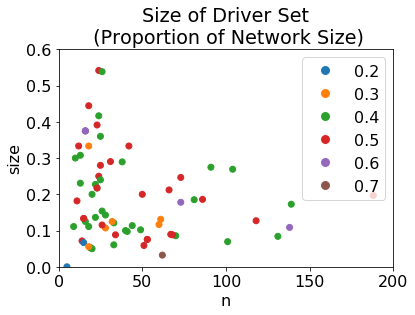

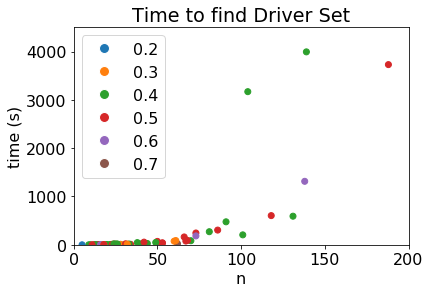

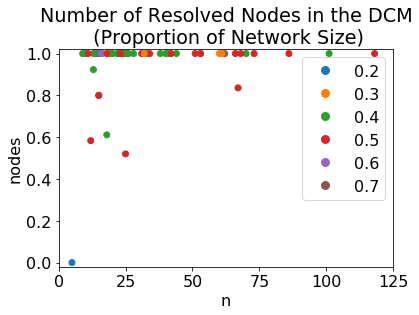

In [134]:
#GRAPH the same but with labels based on network statistics
#NOTE: the length of colors is only 10
from matplotlib.lines import Line2D
stat='avg_bias'
subnetworks=[n for n in networks if network_data[n.name]['max_k']] #if network_data[n.name]['max_k']>=9
labels=[int(round(network_data[n.name][stat])) for n in subnetworks] #SPECIFY STAT
labels=[int(round(network_data[n.name][stat],1)*10) for n in subnetworks] #for avg_bias
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
lcolors=[colors[x-min(labels)] for x in labels]
legend_labels=set(sorted(labels))
legend_labels=[l/10 for l in set(sorted(labels))] #for avg_bias
legend_pts=[Line2D([], [], marker='o', color='w', label=col, markerfacecolor=col, markersize=10) for col in colors if col in lcolors]
print labels#,lcolors,len(legend_pts)

#graph minimal driver set size
xvalues=[network_data[n.name]['size'] for n in subnetworks]
yvalues=[cell_drivers[n.name]['size']/network_data[n.name]['size'] for n in subnetworks]
plt.scatter(xvalues,yvalues,color=lcolors) #c=labels
plt.title('Size of Driver Set\n (Proportion of Network Size)')
plt.ylim([0,.6])
plt.xlim([0,200]) #one outlier of size 321
plt.ylabel('size')
plt.xlabel('n')
plt.legend(legend_pts,legend_labels)
plt.show()

#graph time to find minimal driver sets
xvalues=[network_data[n.name]['size'] for n in subnetworks]
yvalues=[cell_drivers[n.name]['time'] for n in subnetworks]
plt.scatter(xvalues,yvalues,color=lcolors)
plt.title('Time to find Driver Set')
plt.ylim([0,4500])
plt.xlim([0,200]) #one outlier of size 321
plt.ylabel('time (s)')
plt.xlabel('n')
plt.legend(legend_pts,legend_labels)
plt.show()

#graph number of resolved nodes in the DCM; NOTE, this is not found yet for max_k >= 9
labels=[int(round(network_data[n.name][stat])) for n in subnetworks if network_data[n.name]['max_k']<9]
labels=[int(round(network_data[n.name][stat],1)*10) for n in subnetworks if network_data[n.name]['max_k']<9] #for avg_bias
lcolors=[colors[x-min(labels)] for x in labels]
legend_labels=set(sorted(labels))
legend_labels=[l/10 for l in set(sorted(labels))] #for avg_bias
legend_pts=[Line2D([], [], marker='o', color='w', label=col, markerfacecolor=col, markersize=10) for col in colors if col in lcolors]

xvalues=[network_data[n.name]['size'] for n in subnetworks if network_data[n.name]['max_k']<9]
yvalues=[cell_drivers[n.name]['resolved']/network_data[n.name]['size'] for n in subnetworks if network_data[n.name]['max_k']<9]
plt.scatter(xvalues,yvalues,color=lcolors)
plt.title('Number of Resolved Nodes in the DCM\n (Proportion of Network Size)')
plt.ylim([-0.02,1.02])
plt.xlim([0,125]) #one outlier of size 321
plt.ylabel('nodes')
plt.xlabel('n')
plt.legend(legend_pts,legend_labels)
plt.show()

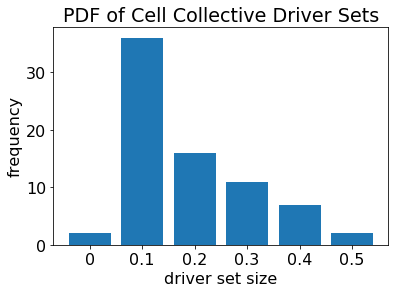

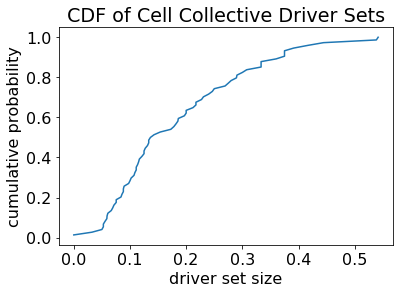

In [208]:
#cumulative distribution of driver set size
sorted_networks=sorted(networks,key=lambda x: cell_drivers[x.name]['size']/network_data[x.name]['size'])
#for n in sorted_networks: print n.name,cell_drivers[n.name]['size']/network_data[n.name]['size']

#rounded pdf
dvalues=[round(cell_drivers[n.name]['size']/network_data[n.name]['size'],1) for n in sorted_networks]
xvalues=sorted(set(dvalues))
yvalues=[dvalues.count(x) for x in xvalues]
#print dvalues,zip(sorted(set(dvalues)),[dvalues.count(x) for x in xvalues])
xvalues,yvalues=[0,1,2,3,4,5],[2,36,16,11,7,2] #hardcode because matplotlib can't graph simple bar graphs otherwise
plt.bar(x=xvalues,height=yvalues,width=0.8,align='center',tick_label=xvalues)
plt.title('PDF of Cell Collective Driver Sets')
#plt.ylim([0,.6])
#plt.xlim([0,200]) #one outlier of size 321
plt.ylabel('frequency')
plt.xlabel('driver set size')
plt.xticks([0,1,2,3,4,5],[0,.1,.2,.3,.4,.5])
#plt.ticklabel_format(useOffset=False)
plt.show()

#cdf
#print np.cumsum(dvalues),np.sum(dvalues),[np.cumsum(dvalues)/np.sum(dvalues)]
dvalues=[cell_drivers[n.name]['size']/network_data[n.name]['size'] for n in sorted_networks]
yvalues=[(i+1)/len(dvalues) for i in range(len(dvalues))]
#yvalues=[np.cumsum(dvalues)/np.sum(dvalues)][0]
#print dvalues,yvalues
plt.plot(dvalues,yvalues)
plt.title('CDF of Cell Collective Driver Sets')
plt.ylabel('cumulative probability')
plt.xlabel('driver set size')
plt.show()

In [205]:
#find cdf value of a specific point
point=0.20
for i,val in enumerate(dvalues):
    if val>point:
        break
print i,val,i/len(dvalues),yvalues[i-1]

47 0.212121212121 0.635135135135 0.635135135135


In [233]:
#observe how a large network's entropy values change over time
for network in sorted(networks,key=lambda x: network_data[x.name]['size'],reverse=True)[:2]: 
    print network.name,network_data[network.name]
#observe entropy values for a network with a large driver set size
for network in sorted(networks,key=lambda x: cell_drivers[x.name]['size']/float(network_data[x.name]['size']),reverse=True)[:1]: 
    print network.name,cell_drivers[network.name],#network_data[network.name],
    print cell_drivers[network.name]['size']/float(network_data[network.name]['size'])

Signaling in Macrophage Activation {'avg_k': 1.6822429906542056, 'avg_bias': 0.4462160484813084, 'max_k': 10, 'size': 321}
CD4 T cell signaling {'avg_k': 2.021276595744681, 'avg_bias': 0.5037608045212766, 'max_k': 10, 'size': 188}
HH Pathway of Drosophila Signaling Pathways {'resolved': 24, 'time': 14.083000183105469, 'size': 13} 0.541666666667


In [51]:
NP=network
dp={node.name: LUT_reduce(look_up_table(node)) for node in NP.nodes}
dpnodes=dp.keys()
print len(dp),#dpnodes
dpmodules,dptranslator={},{}
dpsunits,dpsunit_map=get_sunits(NP)
print len(dpsunits),len(dpsunit_map),NP.name

73 146 146 Yeast Apoptosis


In [52]:
#modules based on the mf-approximation; may use samples for larger networks
start_time = time.time()
iterations=20
dpmodules,dptranslator=find_modules(NP,1,dpsunits,dpsunit_map,dpmodules,dptranslator,reduced=True,
    ds=dp,pinning={},iterations=iterations,data=True,pin_start=True,names='string',samples=None)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

seeds: 146
--- Total time: 155.252000093 seconds ---


In [156]:
DCMP=NP.dynamics_canalization_map(output=None, )

In [241]:
#run simulations
length=1
seeds=reduce_seeds(dpmodules,dpsunit_map,dptranslator,length=length)
#submodules={seed:dpmodules[seed] for seed in seeds}
print len(seeds)

dpstats={}
iterations=20
start_time = time.time()
simulations=compare_simulations_GRNs(NP,seeds,dpsunit_map,dpmodules,dptranslator,length=length,runs=100,
    tau=0.0,iterations=iterations,unknown_prob=0.5,stats=dpstats,results=True,time_limit=12)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

48
total seeds: 48
true positives: [1.0, 0.76, 0.72, 0.79, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78]
false negatives: [0.0, 0.24, 0.28, 0.21, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 0.98, 0.96, 0.97, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96]
recall: [1.0, 0.76, 0.72, 0.79, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 0.76, 0.72, 0.79, 0.78, 0.78, 0.78, 0.

In [242]:
#dpact_prob_sim={}
for seed in simulations: dpact_prob_sim[seed]={}
for seed in simulations:
    aggregate_simulation(seed,simulations,dpact_prob_sim)

len(dpact_prob_sim)

49

seeds: 48
Average entropy: [22.83, 19.9, 18.74, 18.92, 18.81, 18.74, 18.81, 18.85, 18.85, 18.85, 18.85]
Normalized entropy: [0.95, 0.83, 0.78, 0.79, 0.78, 0.78, 0.78, 0.79, 0.79, 0.79, 0.79] [1.0, 0.87, 0.82, 0.83, 0.82, 0.82, 0.82, 0.83, 0.83, 0.83, 0.83]
Possible configurations: ['7.48e+06', '9.80e+05', '4.39e+05', '4.94e+05', '4.61e+05', '4.39e+05', '4.60e+05', '4.74e+05', '4.74e+05', '4.74e+05', '4.74e+05']


Text(0.5,0,'time')

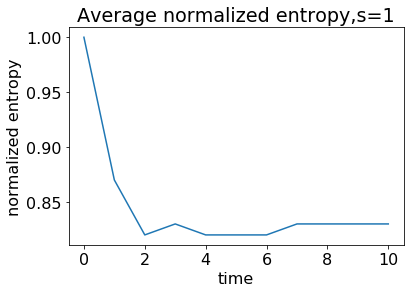

In [243]:
#multiple seed entropies
#'ground-truth' if based on simulations, dpact_prob_sim
length,iterations=1,10
size=len(NP.nodes)
seeds=reduce_seeds(dpmodules,dpsunit_map,dptranslator,length=length) #['()','(3,)']
#seeds=simulations.keys() #simulation entropies
print 'seeds:',len(seeds)
seed_entropy,seed_configs=seed_entropies(dpact_prob_sim,seeds,normalized=True,data=False) #dpmodules, submodules, dpact_prob_sim
xvalues=[t for t in range(iterations+1)]
yvalues=[np.mean([seed_entropy[seed][t] for seed in seed_entropy]) for t in xvalues]
print 'Average entropy:',[round(y * size,2) for y in yvalues]
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * size) for y in yvalues]
print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
plt.plot(xvalues,[round(yvalue/yvalues[0],2) for yvalue in yvalues])
#plt.ylim([.5,1.01])
plt.title("Average normalized entropy,s="+str(length))
plt.ylabel("normalized entropy")
plt.xlabel("time")

In [244]:
#our mf-estimate if dpmodules, simulations if dp_act_prob_sim
seed_entropy,seed_configs=seed_entropies(dpact_prob_sim,dpmodules.keys(),normalized=True,data=True)
sorted_entropies=sorted(seed_entropy,key=lambda x: seed_entropy[x][20])
len(sorted_entropies)

average entropy: [0.9522897205207015, 0.8302604996397089, 0.7822514742371113, 0.7894553525684102, 0.7853131026736279, 0.7825308110194863, 0.7852718947212214, 0.7870856472417584, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884, 0.7870809279608884]
average configurations: [0.09273739947441999, 0.007713115212239034, 0.0035083134779700298, 0.0035151879409767843, 0.0030908297939162797, 0.0028652789246386826, 0.0029888971317383693, 0.003119224581782915, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472, 0.003118063194183472]


49

Lowest: (7,) [0.95, 0.81, 0.69, 0.66, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63] ['Smo-1']
Highest: () [0.99, 0.88, 0.84, 0.85, 0.85, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86] []


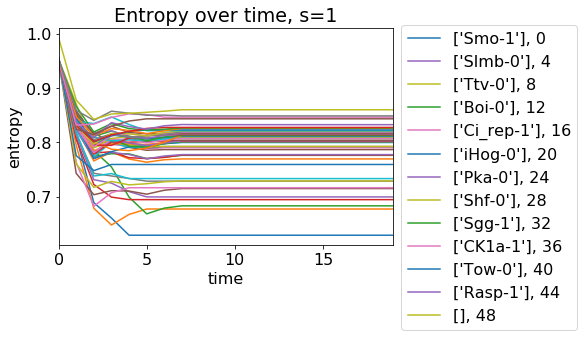

In [246]:
#graph s=1 length modules
iterations,length=20,1
print 'Lowest:',sorted_entropies[0],[round(seed_entropy[sorted_entropies[0]][t],2) for t in seed_entropy[sorted_entropies[0]]],
print to_list(sorted_entropies[0],dpsunit_map,dptranslator)
print 'Highest:',sorted_entropies[-1],[round(seed_entropy[sorted_entropies[-1]][t],2) for t in seed_entropy[sorted_entropies[-1]]],
print to_list(sorted_entropies[-1],dpsunit_map,dptranslator)
xvalues=range(iterations)
for index,seed in enumerate(sorted_entropies):
    if index%4==0:
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues],label=str(to_list(seed,dpsunit_map,dptranslator))+', '+str(index))
    #elif index%2==0: continue
    else:
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues])
plt.title("Entropy over time, s="+str(length))
plt.ylabel("entropy")
plt.xlabel("time")
plt.xlim([0,iterations-1])
plt.legend(bbox_to_anchor=(1.0, 1.05))

In [195]:
#check mean effective connectivity
bound="upper"
cana_data={}
for N in networks:
    size=len(N.nodes)
    max_k=max([len(node.inputs) for node in N.nodes])
    if max_k>9: 
        continue
    mean_eff=np.mean([n.effective_connectivity(mode='node',bound=bound,norm=True) for n in N.nodes])
    mean_sym=np.mean([n.input_symmetry(mode='node',bound=bound,norm=True) for n in N.nodes])
    cana_data[N.name]={'avg_eff': mean_eff,'avg_sym': mean_sym}
#for network in network_data: print network,network_data[network]['avg_eff']
#for node in B.nodes: 
#    print node.name,node.look_up_table(),np.sum([row[2] for row in look_up_table(node).itertuples()])/len(node.look_up_table())
cana_data

{'Apoptosis Network': {'avg_eff': 0.7798526422764227,
  'avg_sym': 0.18108485772357724},
 'Arabidopsis thaliana Cell Cycle': {'avg_eff': 0.42003115699404764,
  'avg_sym': 0.4002478078750102},
 'Aurora Kinase A in Neuroblastoma': {'avg_eff': 0.763176112836439,
  'avg_sym': 0.15031770679286205},
 'B bronchiseptica and T retortaeformis coinfection': {'avg_eff': 0.6307629471305032,
  'avg_sym': 0.47100590032101686},
 'B cell differentiation': {'avg_eff': 0.8096083603896105,
  'avg_sym': 0.08201514507318079},
 'BT474 Breast Cell Line Long-term ErbB Network': {'avg_eff': 0.5714166666666667,
  'avg_sym': 0.41416666666666674},
 'BT474 Breast Cell Line Short-term ErbB Network': {'avg_eff': 0.5353190104166666,
  'avg_sym': 0.5553146701388889},
 'Bordetella bronchiseptica': {'avg_eff': 0.6639993686868687,
  'avg_sym': 0.36045244107744107},
 'Bortezomib Responses in U266 Human Myeloma Cells': {'avg_eff': 0.7446517412935323,
  'avg_sym': 0.25942112354892205},
 'Budding Yeast Cell Cycle': {'avg_eff'

networks: 62
(0.2049083481528338, 0.11012807672314726)


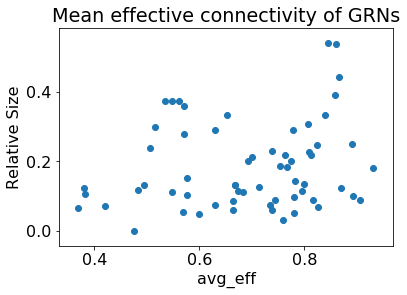

(-0.22024540488070987, 0.08541194982040706)


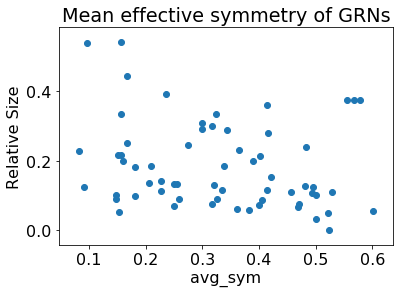

In [211]:
#graph against effective connectivity
from scipy.stats import pearsonr
stat='avg_eff'
subnetworks=[n for n in networks if n.name in cana_data and stat in cana_data[n.name]]
print "networks:",len(subnetworks)
xvalues=[cana_data[n.name][stat] for n in subnetworks]
yvalues=[cell_drivers[n.name]['size']/float(network_data[n.name]['size']) for n in subnetworks]
plt.scatter(xvalues,yvalues)
plt.title('Mean effective connectivity of GRNs')
#plt.ylim([-0.02,1.02])
#plt.xlim([0,125]) #one outlier of size 321
plt.ylabel('Relative Size')
plt.xlabel(stat)
print pearsonr(xvalues,yvalues)
plt.show()

stat='avg_sym'
subnetworks=[n for n in networks if n.name in cana_data and stat in cana_data[n.name]]
xvalues=[cana_data[n.name][stat] for n in subnetworks]
yvalues=[cell_drivers[n.name]['size']/float(network_data[n.name]['size']) for n in subnetworks]
plt.scatter(xvalues,yvalues)
plt.title('Mean effective symmetry of GRNs')
#plt.ylim([-0.02,1.02])
#plt.xlim([0,125]) #one outlier of size 321
plt.ylabel('Relative Size')
plt.xlabel(stat)
print pearsonr(xvalues,yvalues)

##### Comparison to previous results

In [53]:
#read in previous results
import csv
kernel_file="C:\\Users\\tjparmer\\Documents\\Dynamics\\20200820_control_kernel_supplemental_info.csv"
with open(kernel_file) as f:
    kernel_dict=csv.DictReader(f)
    control_kernels={row['name'].lower(): row for row in kernel_dict}
    #ck_attractors={key['name']: key['number of attractors'] for key in control_kernels}

print len(control_kernels) #'mean control kernel size'
#for n in sorted(network_data,key=lambda x: network_data[x]['size']): print n, network_data[n]['size']

49


In [54]:
#which networks do we have in common?

#fix discrepancies
control_kernels['iron acquisition and oxidative stress response in aspergillus fumigatus']=control_kernels['iron acquisition and oxidative stress response in aspergillus fumigatus.']
del control_kernels['iron acquisition and oxidative stress response in aspergillus fumigatus.']

#other discrepancy is because drosophila SPN is not in network_data
ND = DROSOPHILA()
size=len(ND.nodes)
max_k=max([len(node.inputs) for node in ND.nodes])
avg_k=np.mean([len(node.inputs) for node in ND.nodes])
avg_bias=np.mean([np.sum([row[2] for row in look_up_table(node).itertuples()])/len(node.look_up_table()) for node in ND.nodes])
network_data['Body Segmentation in Drosophila 2013']={'size': size,'max_k': max_k,'avg_k': avg_k,'avg_bias': avg_bias}
ND.name='Body Segmentation in Drosophila 2013'
networks.append(ND)
cell_drivers['Body Segmentation in Drosophila 2013']={'size': 3, 'time': None}

cell1=set([n.name.lower() for n in networks])
cell2=set([n.lower() for n in control_kernels])
cell2.remove("mammalian cell cycle 2006") #error with the number of attractors
print 'Common:',len(cell1.intersection(cell2))
for n in sorted(cell2-cell1): #,key=lambda x: control_kernels[x]['size']):
    print n.strip(), control_kernels[n]['size']

Common: 48


48 48


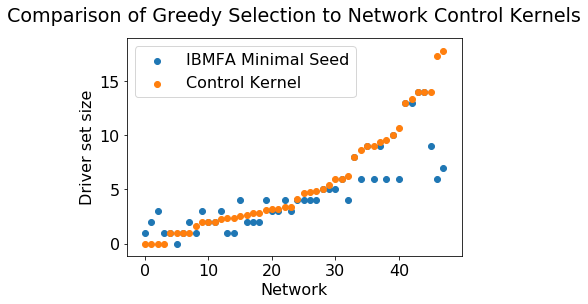

In [55]:
#compare mean control kernel size to our minimal driver set size
xvalues=range(len(cell2))
#sort networks for better visualization
network_list=[n.name for n in networks if n.name.lower() in cell2]
sorted_networks=sorted(network_list,key=lambda x: float(control_kernels[x.lower()]['mean control kernel size']))
#for n in sorted_networks: print n,control_kernels[n.lower()]['mean control kernel size']
yvalues1=[cell_drivers[n]['size'] for n in sorted_networks]
yvalues2=[float(control_kernels[n.lower()]['mean control kernel size']) for n in sorted_networks]
print len(yvalues1),len(yvalues2)

plt.scatter(xvalues,yvalues1,label='IBMFA Minimal Seed')
plt.scatter(xvalues,yvalues2,label='Control Kernel')
#plt.ylim([0,3.5])
plt.title("Comparison of Greedy Selection to Network Control Kernels", y=1.05)
plt.ylabel("Driver set size")
plt.xlabel("Network")
plt.legend()

In [56]:
#where our our mistakes?
mistakes=[]
for i in range(len(yvalues1)):
    if yvalues1[i]>yvalues2[i]: #this should not be the case because we give a lower bound
        mistakes.append(sorted_networks[i])
print len(mistakes)#,mistakes
for n in mistakes:
    print control_kernels[n.lower()]['name'],control_kernels[n.lower()]['size'],control_kernels[n.lower()]['number of attractors'],
    print control_kernels[n.lower()]['mean control kernel size'],cell_drivers[n]['size']

10
Arabidopsis Thaliana Cell Cycle 14 1 0.0 1
Budding Yeast Cell Cycle 2009 18 1 0.0 2
FA BRCA Pathway 28 1 0.0 3
Fanconi Anemia And Checkpoint Recovery 15 1 0.0 1
Pc12 Cell Differentiation 62 2 1.0 2
Iron Acquisition And Oxidative Stress Response In Aspergillus Fumigatus. 22 4 2.0 3
Cholesterol Regulatory Pathway 34 21 2.25 3
Pro-inflammatory Tumor Microenvironment In Acute Lymphoblastic Leukemia 26 6 2.5 4
T-Cell Signaling 2006 40 10 3.142857142857143 4
Tumour Cell Invasion And Migration 32 15 3.3333333333333335 4


In [57]:
#confirm number of attractors for small networks
name='Cortical Area Development' #two fixed points
name='Cell Cycle Transcription By Coupled CDK And Network Oscillators' #one fixed point and one limit cycle (size 5)
#name='Mammalian Cell Cycle 2006' #former results indicate one limit cycle, but we (CANA agrees) find one limit cycle (size 7) and one fixed point
name='Toll Pathway Of Drosophila Signaling Pathway' #four fixed points
name='Metabolic Interactions In The Gut Microbiome' #40 fixed points
name='Regulation Of The L-arabinose Operon Of Escherichia Coli' #17 fixed points, 4 limit cycles (size 2-4)
name='Lac Operon' #9 fixed points
#name='Arabidopsis Thaliana Cell Cycle' #one limit cycle (size 11)
name='Predicting Variabilities In Cardiac Gene' #6 fixed points
name='Cardiac Development' #6 fixed points
name='Fanconi Anemia And Checkpoint Recovery' #one limit cycle (size 2)
name='BT474 Breast Cell Line Short-term ErbB Network' #253 fixed points
name='SKBR3 Breast Cell Line Short-term ErbB Network' #702 fixed points
name='Neurotransmitter Signaling Pathway' #two fixed points, two limit cycles
name='HCC1954 Breast Cell Line Short-term ErbB Network' #274 fixed points
#name='Body Segmentation In Drosophila 2013' #10 fixed points
name='Vegf Pathway Of Drosophila Signaling Pathway' #256 fixed points
name='CD4+ T Cell Differentiation And Plasticity' #294 fixed points, 30 limit cycles
name='Budding Yeast Cell Cycle 2009' #one limit cycle (size 11)
name='T-LGL Survival Network 2011 Reduced Network' #one fixed point, two limit cycles (size 4)
#name='Human Gonadal Sex Determination' #three fixed points
#name='Oxidative Stress Pathway' #one fixed point, one limit cycle (size 9)
name='Mammalian Cell Cycle' #three fixed points (my method: 7 min, 2% mem; cana: 3 min, 20% mem)
name='Budding Yeast Cell Cycle' #20 fixed points, 13 limit cycles (sizes 2-11)
name='B Cell Differentiation'#58 fixed points, 3 limit cycles of length 2 (my method: 25 min, 8% mem; cana: 11 min, 73% mem)
#name='Iron Acquisition And Oxidative Stress Response In Aspergillus Fumigatus' #4 limit cycles of length 2 or 9, takes a lot of memory!
name='FGF Pathway Of Drosophila Signalling Pathways' #512 fixed points
name='T Cell Differentiation' #33 fixed points
name='TOL Regulatory Network' #1024 fixed points
name='Processing Of Spz Network From The Drosophila Signaling Pathway' #64 fixed points
name='HH Pathway Of Drosophila Signaling Pathways' #8192 fixed points
name='BT474 Breast Cell Line Long-term ErbB Network' #3344 fixed points
name='SKBR3 Breast Cell Line Long-term ErbB Network' #3185 fixed points
name='HCC1954 Breast Cell Line Long-term ErbB Network' #9452 fixed points
name='Trichostrongylus Retortaeformis' #6 fixed points, 6 limit cycles
name='Pro-inflammatory Tumor Microenvironment In Acute Lymphoblastic Leukemia' #2 fixed points, 4 limit cycles
name='Wg Pathway Of Drosophila Signalling Pathways' #13056 fixed points, 3328 limit cycles
name='Death Receptor Signaling' #27 fixed points, 70 limit cycles
#name='FA BRCA Pathway' #one limit cycle
name='Septation Initiation Network' #640 fixed points, 1600 limit cycles
name='Tumour Cell Invasion And Migration' #9 fixed points, 6 limit cycles
name='Lymphoid And Myeloid Cell Specification And Transdifferentiation' #20 fixed points
name='Bordetella Bronchiseptica' #3 fixed points, one limit cycle
name='Cholesterol Regulatory Pathway' #4 fixed points, 17 limit cycles
name='T-Cell Signaling 2006' #7 fixed points, 3 limit cycles
name='Treatment Of Castration-Resistant Prostate Cancer' #16384 fixed points
name='Guard Cell Abscisic Acid Signaling' #11 fixed points, 84 limit cycles
name='Pc12 Cell Differentiation' #2 fixed points
name='Yeast Apoptosis' #8448 fixed points, 3072 limit cycles
for n in networks:
    if n.name.lower()==name.lower(): break

dd={node.name: LUT_reduce(look_up_table(node)) for node in n.nodes}
dnodes=dd.keys()
print len(dd),dnodes
dmodules,dtranslator={},{'()':()}
dsunits,dsunit_map=get_sunits(n)
dtranslator=create_translator(n,1,dsunits,dsunit_map,dtranslator)
print len(dsunits),dsunit_map
#DCMP=n.dynamics_canalization_map(output=None, )
#fixed_points=find_attractors_bruteforce(n,None,dsunits,dsunit_map,{},{},time_limit=25,verbose=True)

73 ['H2B', 'SDP1', 'PTP2', 'PTP3', 'KAP123', 'MDV1', 'TOR1', 'NUC1-NUC', 'SNO1', 'STM1-CYT', 'Tat-D', 'AIF1-MT', 'AbnormalTelomer', 'MMI1', 'MSN2-4', 'CPR3', 'RAS2', 'RPD3', 'STM1-NUC', 'SLT2', 'MCD1-MT', 'MT-Frag', 'RedActinDyn', 'Adozelesin', 'CU2', 'Apoptosis', 'CAMP', 'Heat', 'AceticAcid', 'AIF1-NUC', 'NMA111-CYT', 'PKA', 'Protosom', 'AdenylateCyclase', 'HK', 'FVY10', 'NDI1', 'HOS3', 'NMA111-NUC', 'Stress', 'MT-ALT', 'SOD2', 'DesCyclinCCDK8', 'SOD1', 'BIR1', 'STE20-NUC', 'CytC-CYT', 'Mating', 'STE20-CYT', 'Salt', 'CDC6', 'CytC-MT', 'ESP1', 'SRO7', 'MEC1', 'RLM1', 'H2O2', 'DRE2_TAH18', 'ROS-CYT', 'MG2', 'NUC1-MT', 'MAPK', 'HOG1-Dep', 'FIS1', 'HOG1', 'DNA-Frag', 'CDC48', 'MCD1-NUC', 'ROS-MT', 'SVF1', 'POR1-2', 'YCA1', 'EMC4']
146 {0: 'STE20-CYT-0', 1: 'STE20-CYT-1', 2: 'RAS2-0', 3: 'RAS2-1', 4: 'Protosom-0', 5: 'Protosom-1', 6: 'HOS3-0', 7: 'HOS3-1', 8: 'DRE2_TAH18-0', 9: 'DRE2_TAH18-1', 10: 'CDC6-0', 11: 'CDC6-1', 12: 'AIF1-MT-0', 13: 'AIF1-MT-1', 14: 'MT-Frag-0', 15: 'MT-Frag-1', 1

In [257]:
#print len(fixed_points)#,[fixed_points[x] for x in fixed_points],sum([fixed_points[x] for x in fixed_points]),fixed_points
#network_dynamics(config,{},time_limit=10)
#dattractors=attractors_to_dict(n)
#for x in fixed_points:
#    found=False
#    for a in attractors:
#        if x==attractors[a]: 
#            found=True
#    if not found: print x
#print attractors_to_dict(n)
#print n.attractors()
#for attractor in dattractors: print attractor,len(dattractors[attractor])
#dattractors.keys(),len(dattractors)

In [247]:
#json dump cell collective data - issue with set
#with open('attractors/'+n.name+'.json', 'w') as fp:
#    json.dump(dattractors, fp)
#dattractors
#del n._stg #free up memory!

In [58]:
#read in attractors
name='B cell differentiation'
#name='Iron acquisition and oxidative stress response in aspergillus fumigatus'
#with open('attractors/'+name+'.json') as fp:
#    dattractors=eval(fp.read())
pathname="C:\\Users\\tjparmer\\Documents\\Dynamics\\control_kernel_code\\control_kernel_code\\attractors\\"
name='Yeast Apoptosis'
with open(pathname+name+'.json') as fp:
    dattractors=eval(fp.read()) #dattractors2
len(dattractors)

11520

In [255]:
#check file dictionary against calculated reference dictionary
set1=set(dattractors.keys())
set2=set(dattractors2.keys())
print "Intersection:",len(set1.intersection(set2)) #check if node ordering is different or not
print "Attractors only in dattractors:",len(set1-set2)
print "Attractors only in dattractors2:",len(set2-set1)
print "Sizes:",len(dattractors),len(dattractors2)
set3=set([]) #attractors in dattractors2 that we have found
for attractor in dattractors: #if sizes are the same, we only need to check one dictionary
    if type(attractor)==tuple: #limit cycle
        sunits=dattractors[attractor][0] #we only have to check one state to ensure it's referencing the same attractor
    else: 
        sunits=dattractors[attractor]
    found=False 
    for attractor2 in dattractors2:
        if type(attractor2)==tuple: #limit cycle
            for config in dattractors2[attractor2]:
                if config==sunits: 
                    print "found limit cycle"
                    found=True
                    set3.add(attractor2)
                    break
        else: #fixed point
            if dattractors2[attractor2]==sunits: 
                #print "found fixed point"
                found=True
                set3.add(attractor2)
                continue
    if not found: #we have a discrepancy
        print "Attractor not found:",attractor,sunits
        #break

Intersection: 0
Attractors only in dattractors: 61
Attractors only in dattractors2: 61
Sizes: 61 61
found limit cycle
found limit cycle
found limit cycle


In [262]:
#check any discrepancies
for attractor2 in set2-set3: 
    #print attractor2,dattractors2[attractor2]
    if type(dattractors2[attractor2])==list: #limit cycle
        config=dattractors2[attractor2][0]
    else:
        config=dattractors2[attractor2]
config=sunits #to check dattractors attractor
#translate set to list of indices
rmap=reverse_sunit_map(dsunit_map)
#config=[rmap[s] for s in config]
#configs=exponential_configs(n,dsunits,dsunit_map,{},{})
print sunits
#config=translate_config_to_vars(config,n,dsunit_map)
#diffusion2=network_dynamics(config,{},time_limit=25)
#print diffusion[13]
#print diffusion2[14]
#print diffusion[15]
print attractor_length(diffusion2)

set(['XBP1-0', 'Pax5-1', 'CD40L-1', 'Bach2-1', 'CD40-1', 'IL-21-0', 'IL-4R-0', 'BCR-0', 'STAT3-0', 'ERK-0', 'IL-21R-0', 'IL-2R-0', 'STAT6-0', 'Blimp1-0', 'Irf4-1', 'Bcl6-0', 'NF-kB-1', 'AID-1', 'IL-4-0', 'IL-2-0', 'Ag-0', 'STAT5-0'])
1


In [166]:
#NOTE: both diffusions result in our missing attractor!
#the previous method is using a transient state to label its attractor; hopefully this only applies to Aspergillus
#however, if these are only limit cycles, we can ignore them as our method focuses only on fixed points
#print diffusion[13]
print diffusion[19]
#print diffusion2[13]
print diffusion2[25]

set(['E2Fc-1', 'RBR-1', 'CYCA2;3-0', 'E2Fa-0', 'CYCD3;1-0', 'E2Fb-0', 'MYB77-0', 'KRP1-0', 'CDKB1;1-1', 'MYB3R1/4-1', 'APC/C-1', 'E2Fe-0', 'SCF-0', 'CYCB1;1-0'])
set(['E2Fc-1', 'RBR-1', 'CYCA2;3-0', 'E2Fa-0', 'CYCD3;1-0', 'E2Fb-0', 'MYB77-0', 'KRP1-0', 'CDKB1;1-1', 'MYB3R1/4-1', 'APC/C-1', 'E2Fe-0', 'SCF-0', 'CYCB1;1-0'])


In [842]:
#attractors={}
attractors[name]=fixed_points
print attractors.keys(),drivers.keys()
#name='Cortical Area Development' #verified this should be 1, but we mistakenly predict 0 (for 10 iterations, can reduce)
#name='Cell Cycle Transcription by Coupled CDK and Network Oscillators' #we correctly predict fixed point control of size 1 (limit cycle uncontrollable)
#name='Mammalian Cell Cycle 2006' #we correctly predict fixed point control of size 1, but cannot predict control of limit cycle
#cell_drivers[name]['size']

['Regulation Of The L-arabinose Operon Of Escherichia Coli', 'Mammalian Cell Cycle 2006', 'Cell Cycle Transcription By Coupled CDK And Network Oscillators', 'Cortical Area Development', 'Metabolic Interactions In The Gut Microbiome', 'Toll Pathway Of Drosophila Signaling Pathway'] ['Cortical Area Development']


In [1]:
#drivers for all networks with previously known control kernels
#NOTE: if actual is None, this indicates that it was not calculated due to computational expense
drivers={'Cortical Area Development': {'actual':1.0,'greedy':1.0,'kernel':1.0}, #greedy solution requires T=9 iterations
        'Cell Cycle Transcription By Coupled CDK And Network Oscillators': {'actual':1.0,'greedy':1.0,'kernel':1.0}, #1 limit cycle uncontrollable
        #'Mammalian Cell Cycle 2006': {'actual':1.0,'greedy':2.0,'kernel':0.0}, #greedy solution not found for one limit cycle
        'Toll Pathway Of Drosophila Signaling Pathway': {'actual':2.0,'greedy':2.0,'kernel':2.0},
         'Metabolic Interactions In The Gut Microbiome': {'actual':6.2,'greedy':6.0,'kernel':6.2},
         'Regulation Of The L-arabinose Operon Of Escherichia Coli': {'actual':4.117647058823529,'greedy':4.117647058823529,'kernel':4.11764705882352}, #4 limit cycles uncontrollable
         'Lac Operon': {'actual':3.2222222222222223,'greedy':3.2222222222222223,'kernel':3.22222222222222},
         #'Arabidopsis Thaliana Cell Cycle': {'actual':0.0,'greedy':None,'kernel':0.0}, #greedy solution not found for one limit cycle
         'Predicting Variabilities In Cardiac Gene': {'actual':2.8333333333333335,'greedy':2.6666666666666665,'kernel':2.83333333333333},
         'Cardiac Development': {'actual':2.8333333333333335,'greedy':2.6666666666666665,'kernel':2.83333333333333},
         #'Fanconi Anemia And Checkpoint Recovery': {'actual':0.0,'greedy':None,'kernel':0.0}, #greedy solution not found for one limit cycle
         'BT474 Breast Cell Line Short-term ErbB Network': {'actual':None,'greedy':9.541501976284586,'kernel':9.54150197628458}, #greedy solution requires T=4 iterations
         'SKBR3 Breast Cell Line Short-term ErbB Network': {'actual':None,'greedy':10.68945868945869,'kernel':10.7037037037037}, #greedy solution requires T=4 iterations
         'Neurotransmitter Signaling Pathway': {'actual':2.0,'greedy':2.0,'kernel':2.0}, #greedy solution not found for two limit cycles
         'HCC1954 Breast Cell Line Short-term ErbB Network': {'actual':None,'greedy':9.007299270072993,'kernel':9.02189781021897}, #greedy solution requires T=4 iterations
         'Body Segmentation In Drosophila 2013': {'actual':3.4,'greedy':3.7,'kernel':3.4},
         'Vegf Pathway Of Drosophila Signaling Pathway': {'actual':8.0,'greedy':8.0,'kernel':8.0},
         'CD4+ T Cell Differentiation And Plasticity': {'actual':None,'greedy':8.625850340136054,'kernel':8.60204081632653}, #30 limit cycles uncontrollable
         #'Budding Yeast Cell Cycle 2009': {'actual':0.0,'greedy':None,'kernel':0.0}, #greedy solution not found for one limit cycle
         #'T-LGL Survival Network 2011 Reduced Network': {'actual':None,'greedy':1.0,'kernel':2.33333333333333}, #greedy solution not found for two limit cycles
         'T-LGL Survival Network 2011 Reduced Network': {'actual':None,'greedy':1.0,'kernel':1.0}, #considering only 1 fixed point
         'Human Gonadal Sex Determination': {'actual':None,'greedy':2.0,'kernel':2.33333333333333},
         'Oxidative Stress Pathway': {'actual':1.0,'greedy':1.0,'kernel':1.0}, #greedy solution not found for one limit cycle
         'Mammalian Cell Cycle': {'actual':None,'greedy':2.0,'kernel':1.66666666666666},
         #'Budding Yeast Cell Cycle': {'actual':None,'greedy':4.95,'kernel':4.8095238095238}, #greedy solution not found for one limit cycle, 12 limit cycles uncontrollable
         'Budding Yeast Cell Cycle': {'actual':None,'greedy':4.95,'kernel':4.85}, #considering only 20 fixed points
         'B Cell Differentiation': {'actual':None,'greedy':5.913793103448276,'kernel':5.91379310344827},
         #'Iron Acquisition And Oxidative Stress Response In Aspergillus Fumigatus': {'actual':None,'greedy':None,'kernel':2.0}, #greedy solution not found for four limit cycles
         'FGF Pathway Of Drosophila Signalling Pathways': {'actual':None,'greedy':9.0,'kernel':9.0},
         'T Cell Differentiation': {'actual':None,'greedy':5.03030303030303,'kernel':5.03030303030303},
         'TOL Regulatory Network': {'actual':None,'greedy':10.0,'kernel':10.0},
         'Processing Of Spz Network From The Drosophila Signaling Pathway': {'actual':None,'greedy':6.0,'kernel':6.0},
         'HH Pathway Of Drosophila Signaling Pathways': {'actual':None,'greedy':13.0,'kernel':13.0},
         'BT474 Breast Cell Line Long-term ErbB Network': {'actual':None,'greedy':14.078349282296651,'kernel':14.0185406698564},
         'SKBR3 Breast Cell Line Long-term ErbB Network': {'actual':None,'greedy':17.42951334379906,'kernel':17.3158555729984},
         'HCC1954 Breast Cell Line Long-term ErbB Network': {'actual':None,'greedy':17.713393990689802,'kernel':17.8027930596699}, #greedy solution requires T=6 iterations
         'Trichostrongylus Retortaeformis': {'actual':None,'greedy':3.6666666666666665,'kernel':3.16666666666666}, #6 limit cycles uncontrollable
         #'Pro-inflammatory Tumor Microenvironment In Acute Lymphoblastic Leukemia': {'actual':None,'greedy':3.5,'kernel':2.5}, #greedy solution not found for two limit cycles, 2 limit cycles uncontrollable
         'Pro-inflammatory Tumor Microenvironment In Acute Lymphoblastic Leukemia': {'actual':None,'greedy':3.5,'kernel':3.0}, #considering only 2 fixed points
         'Wg Pathway Of Drosophila Signalling Pathways': {'actual':None,'greedy':14.0,'kernel':14.0}, #greedy solution not found for 3328 limit cycles
         'Death Receptor Signaling': {'actual':None,'greedy':4.925925925925926,'kernel':4.74074074074074}, #70 limit cycles uncontrollable
         #'FA BRCA Pathway': {'actual':None,'greedy':None,'kernel':0.0}, #greedy solution not found for one limit cycle
         'Septation Initiation Network': {'actual':None,'greedy':9.4,'kernel':9.4}, #1600 limit cycles uncontrollable
         'Tumour Cell Invasion And Migration': {'actual':None,'greedy':3.6666666666666665,'kernel':3.33333333333333}, #6 limit cycles uncontrollable
         'Lymphoid And Myeloid Cell Specification And Transdifferentiation': {'actual':None,'greedy':4.65,'kernel':4.7},
         'Bordetella Bronchiseptica': {'actual':None,'greedy':2.6666666666666665,'kernel':2.66666666666666}, #one limit cycle uncontrollable
         'Cholesterol Regulatory Pathway': {'actual':None,'greedy':3.25,'kernel':2.25}, #17 limit cycles uncontrollable
         'T-Cell Signaling 2006': {'actual':None,'greedy':4.0,'kernel':3.14285714285714}, #3 limit cycles uncontrollable
         'Treatment Of Castration-Resistant Prostate Cancer': {'actual':None,'greedy':14.0,'kernel':14.0},
         #'Guard Cell Abscisic Acid Signaling': {'actual':None,'greedy':5.909090909090909,'kernel':5.42105263157894}, #greedy solution not found for 27 limit cycles, 57 limit cycles uncontrollable
         'Guard Cell Abscisic Acid Signaling': {'actual':None,'greedy':5.909090909090909,'kernel':5.636363636363637}, #considering only 11 fixed points
         'Pc12 Cell Differentiation': {'actual':None,'greedy':2.5,'kernel':1.0},
         'Yeast Apoptosis': {'actual':None,'greedy':13.575757575757576,'kernel':13.3333333333333}, #3072 limit cycles uncontrollable
        }

In [64]:
#check control in small networks (actual solution)
start_time = time.time()
solutions={}
input_units=[get_variable_map(n,dsunit_map)[x.name][i] for x in network_inputs(n) for i in (0,1)] #works for binary inputs
num=5
nodes=[str((x,)) for x in dsunits] #yfvs, [str((x,)) for x in dsunits]
nodes=[str((x,)) for x in input_units] #input node subset
seeds=combinations(nodes,num)
for seed in seeds:
    seed=[dtranslator[s][0] for s in sorted(list(seed))] #extract number from tuple
    #quick check for contradiction
    vals=[dsunit_map[x][:-2] for x in seed]
    if len(set(vals))<len(vals): #we have multiple nodes sharing the same variable
        continue
    inputs=[node.name in vals for node in network_inputs(n)]
    if sum(inputs)<len(inputs): continue #solution must contain all input nodes
    #print seed,vals
    fixed_points=find_attractors_bruteforce(n,None,dsunits,dsunit_map,seed,{},time_limit=26)
    #print {len(x) for x in fixed_points},len(fixed_points),fixed_points
    if len(fixed_points)==1: 
        #print seed,vals,{len(x) for x in fixed_points},len(fixed_points)
        for i,a in enumerate(dattractors):
            if list(fixed_points)[0]==dattractors[a] or list(fixed_points)[0] in dattractors[a]: #check for fixed point or limit cycle
                print seed,vals,{len(x) for x in fixed_points},len(fixed_points)
                print "Attractor found:",i,a,[fixed_points[x] for x in fixed_points]
                if not a in solutions or solutions[a]>num: solutions[a]=num
print("--- Total time: %s seconds ---" % (time.time()-start_time))

[34, 36, 38, 41, 42] ['CD40L', 'IL-21', 'IL-2', 'Ag', 'IL-4'] set([22]) 1
Attractor found: 26 0001000000110001100010 [131072]
[34, 36, 38, 41, 43] ['CD40L', 'IL-21', 'IL-2', 'Ag', 'IL-4'] set([22]) 1
Attractor found: 1 1001000000110101100011 [131072]
[34, 36, 39, 41, 42] ['CD40L', 'IL-21', 'IL-2', 'Ag', 'IL-4'] set([22]) 1
Attractor found: 55 0001100000111001100110 [131072]
[34, 36, 39, 41, 43] ['CD40L', 'IL-21', 'IL-2', 'Ag', 'IL-4'] set([22]) 1
Attractor found: 56 1001100000111101100111 [131072]
[34, 37, 38, 41, 42] ['CD40L', 'IL-21', 'IL-2', 'Ag', 'IL-4'] set([22]) 1
Attractor found: 60 0101001000110001101010 [131072]
[34, 37, 38, 41, 43] ['CD40L', 'IL-21', 'IL-2', 'Ag', 'IL-4'] set([22]) 1
Attractor found: 30 1101001000110101101011 [131072]
[34, 37, 39, 41, 42] ['CD40L', 'IL-21', 'IL-2', 'Ag', 'IL-4'] set([22]) 1
Attractor found: 52 0101101000111001101110 [131072]
[34, 37, 39, 41, 43] ['CD40L', 'IL-21', 'IL-2', 'Ag', 'IL-4'] set([22]) 1
Attractor found: 23 1101101000111101101111 [1

In [59]:
#compare to greedy solution for each attractor
start_time = time.time()
iterations=10
t=iterations
gsolutions={}
for i,attractor in enumerate(dattractors):
    if i<8001: continue
    print i, attractor
    if type(attractor)==tuple: #automatic skip for limit cycles
        print None
        continue
    start_seed=determine_attractor_inputs(n,dsunit_map,attractor,dattractors)
    #print start_seed
    selection=driver_selection(n,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=30,top=1,reduced=True,ds=dd,t=t,
        attractor=attractor,attractors=dattractors,pin_start=True,force=True,iterations=iterations,names='string',start_seed=start_seed)
    if selection: 
        print selection, to_list(selection,dsunit_map,dtranslator)
        gsolutions[attractor]=len(selection)
    else: print None
print("--- Total time: %s seconds ---" % (time.time()-start_time))

8001 ('1100010101100011000001110010011011000010011010001011010100001000100100110', '1100000000100010000001010010111011000010011010001011010101001000100100110')
None
8002 1111001110101110111111101111001101111101111011111101111101111010001001101
(102, 120, 122, 124, 127, 129, 130, 133, 135, 137, 138, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8003 1101001110100100101111111111001001111100110001101001111111110011011010110
(102, 120, 123, 124, 126, 129, 130, 133, 134, 137, 139, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8004 1100010100110011000001110010111011000010011110001011010101001100000000110
(120, 122, 124, 126, 128, 131, 132, 135, 137, 138, 140, 143, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'H

(120, 123, 124, 127, 128, 131, 133, 135, 137, 139, 140, 142, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
8031 ('1111010111101111110110101101010111111111111011111111110100111011100001001', '1111000010101110110110001101110111111111111011111111110101111011100001001')
None
8032 0000000100000010000001100010001011000000001010011000010101001001010000101
(14, 102, 120, 123, 124, 127, 128, 130, 132, 135, 137, 138, 141, 142, 144) ['MT-Frag-0', 'HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8033 1100001100100000001000100000010000010110011000001011011101000000101010000
(102, 120, 122, 125, 126, 128, 130, 133, 134, 136, 139, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'Aceti

(121, 122, 125, 127, 128, 131, 132, 134, 136, 139, 141, 143, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8060 ('0101010111000101100110111101000011111100111001111000110110110011010110011', '0101000010000100100110011101100011111100111001111000110111110011010110011')
None
8061 1101011110110111101111101111111001111110111111101011111101111111111110100
(121, 123, 125, 126, 129, 131, 133, 135, 137, 139, 141, 142, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8062 1100000100100010000001110010011011000010011010011011010101001001110100111
(102, 121, 123, 125, 127, 128, 130, 132, 135, 137, 138, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTel

(121, 122, 124, 126, 129, 131, 133, 135, 136, 139, 141, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8090 ('0000010101000001000000110000000010010100001000001000010100000000010010010', '0000000000000000000000010000100010010100001000001000010101000000010010010')
None
8091 1101001110100110101110101101010001111110111011111011111101111011111010001
(102, 120, 123, 125, 127, 129, 130, 133, 135, 136, 139, 141, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8092 1101010110110111100110111101110011111110111111111011110101111110110010011
(120, 122, 125, 127, 129, 131, 132, 135, 136, 139, 141, 143, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTel

(120, 123, 125, 127, 128, 131, 132, 135, 137, 139, 141, 142, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8121 1101001110100110101110111101010001111110111011111011111101111010111100011
(102, 121, 122, 125, 127, 129, 130, 133, 135, 136, 138, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8122 1110001100101000011000110000000101000001011000001101011101000000011001010
(102, 120, 122, 124, 126, 128, 130, 133, 134, 136, 138, 141, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
8123 ('1111010111101111110111101111011111111111111011111111110100111011100111101', '11110000101011101101110011111111111111111110111

(121, 122, 124, 126, 129, 131, 132, 135, 137, 138, 140, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8150 1101000110100110100111111111011011111110111011101011110101111011110010110
(102, 120, 123, 125, 126, 129, 130, 132, 135, 137, 139, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8151 1110010100111011010000100000110111000011011110001111010101001101100001000
(120, 123, 125, 126, 128, 131, 132, 135, 136, 138, 140, 142, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8152 ('1101010111100101100110111101010011111110111001111011110110110011100110011', '11010000101001001001100111011100111111101110011110111101111100

(120, 123, 124, 127, 129, 131, 133, 134, 136, 138, 140, 143, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
8182 1100010100110011000001100010111011010110011110011011010101001100000110101
(121, 122, 124, 127, 128, 131, 132, 135, 137, 139, 140, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
8183 ('1111010111101101110110111101010111111111111001111111110110110011110111011', '1111000010101100110110011101110111111111111001111111110111110011110111011')
None
8184 1100011100110011001000110000110001010110011110001011011101001100101110010
(121, 122, 125, 126, 128, 131, 133, 135, 136, 139, 140, 143, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-

(102, 120, 122, 124, 127, 128, 130, 133, 135, 137, 138, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8211 0101000110000110100111111111001011111100111011111000110101111010010000111
(102, 120, 122, 124, 127, 129, 130, 132, 135, 137, 138, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8212 0101000110000110100110101101000011111100111011111000110101111010010010001
(102, 120, 122, 124, 127, 129, 130, 132, 135, 136, 139, 141, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8213 0110000100001000010001100010001111000001011000001100010101000001010001100
(102, 120, 123, 124, 126, 128, 130, 1

(102, 120, 123, 124, 127, 129, 130, 133, 135, 137, 139, 141, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8242 1111000110101110110111111111011111111111111011101111110101111010110011110
(102, 120, 122, 125, 126, 129, 130, 132, 135, 137, 139, 141, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
8243 1101001110100100101111111111001001111100110001101001111111110010001100110
(102, 121, 122, 124, 126, 129, 130, 133, 134, 137, 138, 140, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
8244 1101011110110101101111111111111001111110111101111011111111110110111010111
(120, 122, 125, 127, 129, 131, 133, 1

(102, 121, 123, 125, 127, 129, 130, 132, 135, 137, 138, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
8271 1100010100110001000000100000110011000010011100011011010101000101000000001
(120, 123, 124, 127, 128, 131, 132, 134, 136, 138, 140, 142, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
8272 0101000110000100100110111101000011111100111001111000110111110011010010011
(102, 120, 123, 124, 127, 129, 130, 132, 134, 136, 139, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8273 0111000110001110110110101101000111111101111011111100110101111010000011001
(102, 120, 122, 124, 127, 129, 130, 132, 135, 136, 1

(121, 122, 125, 127, 128, 131, 132, 134, 137, 139, 141, 143, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8301 0000000100000000000000100000000010000000001000010000000101000001000100001
(14, 102, 121, 123, 124, 127, 128, 130, 132, 134, 136, 138, 140, 142, 144) ['MT-Frag-0', 'HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
8302 1100001100100010001001100010001001010100011010011001011101001000001110101
(102, 121, 122, 124, 127, 128, 130, 133, 135, 137, 139, 140, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
8303 ('0111010111001111110111111111001111111101111011111100110100111010000001111', '011100001000111011011101111110

(120, 123, 125, 126, 128, 131, 132, 134, 136, 139, 141, 143, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8335 ('1100010101100011000001100010011011000010011010011011010100001000100100101', '1100000000100010000001000010111011000010011010011011010101001000100100101')
None
8336 ('1100010101100001000001110010011011000010011000001011010100000001110100110', '1100000000100000000001010010111011000010011000001011010101000001110100110')
None
8337 1100000100100010000001100010011011010110011010011011010101001000110010101
(102, 120, 122, 125, 127, 128, 130, 132, 135, 137, 139, 141, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8338 1100011100110001001001110010111001000010011100001011011101000100011000110
(120, 122, 124, 126, 128, 131, 133, 134, 13

(102, 120, 122, 124, 127, 129, 130, 133, 134, 136, 139, 140, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
8369 0100000100000000000000100000000010010100011000001000010101000000000010000
(15, 102, 120, 122, 124, 126, 128, 130, 132, 134, 136, 139, 140, 142, 144) ['MT-Frag-1', 'HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
8370 0101000110000100100110101101000011111100110001101000110111110011000010000
(102, 120, 123, 124, 126, 129, 130, 132, 134, 136, 139, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
8371 0110000100001010010000100000000111010101011010001100010101001000000111000
(102, 121, 122, 124,

(102, 121, 122, 124, 127, 129, 130, 132, 134, 137, 139, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8399 1110011100111001011000100000110101010111011100001111011101000101001111000
(121, 123, 124, 126, 128, 131, 133, 134, 136, 139, 140, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8400 ('0111010111001111110110101101000111111101111011111100110100111010000101001', '0111000010001110110110001101100111111101111011111100110101111010000101001')
None
8401 1100000100100010000000100000010010010110011010011011010101001000110110001
(102, 121, 122, 125, 127, 128, 130, 132, 135, 136, 139, 141, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1

(121, 123, 125, 126, 129, 131, 132, 134, 137, 138, 141, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
8428 1111001110101100111110101101000101111101111001111101111111110010011011001
(102, 120, 122, 124, 127, 129, 130, 133, 134, 136, 139, 141, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
8429 1101001110100100101110101101000001111100111001111001111111110011001100001
(102, 121, 123, 124, 127, 129, 130, 133, 134, 136, 138, 140, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
8430 1110010100111011010000100000110111010111011110001111010101001101100111000
(121, 123, 125, 126, 128, 131, 132, 135, 136, 139, 1

(15, 102, 121, 122, 124, 126, 128, 130, 132, 135, 136, 139, 140, 143, 144) ['MT-Frag-1', 'HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
8459 1101001110100110101110111101010001111110111011101011111101111011111010010
(102, 120, 123, 125, 126, 129, 130, 133, 135, 136, 139, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8460 1101010110110101100111111111111011111110111101111011110111110111100000111
(120, 123, 125, 127, 129, 131, 132, 134, 137, 138, 140, 143, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
8461 ('0000000000000010000000010000100010000000011010001000010101001000000100010', '010001010100001100000011000000

(102, 120, 123, 125, 126, 129, 130, 132, 135, 136, 138, 140, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
8491 1100011100110001001001110010111001010110011100011011011101000101001110111
(121, 123, 124, 127, 128, 131, 133, 134, 137, 139, 140, 143, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
8492 1100001100100000001000100000010000000010011000011011011101000001111100001
(102, 121, 123, 125, 127, 128, 130, 133, 134, 136, 138, 141, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8493 0100000100000010000001110010001011000000011010011000010101001001010100111
(47, 102, 121, 123, 124, 127, 128, 130, 132, 135, 13

(121, 122, 124, 126, 129, 131, 133, 134, 137, 139, 140, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8524 0111000110001100110111101111001111111101110001101100110111110010010101100
(102, 121, 122, 124, 126, 129, 130, 132, 134, 137, 138, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
8525 0101000110000100100111111111001011111100111001111000110111110011000000111
(102, 120, 123, 124, 127, 129, 130, 132, 134, 137, 138, 140, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
8526 1110011100111001011000110000110101010111011100011111011101000101001111011
(121, 123, 124, 127, 128, 131, 133, 134, 136, 139, 1

(120, 123, 125, 126, 129, 131, 132, 135, 137, 139, 141, 142, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8555 ('0110010101001011010001110010001111010101011010011100010100001000010011111', '0110000000001010010001010010101111010101011010011100010101001000010011111')
None
8556 1101010110110101100110101101110011111110110101101011110111110110110100000
(121, 122, 125, 126, 129, 131, 132, 134, 136, 138, 141, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8557 1101001110100110101111111111011001111110111011101011111101111011111100110
(102, 121, 123, 125, 126, 129, 130, 133, 135, 137, 138, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTel

(121, 122, 124, 126, 129, 131, 133, 135, 136, 138, 141, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8586 1111010110111101110111101111111111111111111101111111110111110110000011101
(120, 122, 124, 127, 129, 131, 132, 134, 137, 139, 140, 142, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8587 1111001110101100111110101101010101111111110001101111111111110010111001000
(102, 120, 122, 125, 126, 129, 130, 133, 134, 136, 138, 141, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
8588 1111001110101100111111101111011101111111110001101111111111110011101111100
(102, 121, 123, 125, 126, 129, 130, 133, 134, 137, 139, 140, 142, 1

(102, 121, 122, 124, 127, 129, 130, 133, 134, 137, 139, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8614 1110000100101000010001100010011111010111011000001111010101000001110111100
(102, 121, 123, 125, 126, 128, 130, 132, 134, 137, 139, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
8615 ('1101010111100101100110101101010011111110110001101011110110110011100100000', '1101000010100100100110001101110011111110110001101011110111110011100100000')
None
8616 1111011110111101111111101111111101111111111101111111111111110110101001101
(120, 122, 125, 127, 129, 131, 133, 134, 137, 138, 140, 142, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0

(121, 123, 125, 127, 129, 131, 133, 134, 137, 138, 141, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
8643 0111000110001100110111101111001111111101110001101100110111110011000101100
(102, 121, 123, 124, 126, 129, 130, 132, 134, 137, 138, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8644 1110010100111011010001110010111111000011011110011111010101001101010001111
(120, 123, 124, 127, 128, 131, 132, 135, 137, 138, 141, 143, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
8645 1101010110110101100110111101110011111110110101101011110111110110010010010
(120, 122, 124, 126, 129, 131, 132, 134, 136, 139, 141, 143, 144) [

(121, 122, 124, 127, 128, 131, 133, 135, 136, 139, 141, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8675 ('0111010111001101110110101101000111111101111001111100110110110010010011001', '0111000010001100110110001101100111111101111001111100110111110010010011001')
None
8676 0111000110001100110110101101000111111101111001111100110111110010010111001
(102, 121, 122, 124, 127, 129, 130, 132, 134, 136, 139, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
8677 ('0000010101000001000000100000000010000000001000011000010100000001010100001', '0000000000000000000000000000100010000000001000011000010101000001010100001')
None
8678 1111011110111101111111111111111101111111110101101111111111110110001011110
(120, 122, 124, 126, 129, 131, 133, 134, 13

(102, 120, 122, 124, 127, 129, 130, 133, 134, 136, 139, 141, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8707 1110010100111001010000110000110111010111011100011111010101000100100011011
(120, 122, 125, 127, 128, 131, 132, 134, 136, 139, 140, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
8708 0110000100001000010001100010001111000001011000001100010101000000000101100
(102, 121, 122, 124, 126, 128, 130, 132, 134, 137, 138, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8709 1100011100110011001001100010111001000010011110011011011101001100001100101
(121, 122, 124, 127, 128, 131, 133, 135, 137, 138, 1

(102, 120, 122, 124, 126, 129, 130, 132, 135, 136, 139, 140, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
8739 1111001110101100111111101111011101111111111001111111111111110011111111101
(102, 121, 123, 125, 127, 129, 130, 133, 134, 137, 139, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
8740 1101000110100110100111101111011011111110111011111011110101111010100010101
(102, 120, 122, 125, 127, 129, 130, 132, 135, 137, 139, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
8741 1100010100110001000001110010111011000010011100011011010101000101100100111
(121, 123, 125, 127, 128, 131, 132, 1

(121, 122, 125, 127, 128, 131, 133, 135, 136, 138, 141, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
8768 0111000110001100110110111101000111111101111001111100110111110011010111011
(102, 121, 123, 124, 127, 129, 130, 132, 134, 136, 139, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
8769 1100011100110011001001100010111001010110011110001011011101001100011110100
(121, 122, 124, 126, 128, 131, 133, 135, 137, 139, 141, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8770 1110010100111011010001110010111111000011011110001111010101001100100101110
(121, 122, 125, 126, 128, 131, 132, 135, 137, 138, 140, 143, 145) [

(102, 121, 122, 124, 126, 128, 130, 133, 134, 136, 138, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8798 1100011100110001001000110000110001000010011100011011011101000101011100011
(121, 123, 124, 127, 128, 131, 133, 134, 136, 138, 141, 143, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8799 0111000110001110110110111101000111111101111011111100110101111011000111011
(102, 121, 123, 124, 127, 129, 130, 132, 135, 136, 139, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
8800 ('0000000000000000000000010000100010000000011000011000010101000001000000011', '01000101010000010000001100000000100000000010000

(121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 140, 142, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
8826 0111000110001100110111101111001111111101110001101100110111110011010111100
(102, 121, 123, 124, 126, 129, 130, 132, 134, 137, 139, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
8827 1110011100111001011000100000110101010111011100011111011101000101101111001
(121, 123, 125, 127, 128, 131, 133, 134, 136, 139, 140, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8828 ('1100010101100011000000100000010010010110011010001011010100001000110010000', '11000000001000100000000000001100100101100110100010110101010010

(102, 120, 123, 124, 126, 128, 130, 133, 135, 136, 138, 140, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
8858 1111011110111111111110111101110101111111111111101111111101111111001011010
(120, 123, 124, 126, 129, 131, 133, 135, 136, 139, 140, 143, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
8859 ('0000010101000001000001100010001011010100011000001000010100000001000010100', '0100000000000000000001000010101011010100001000001000010101000001000010100')
None
8860 1100000100100000000000100000010010010110011000001011010101000001100010000
(102, 120, 123, 125, 126, 128, 130, 132, 134, 136, 139, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0

(120, 123, 125, 127, 129, 131, 132, 134, 137, 139, 141, 142, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
8891 1111001110101100111111111111011101111111110001101111111111110011101111110
(102, 121, 123, 125, 126, 129, 130, 133, 134, 137, 139, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
8892 1100001100100010001000100000010000010110011010001011011101001001111110000
(102, 121, 123, 125, 126, 128, 130, 133, 135, 136, 139, 141, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8893 1111010110111111110110101101110111111111111111111111110101111110100111001
(121, 122, 125, 127, 129, 131, 132, 135, 136, 139, 1

(121, 122, 124, 126, 129, 131, 132, 135, 137, 138, 141, 143, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8921 0100000100000010000001110010001011010100011010001000010101001000010010110
(47, 102, 120, 122, 124, 126, 128, 130, 132, 135, 137, 139, 141, 143, 144) ['MT-ALT-1', 'HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8922 1110001100101000011001100010011101000011011000011111011101000001101001101
(102, 120, 123, 125, 127, 128, 130, 133, 134, 137, 138, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
8923 1111001110101100111110111101010101111111111001111111111111110010111011011
(102, 120, 122, 125, 127, 129, 130, 

(121, 122, 125, 127, 129, 131, 133, 135, 137, 139, 141, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
8951 1110011100111001011000100000110101010111011100011111011101000100111111001
(121, 122, 125, 127, 128, 131, 133, 134, 136, 139, 141, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
8952 ('0000010101000011000001110010001011000000001010000000010100001000000000110', '0000000000000010000001010010101011000000001010001000010101001000000000110')
None
8953 ('0100010101000011000000110000000010010100011010011000010100001000010010011', '0100000000000010000000010000100010010100011010011000010101001000010010011')
None
8954 1100010100110011000000110000110011000010011110011011010101001101000100011
(121, 123, 124, 127, 128, 131, 132, 135, 136, 138, 140, 14

(102, 121, 122, 125, 126, 129, 130, 133, 134, 136, 139, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
8982 1101000110100110100110111101010011111110111011111011110101111011110010011
(102, 120, 123, 125, 127, 129, 130, 132, 135, 136, 139, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
8983 1101001110100100101111111111011001111110111001111011111111110011101110111
(102, 121, 123, 125, 127, 129, 130, 133, 134, 137, 139, 140, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
8984 1100010100110001000001100010111011010110011100011011010101000101110110101
(121, 123, 125, 127, 128, 131, 132, 1

(121, 123, 124, 126, 128, 131, 132, 134, 137, 138, 141, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9015 1110010100111001010001100010111111010111011100001111010101000101000011100
(120, 123, 124, 126, 128, 131, 132, 134, 137, 139, 140, 142, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9016 ('0000010101000001000000110000000010000000011000001000010100000000010000010', '0100000000000000000000010000100010000000001000001000010101000000010000010')
None
9017 1111001110101110111110101101000101111101111011101101111101111011001001000
(102, 120, 123, 124, 126, 129, 130, 133, 135, 136, 138, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTel

(102, 121, 123, 125, 126, 129, 130, 133, 134, 136, 138, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9044 1111001110101110111110101101010101111111111011101111111101111010101101000
(102, 121, 122, 125, 126, 129, 130, 133, 135, 136, 138, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9045 1100001100100010001000100000000000000000011010011001011101001001001000001
(102, 120, 123, 124, 127, 128, 130, 133, 135, 136, 138, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9046 ('1111010111101111110111111111011111111111111011101111110100111010100111110', '11110000101011101101110111111111

(47, 102, 121, 122, 124, 126, 128, 130, 132, 134, 137, 138, 140, 143, 144) ['MT-ALT-1', 'HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
9073 1111011110111101111111111111111101111111111101111111111111110110111001111
(120, 122, 125, 127, 129, 131, 133, 134, 137, 138, 141, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9074 ('0100010101000001000001100010001011010100011000011000010100000001000110101', '0100000000000000000001000010101011010100011000011000010101000001000110101')
None
9075 ('0000000100000000000001100010001011000000011000001000010101000000010100100', '0100000100000000000001100010001011000000001000001000010101000000010100100')
None
9076 1110000100101010010000100000010111000011011010011111010101001000100101001
(102, 121, 122, 125, 127, 1

(121, 122, 124, 126, 128, 131, 133, 135, 137, 138, 140, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9103 1111000110101100110110111101010111111111111001111111110111110011110111011
(102, 121, 123, 125, 127, 129, 130, 132, 134, 136, 139, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9104 1101001110100110101110101101010001111110111011101011111101111011101000000
(102, 120, 123, 125, 126, 129, 130, 133, 135, 136, 138, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9105 1100001100100000001000100000010000000010011000001011011101000000101100000
(102, 121, 122, 125, 126, 128, 130, 133, 134, 136, 1

(102, 120, 122, 125, 127, 128, 130, 132, 135, 136, 139, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9132 0110000100001000010000110000000111000001011000001100010101000000010101010
(102, 121, 122, 124, 126, 128, 130, 132, 134, 136, 138, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9133 1100001100100010001001100010011001010110011010001011011101001001111110100
(102, 121, 123, 125, 126, 128, 130, 133, 135, 137, 139, 141, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
9134 1100001100100010001001110010011001010110011010011011011101001000101110111
(102, 121, 122, 125, 127, 128, 130, 1

(121, 122, 125, 127, 128, 131, 133, 135, 136, 139, 140, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9163 1110011100111011011000110000110101000011011110001111011101001100101001010
(120, 122, 125, 126, 128, 131, 133, 135, 136, 138, 140, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
9164 ('0000000100000010000001100010001011000000011010001000010101001000010100100', '0100000100000010000001100010001011000000001010001000010101001000010100100')
None
9165 ('1111010111101101110111101111011111111111110001101111110110110011110001100', '1111000010101100110111001111111111111111110001101111110111110011110001100')
None
9166 1111010110111111110110111101110111111111111111101111110101111110010111010
(121, 122, 124, 126, 129, 131, 132, 135, 136, 139, 141, 14

(121, 122, 125, 127, 128, 131, 132, 135, 136, 139, 140, 143, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
9192 0101000110000100100111101111001011111100111001111000110111110010000100101
(102, 121, 122, 124, 127, 129, 130, 132, 134, 137, 138, 140, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9193 1111011110111111111110101101110101111111111111101111111101111111101111000
(121, 123, 125, 126, 129, 131, 133, 135, 136, 139, 140, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9194 1110010100111011010001110010111111010111011110001111010101001101000111110
(121, 123, 124, 126, 128, 131, 132, 135, 137, 139, 140, 143, 145) [

(121, 123, 125, 126, 129, 131, 133, 134, 136, 139, 140, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9222 1111001110101100111110111101000101111101111001111101111111110010011111011
(102, 121, 122, 124, 127, 129, 130, 133, 134, 136, 139, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9223 1101010110110101100111111111111011111110110101101011110111110111010100110
(121, 123, 124, 126, 129, 131, 132, 134, 137, 138, 141, 143, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9224 1111011110111101111110111101110101111111110101101111111111110110011101010
(121, 122, 124, 126, 129, 131, 133, 134, 136, 138, 141, 143, 145) [

(102, 120, 122, 124, 126, 129, 130, 132, 135, 136, 139, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9251 1110010100111011010000100000110111000011011110001111010101001101010101000
(121, 123, 124, 126, 128, 131, 132, 135, 136, 138, 141, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
9252 1100001100100000001001110010001001000000011000001001011101000000011100110
(102, 121, 122, 124, 126, 128, 130, 133, 134, 137, 138, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9253 1110010100111001010001110010111111000011011100011111010101000101010001111
(120, 123, 124, 127, 128, 131, 132, 134, 137, 138, 1

(46, 102, 121, 123, 124, 126, 128, 130, 132, 134, 136, 138, 140, 143, 144) ['MT-ALT-0', 'HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
9280 1100000100100010000000110000010010010110011010001011010101001001100010010
(102, 120, 123, 125, 126, 128, 130, 132, 135, 136, 139, 140, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
9281 ('0000000100000000000001110010001011010100011000001000010101000000000110110', '0100000100000000000001110010001011010100001000001000010101000000000110110')
None
9282 ('0111010111001111110111111111001111111101111011111100110100111010010001111', '0111000010001110110111011111101111111101111011111100110101111010010001111')
None
9283 1111010110111111110111101111111111111111111111101111110101111111000101100
(121, 123, 1

(14, 102, 120, 122, 124, 126, 128, 130, 132, 135, 136, 138, 141, 143, 144) ['MT-Frag-0', 'HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9313 ('0000000100000000000001100010001011010100011000001000010101000000000110100', '0100000100000000000001100010001011010100001000001000010101000000000110100')
None
9314 1100011100110011001001100010111001000010011110001011011101001100001100100
(121, 122, 124, 126, 128, 131, 133, 135, 137, 138, 140, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9315 1111001110101100111110101101000101111101110001101101111111110011001111000
(102, 121, 123, 124, 126, 129, 130, 133, 134, 136, 139, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'Aceti

(47, 102, 120, 123, 124, 126, 128, 130, 132, 134, 137, 138, 140, 142, 144) ['MT-ALT-1', 'HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9344 0100000100000010000000100000000010000000011010001000010101001001010000000
(15, 102, 120, 123, 124, 126, 128, 130, 132, 135, 136, 138, 141, 142, 144) ['MT-Frag-1', 'HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
9345 ('1101010111100111100111101111011011111110111011111011110100111011110000101', '1101000010100110100111001111111011111110111011111011110101111011110000101')
None
9346 ('0111010111001101110111101111001111111101111001111100110110110010010111101', '0111000010001100110111001111101111111101111001111100110111110010010111101')
None
9347 111101011011110111011010110111011111111111110111111111011111011110000

(121, 122, 125, 127, 128, 131, 133, 135, 136, 138, 140, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9376 1101000110100100100111111111011011111110110001101011110111110010110100110
(102, 121, 122, 125, 126, 129, 130, 132, 134, 137, 138, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9377 1100010100110001000001100010111011010110011100011011010101000100010010101
(120, 122, 124, 127, 128, 131, 132, 134, 137, 139, 141, 142, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
9378 1110001100101000011001100010001101000001011000001101011101000000001001100
(102, 120, 122, 124, 126, 128, 130, 133, 134, 137, 138, 140, 142, 1

(102, 120, 123, 124, 127, 128, 130, 133, 135, 136, 139, 140, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
9405 1100001100100010001000100000010000010110011010011011011101001001111010001
(102, 120, 123, 125, 127, 128, 130, 133, 135, 136, 139, 141, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
9406 1111010110111101110111111111111111111111111101111111110111110111010001111
(120, 123, 124, 127, 129, 131, 132, 134, 137, 138, 141, 143, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9407 1110011100111011011001100010111101010111011110011111011101001101011111101
(121, 123, 124, 127, 128, 131, 133, 135, 137, 139, 1

(15, 102, 121, 123, 124, 126, 128, 130, 132, 135, 136, 139, 140, 142, 144) ['MT-Frag-1', 'HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9437 1100010100110011000001100010111011010110011110001011010101001101100110100
(121, 123, 125, 126, 128, 131, 132, 135, 137, 139, 140, 142, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9438 1100001100100000001001110010011001010110011000001011011101000000111110110
(102, 121, 122, 125, 126, 128, 130, 133, 134, 137, 139, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9439 0110000100001000010000100000000111000001011000011100010101000001000001001
(102, 120, 123, 124, 127, 128, 130,

(121, 122, 124, 126, 129, 131, 133, 134, 136, 139, 140, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9468 1100000100100010000000110000010010000010011010011011010101001001110000011
(102, 120, 123, 125, 127, 128, 130, 132, 135, 136, 138, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9469 ('0000010101000001000000110000000010010100001000011000010100000000010110011', '0000000000000000000000010000100010010100001000011000010101000000010110011')
None
9470 ('0111010111001101110111101111001111111101110001101100110110110010000111100', '0111000010001100110111001111101111111101110001101100110111110010000111100')
None
9471 1110011100111011011000100000110101010111011110011111011101001101011111001
(121, 123, 124, 127, 128, 131, 133, 135, 13

(120, 122, 124, 127, 129, 131, 133, 134, 137, 139, 140, 143, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
9500 1110011100111011011000110000110101000011011110011111011101001101111101011
(121, 123, 125, 127, 128, 131, 133, 135, 136, 138, 141, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9501 1110011100111011011001110010111101000011011110001111011101001101111001110
(120, 123, 125, 126, 128, 131, 133, 135, 137, 138, 141, 143, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9502 0110000100001000010001110010001111000001011000001100010101000001000001110
(102, 120, 123, 124, 126, 128, 130, 132, 134, 137, 138, 140, 143, 145) ['HOG1-0', 

(102, 121, 122, 125, 126, 128, 130, 133, 134, 137, 139, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9531 1101011110110101101111111111111001111110110101101011111111110110101110110
(121, 122, 125, 126, 129, 131, 133, 134, 137, 139, 140, 143, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
9532 1110011100111001011001110010111101000011011100011111011101000101111101111
(121, 123, 125, 127, 128, 131, 133, 134, 137, 138, 141, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9533 1110011100111011011000100000110101010111011110011111011101001100011011001
(120, 122, 124, 127, 128, 131, 133, 135, 136, 139, 141, 142, 145) [

(121, 122, 125, 126, 128, 131, 133, 135, 137, 139, 141, 143, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9560 1111011110111101111110101101110101111111110101101111111111110111101101000
(121, 123, 125, 126, 129, 131, 133, 134, 136, 138, 140, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9561 1110010100111011010001110010111111010111011110011111010101001100010111111
(121, 122, 124, 127, 128, 131, 132, 135, 137, 139, 141, 143, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9562 1111011110111101111111111111111101111111111101111111111111110111011001111
(120, 123, 124, 127, 129, 131, 133, 134, 137, 138, 141, 143, 145) ['CU2-0', 'CPR3-

(120, 123, 125, 126, 128, 131, 132, 135, 136, 139, 141, 143, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9597 1111000110101100110110111101010111111111111001111111110111110011100101011
(102, 121, 123, 125, 127, 129, 130, 132, 134, 136, 138, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
9598 1100010100110001000000110000110011000010011100011011010101000101110100011
(121, 123, 125, 127, 128, 131, 132, 134, 136, 138, 141, 143, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9599 ('1101010111100101100111111111011011111110111001111011110110110010100110111', '11010000101001001001110111111110111111101110011110111101111100

(102, 121, 122, 125, 126, 129, 130, 133, 135, 136, 139, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9627 1110010100111001010001100010111111010111011100001111010101000101100111100
(121, 123, 125, 126, 128, 131, 132, 134, 137, 139, 140, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9628 1110011100111001011001110010111101000011011100011111011101000101001001111
(120, 123, 124, 127, 128, 131, 133, 134, 137, 138, 140, 143, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
9629 ('1101010111100111100111101111011011111110111011111011110100111011110110101', '11010000101001101001110011111110111111101110111110111101011110

(102, 121, 122, 124, 126, 128, 130, 133, 134, 137, 139, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9658 1110010100111011010000100000110111000011011110001111010101001100010101000
(121, 122, 124, 126, 128, 131, 132, 135, 136, 138, 141, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
9659 1111011110111111111111111111111101111111111111111111111101111111111001111
(120, 123, 125, 127, 129, 131, 133, 135, 137, 138, 141, 143, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9660 ('0000000000000010000000010000100010000000011010001000010101001001010000010', '01000101010000110000001100000000100000000010100010000101000010

(121, 123, 125, 126, 128, 131, 132, 135, 137, 138, 141, 142, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
9689 ('0101010111000101100110111101000011111100111001111000110110110011010010011', '0101000010000100100110011101100011111100111001111000110111110011010010011')
None
9690 ('0110010101001001010000100000000111010101011000011100010100000000010111001', '0110000000001000010000000000100111010101011000011100010101000000010111001')
None
9691 1111010110111101110110101101110111111111110101101111110111110111000001000
(120, 123, 124, 126, 129, 131, 132, 134, 136, 138, 140, 142, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9692 1111011110111111111110111101110101111111111111101111111101111111111111010
(121, 123, 125, 126, 129, 131, 133, 135, 136, 139, 141, 14

(120, 122, 124, 126, 129, 131, 132, 134, 137, 139, 141, 143, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9721 1100011100110011001001100010111001010110011110011011011101001101111010101
(120, 123, 125, 127, 128, 131, 133, 135, 137, 139, 141, 142, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
9722 1101011110110101101111111111111001111110110101101011111111110110011110110
(121, 122, 124, 126, 129, 131, 133, 134, 137, 139, 141, 143, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9723 1100001100100000001001110010001001000000011000001001011101000000001100110
(102, 121, 122, 124, 126, 128, 130, 133, 134, 137, 138, 140, 143, 144) ['HOG1-0', 

(121, 122, 125, 126, 128, 131, 133, 135, 136, 139, 141, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
9751 1101011110110111101110101101110001111110111111111011111101111110111000001
(120, 122, 125, 127, 129, 131, 133, 135, 136, 138, 141, 142, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
9752 ('0000010101000011000001100010001011000000011010001000010100001000010100100', '0100000000000010000001000010101011000000001010001000010101001000010100100')
None
9753 ('0110010101001001010000110000000111010101011000001100010100000001000011010', '0110000000001000010000010000100111010101011000001100010101000001000011010')
None
9754 1101000110100100100110111101010011111110110001101011110111110010100000010
(102, 120, 122, 125, 126, 129, 130, 132, 134, 136, 138, 14

(102, 121, 122, 124, 127, 128, 130, 132, 135, 137, 138, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9780 ('1110010101101001010001110010011111000011011000001111010100000001110101110', '1110000000101000010001010010111111000011011000001111010101000001110101110')
None
9781 1101010110110101100111111111111011111110110101101011110111110111010110110
(121, 123, 124, 126, 129, 131, 132, 134, 137, 139, 141, 143, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9782 ('0110010101001001010001110010001111000001011000001100010100000001000101110', '0110000000001000010001010010101111000001011000001100010101000001000101110')
None
9783 1101001110100100101110111101000001111100111001111001111111110010011100011
(102, 121, 122, 124, 127, 129, 130, 133, 13

(120, 122, 125, 127, 128, 131, 133, 134, 137, 139, 141, 143, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9810 1100001100100000001000100000010000000010011000011011011101000001101100001
(102, 121, 123, 125, 127, 128, 130, 133, 134, 136, 138, 140, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9811 0101000110000100100111111111001011111100111001111000110111110010010110111
(102, 121, 122, 124, 127, 129, 130, 132, 134, 137, 139, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9812 1100011100110001001001110010111001010110011100011011011101000100001010111
(120, 122, 124, 127, 128, 131, 133, 134, 137, 139, 1

(102, 120, 123, 124, 126, 129, 130, 133, 134, 137, 139, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9841 ('0100010101000011000000100000000010000000011010010000010100001001000100001', '0100000000000010000000000000100010000000011010011000010101001001000100001')
None
9842 1111011110111111111110111101110101111111111111111111111101111110011001011
(120, 122, 124, 127, 129, 131, 133, 135, 136, 138, 141, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9843 0000000100000000000000110000000010000000001000011000010101000000010100011
(46, 102, 121, 122, 124, 127, 128, 130, 132, 134, 136, 138, 141, 143, 144) ['MT-ALT-0', 'HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'Acetic

(102, 121, 123, 124, 126, 128, 130, 133, 134, 136, 139, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9869 1110010100111001010000100000110111000011011100011111010101000101000001001
(120, 123, 124, 127, 128, 131, 132, 134, 136, 138, 140, 142, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9870 0000000100000000000001100010001011000000001000010000000101000000000100101
(46, 102, 121, 122, 124, 127, 128, 130, 132, 134, 137, 138, 140, 142, 144) ['MT-ALT-0', 'HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
9871 1111010110111101110111101111111111111111110101101111110111110111100111100
(121, 123, 125, 126, 129, 131, 132, 

(102, 121, 122, 124, 126, 129, 130, 132, 134, 136, 139, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
9898 1110001100101010011000100000000101000001011010011101011101001000011101001
(102, 121, 122, 124, 127, 128, 130, 133, 135, 136, 138, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
9899 0110000100001010010000100000000111000001011010011100010101001001000101001
(102, 121, 123, 124, 127, 128, 130, 132, 135, 136, 138, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9900 ('0000000100000000000001110010001011000000011000011000010101000000010000111', '01000001000000000000011100100010

(120, 122, 124, 126, 129, 131, 132, 135, 137, 139, 141, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9928 ('1111010111101111110110111101010111111111111011111111110100111010100101011', '1111000010101110110110011101110111111111111011111111110101111010100101011')
None
9929 1111010110111101110110101101110111111111110101101111110111110110100011000
(120, 122, 125, 126, 129, 131, 132, 134, 136, 139, 140, 142, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9930 ('0000010101000011000001110010001011000000011010000000010100001001000000110', '0100000000000010000001010010101011000000001010001000010101001001000000110')
None
9931 1110001100101010011000100000010101000011011010011111011101001000101101001
(102, 121, 122, 125, 127, 128, 130, 133, 135, 136, 138, 14

(120, 123, 125, 126, 128, 131, 133, 135, 137, 138, 141, 142, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
9957 1111001110101110111110111101010101111111111011101111111101111010111001010
(102, 120, 122, 125, 126, 129, 130, 133, 135, 136, 138, 141, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
9958 ('0000010101000001000000110000000010010100001000001000010100000000010110010', '0000000000000000000000010000100010010100001000001000010101000000010110010')
None
9959 1101001110100100101111111111001001111100111001111001111111110011011000111
(102, 120, 123, 124, 127, 129, 130, 133, 134, 137, 138, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1

(102, 120, 122, 124, 127, 129, 130, 133, 135, 137, 139, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9989 1111001110101110111110101101000101111101111011111101111101111010011101001
(102, 121, 122, 124, 127, 129, 130, 133, 135, 136, 138, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
9990 1110011100111001011000100000110101000011011100001111011101000101001101000
(121, 123, 124, 126, 128, 131, 133, 134, 136, 138, 140, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
9991 ('0100010101000011000001110010001011010100011010011000010100001001000010111', '01000000000000100000010100101010110101000110100

(102, 121, 123, 124, 126, 129, 130, 133, 134, 136, 138, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
10022 ('1100010101100011000001100010011011010110011010001011010100001000100110100', '1100000000100010000001000010111011010110011010001011010101001000100110100')
None
10023 1101011110110101101111111111111001111110111101111011111111110111001010111
(120, 123, 124, 127, 129, 131, 133, 134, 137, 139, 140, 143, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
10024 1110001100101000011000110000010101010111011000011111011101000000101011011
(102, 120, 122, 125, 127, 128, 130, 133, 134, 136, 139, 140, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Sal

(102, 121, 122, 125, 127, 129, 130, 133, 135, 136, 139, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10054 1101000110100100100110101101010011111110110001101011110111110010110110000
(102, 121, 122, 125, 126, 129, 130, 132, 134, 136, 139, 141, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
10055 ('0101010111000101100110101101000011111100110001101000110110110011000010000', '0101000010000100100110001101100011111100110001101000110111110011000010000')
None
10056 0000000100000010000000110000000010000000001010010000010101001000000100011
(14, 102, 121, 122, 124, 127, 128, 130, 132, 135, 136, 138, 140, 143, 144) ['MT-Frag-0', 'HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 

(102, 121, 123, 125, 127, 129, 130, 132, 134, 136, 138, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
10087 ('1110010101101001010000100000010111010111011000011111010100000000110111001', '1110000000101000010000000000110111010111011000011111010101000000110111001')
None
10088 ('0110010101001001010000100000000111000001011000001100010100000000010001000', '0110000000001000010000000000100111000001011000001100010101000000010001000')
None
10089 1111001110101110111110101101010101111111111011101111111101111010111001000
(102, 120, 122, 125, 126, 129, 130, 133, 135, 136, 138, 141, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
10090 0000000100000010000001100010001011010100001010011000010101001000000010101
(14, 102, 120, 122, 124,

(120, 122, 125, 127, 128, 131, 132, 135, 136, 139, 140, 142, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
10117 0111000110001100110111111111001111111101110001101100110111110010000111110
(102, 121, 122, 124, 126, 129, 130, 132, 134, 137, 139, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10118 ('1111010111101101110110101101010111111111111001111111110110110011110111001', '1111000010101100110110001101110111111111111001111111110111110011110111001')
None
10119 1110010100111001010000100000110111000011011100011111010101000100110001001
(120, 122, 125, 127, 128, 131, 132, 134, 136, 138, 141, 142, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'Abnormal

(102, 121, 123, 124, 126, 129, 130, 133, 134, 136, 138, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
10146 1110000100101000010001110010011111000011011000011111010101000001100101111
(102, 121, 123, 125, 127, 128, 130, 132, 134, 137, 138, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10147 1111001110101100111111111111011101111111111001111111111111110010101111111
(102, 121, 122, 125, 127, 129, 130, 133, 134, 137, 139, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10148 ('0110010101001001010001110010001111010101011000011100010100000001010111111', '01100000000010000100010100101

(102, 121, 122, 124, 127, 128, 130, 133, 134, 136, 138, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
10180 0100000100000010000001100010001011010100011010011000010101001001010110101
(47, 102, 121, 123, 124, 127, 128, 130, 132, 135, 137, 139, 141, 142, 144) ['MT-ALT-1', 'HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
10181 1110001100101000011000110000010101010111011000011111011101000001111111011
(102, 121, 123, 125, 127, 128, 130, 133, 134, 136, 139, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10182 1101001110100110101110101101000001111100111011111001111101111010011010001
(102, 120, 122, 12

(121, 122, 125, 126, 129, 131, 133, 134, 137, 138, 140, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
10208 1110011100111011011001110010111101000011011110011111011101001100111001111
(120, 122, 125, 127, 128, 131, 133, 135, 137, 138, 141, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10209 1101011110110111101110111101110001111110111111111011111101111110011100011
(121, 122, 124, 127, 129, 131, 133, 135, 136, 138, 141, 143, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
10210 ('0110010101001011010001100010001111000001011010001100010100001001010001100', '0110000000001010010001000010101111000001011010001100010101001001010001100'

(102, 120, 123, 125, 127, 128, 130, 133, 135, 137, 138, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
10237 1111001110101110111110101101010101111111111011101111111101111011101011000
(102, 120, 123, 125, 126, 129, 130, 133, 135, 136, 139, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
10238 0000000100000000000000110000000010000000001000000000010101000001000000010
(46, 102, 120, 123, 124, 126, 128, 130, 132, 134, 136, 138, 140, 143, 144) ['MT-ALT-0', 'HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
10239 ('0101010111000101100111101111001011111100111001111000110110110011010010101', '0101000010000

(121, 123, 125, 127, 128, 131, 133, 134, 136, 138, 140, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10268 ('1110010101101001010001110010011111010111011000001111010100000000110111110', '1110000000101000010001010010111111010111011000001111010101000000110111110')
None
10269 1101001110100110101111101111011001111110111011101011111101111011101010100
(102, 120, 123, 125, 126, 129, 130, 133, 135, 137, 139, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10270 1100001100100000001000110000010000010110011000011011011101000000101010011
(102, 120, 122, 125, 127, 128, 130, 133, 134, 136, 139, 140, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Sal

(120, 122, 124, 126, 128, 131, 133, 134, 136, 138, 140, 142, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
10298 1100011100110001001000110000110001000010011100001011011101000101101000010
(120, 123, 125, 126, 128, 131, 133, 134, 136, 138, 140, 143, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
10299 1110001100101010011000110000010101000011011010011111011101001001101001011
(102, 120, 123, 125, 127, 128, 130, 133, 135, 136, 138, 140, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10300 1100000100100010000001100010011011000010011010011011010101001001100100101
(102, 121, 123, 125, 127, 128, 130, 132, 135, 137, 138, 140, 142

(102, 120, 123, 124, 126, 128, 130, 133, 134, 136, 139, 141, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10329 ('0000010101000001000000100000000010010100001000001000010100000000000110000', '0000000000000000000000000000100010010100001000001000010101000000000110000')
None
10330 0100000100000010000001110010001011010100011010011000010101001000010110111
(47, 102, 121, 122, 124, 127, 128, 130, 132, 135, 137, 139, 141, 143, 144) ['MT-ALT-1', 'HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
10331 1110010100111011010001100010111111010111011110001111010101001100100111100
(121, 122, 125, 126, 128, 131, 132, 135, 137, 139, 140, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'Ace

(102, 121, 122, 125, 126, 128, 130, 132, 134, 136, 138, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10358 ('0100010101000011000000110000000010010100011010011000010100001001010010011', '0100000000000010000000010000100010010100011010011000010101001001010010011')
None
10359 ('0101010111000101100110111101000011111100110001101000110110110011000100010', '0101000010000100100110011101100011111100110001101000110111110011000100010')
None
10360 1101011110110101101111111111111001111110110101101011111111110110011010110
(120, 122, 124, 126, 129, 131, 133, 134, 137, 139, 141, 143, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
10361 1101000110100110100111101111011011111110111011101011110101111011110010100
(102, 120, 123, 125, 126, 129, 130, 132

(102, 120, 122, 125, 126, 128, 130, 132, 135, 136, 138, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10389 0110000100001010010000110000000111010101011010001100010101001001000011010
(102, 120, 123, 124, 126, 128, 130, 132, 135, 136, 139, 140, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10390 ('0101010111000111100110111101000011111100111011111000110100111010000110011', '0101000010000110100110011101100011111100111011111000110101111010000110011')
None
10391 1110011100111011011000100000110101000011011110011111011101001101011101001
(121, 123, 124, 127, 128, 131, 133, 135, 136, 138, 141, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Sal

(102, 120, 122, 125, 126, 128, 130, 132, 134, 137, 139, 140, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
10419 1110001100101010011000100000000101000001011010011101011101001001011001001
(102, 120, 123, 124, 127, 128, 130, 133, 135, 136, 138, 141, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
10420 1110000100101010010000110000010111000011011010001111010101001000110101010
(102, 121, 122, 125, 126, 128, 130, 132, 135, 136, 138, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10421 1111000110101110110110111101010111111111111011111111110101111011100011011
(102, 120, 123, 125, 127, 129, 130

(120, 122, 125, 126, 128, 131, 133, 135, 137, 138, 141, 143, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
10450 1101000110100110100110101101010011111110111011111011110101111010100010001
(102, 120, 122, 125, 127, 129, 130, 132, 135, 136, 139, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10451 1101011110110111101110101101110001111110111111111011111101111111111000001
(120, 123, 125, 127, 129, 131, 133, 135, 136, 138, 141, 142, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
10452 1100011100110001001001110010111001000010011100001011011101000100001000110
(120, 122, 124, 126, 128, 131, 133, 134, 137, 138, 140, 143, 144

(102, 120, 123, 124, 126, 129, 130, 133, 134, 137, 139, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
10480 ('1101010111100111100111101111011011111110111011111011110100111010110000101', '1101000010100110100111001111111011111110111011111011110101111010110000101')
None
10481 1100011100110011001000100000110001010110011110001011011101001101011010000
(120, 123, 124, 126, 128, 131, 133, 135, 136, 139, 141, 142, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
10482 1110001100101010011001100010011101010111011010011111011101001001111111101
(102, 121, 123, 125, 127, 128, 130, 133, 135, 137, 139, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Sal

(121, 123, 125, 127, 129, 131, 132, 134, 137, 139, 140, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10510 1110010100111011010001110010111111010111011110011111010101001100100011111
(120, 122, 125, 127, 128, 131, 132, 135, 137, 139, 140, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10511 0111000110001100110111101111001111111101110001101100110111110010000111100
(102, 121, 122, 124, 126, 129, 130, 132, 134, 137, 139, 140, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
10512 1111011110111101111111111111111101111111110101101111111111110111011101110
(121, 123, 124, 126, 129, 131, 133, 134, 137, 138, 141, 143, 145

(102, 121, 122, 124, 126, 128, 130, 132, 134, 136, 138, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
10540 1100011100110001001001100010111001000010011100001011011101000101011100100
(121, 123, 124, 126, 128, 131, 133, 134, 137, 138, 141, 142, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
10541 1101000110100100100111111111011011111110111001111011110111110011100010111
(102, 120, 123, 125, 127, 129, 130, 132, 134, 137, 139, 140, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
10542 1100010100110011000000100000110011010110011110011011010101001101100010001
(120, 123, 125, 127, 128, 131, 132, 135, 136, 139

(102, 121, 123, 125, 126, 128, 130, 132, 135, 137, 138, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10570 0100000100000010000000100000000010000000011010011000010101001000010000001
(15, 102, 120, 122, 124, 127, 128, 130, 132, 135, 136, 138, 141, 142, 144) ['MT-Frag-1', 'HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
10571 1110010100111011010001110010111111000011011110011111010101001100100101111
(121, 122, 125, 127, 128, 131, 132, 135, 137, 138, 140, 143, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10572 0000000100000010000001110010001011000000001010011000010101001000010100111
(46, 102, 121, 122, 124, 127, 12

(121, 123, 125, 126, 128, 131, 133, 135, 136, 138, 141, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10599 1101010110110101100111101111111011111110111101111011110111110110100110101
(121, 122, 125, 127, 129, 131, 132, 134, 137, 139, 140, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10600 ('1111010111101111110110111101010111111111111011101111110100111010100001010', '1111000010101110110110011101110111111111111011101111110101111010100001010')
None
10601 1110001100101010011000110000000101000001011010001101011101001000001101010
(102, 121, 122, 124, 126, 128, 130, 133, 135, 136, 138, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'Abnormal

(121, 123, 124, 127, 128, 131, 132, 135, 137, 139, 140, 142, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10628 ('0110010101001001010001100010001111000001011000001100010100000001000001100', '0110000000001000010001000010101111000001011000001100010101000001000001100')
None
10629 1101001110100110101110101101000001111100111011111001111101111010001100001
(102, 121, 122, 124, 127, 129, 130, 133, 135, 136, 138, 140, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10630 1100010100110001000000110000110011010110011100001011010101000101100010010
(120, 123, 125, 126, 128, 131, 132, 134, 136, 139, 140, 143, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'Abnormal

(102, 120, 123, 124, 126, 128, 130, 133, 134, 136, 139, 140, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
10658 1101011110110101101111101111111001111110110101101011111111110110111000100
(120, 122, 125, 126, 129, 131, 133, 134, 137, 138, 141, 142, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
10659 0110000100001000010000100000000111010101011000011100010101000000010011001
(102, 120, 122, 124, 127, 128, 130, 132, 134, 136, 139, 141, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
10660 1110001100101010011000100000010101010111011010011111011101001000111011001
(102, 120, 122, 125, 127, 128, 130, 133, 135, 136

(46, 102, 121, 122, 124, 126, 128, 130, 132, 134, 137, 138, 140, 142, 144) ['MT-ALT-0', 'HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10691 1110011100111001011001100010111101010111011100001111011101000100111111100
(121, 122, 125, 126, 128, 131, 133, 134, 137, 139, 141, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
10692 1100010100110011000001100010111011000010011110011011010101001100100000101
(120, 122, 125, 127, 128, 131, 132, 135, 137, 138, 140, 142, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10693 ('1100010101100011000001100010011011010110011010001011010100001001100110100', '1100000000100010000001000010111011010110011

(121, 122, 124, 127, 129, 131, 132, 135, 136, 138, 140, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10723 1110001100101010011001100010001101010101011010011101011101001000011111101
(102, 121, 122, 124, 127, 128, 130, 133, 135, 137, 139, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
10724 1100001100100000001001100010001001010100011000001001011101000000011010100
(102, 120, 122, 124, 126, 128, 130, 133, 134, 137, 139, 141, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
10725 1101011110110101101111101111111001111110111101111011111111110111101100101
(121, 123, 125, 127, 129, 131, 133, 134, 137, 138

(120, 122, 124, 126, 128, 131, 132, 134, 137, 138, 141, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10751 ('0000000000000010000000000000100010010100011010001000010101001001000010000', '0100010101000011000000100000000010010100001010001000010100001001000010000')
None
10752 1101010110110101100110101101110011111110110101101011110111110110000000000
(120, 122, 124, 126, 129, 131, 132, 134, 136, 138, 140, 142, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10753 ('0111010111001101110110101101000111111101111001111100110110110010010001001', '0111000010001100110110001101100111111101111001111100110111110010010001001')
None
10754 0000000100000010000000110000000010010100001010011000010101001001010010011
(46, 102, 120, 123, 124, 127, 128, 130, 132, 135, 136,

(102, 121, 122, 125, 126, 128, 130, 132, 134, 136, 139, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10781 1101000110100100100111101111011011111110111001111011110111110011110110101
(102, 121, 123, 125, 127, 129, 130, 132, 134, 137, 139, 141, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
10782 1111010110111111110111111111111111111111111111101111110101111111100111110
(121, 123, 125, 126, 129, 131, 132, 135, 137, 139, 140, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10783 ('1101010111100111100110101101010011111110111011111011110100111011100100001', '11010000101001101001100011011100111111101110

(102, 120, 123, 124, 126, 129, 130, 133, 134, 137, 139, 140, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
10810 1111011110111101111111111111111101111111111101111111111111110111101111111
(121, 123, 125, 127, 129, 131, 133, 134, 137, 139, 140, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10811 1110011100111011011001110010111101000011011110011111011101001100011001111
(120, 122, 124, 127, 128, 131, 133, 135, 137, 138, 141, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10812 0111000110001110110111101111001111111101111011111100110101111010010101101
(102, 121, 122, 124, 127, 129, 130, 132, 135, 137, 138, 141, 142

(102, 121, 122, 125, 126, 129, 130, 132, 135, 136, 139, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10839 1100000100100000000000110000010010010110011000011011010101000001100110011
(102, 121, 123, 125, 127, 128, 130, 132, 134, 136, 139, 140, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
10840 0111000110001110110111111111001111111101111011111100110101111010000111111
(102, 121, 122, 124, 127, 129, 130, 132, 135, 137, 139, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
10841 1100011100110011001000110000110001000010011110001011011101001100111000010
(120, 122, 125, 126, 128, 131, 133

(102, 120, 122, 125, 127, 128, 130, 132, 134, 137, 139, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
10869 1100011100110011001001100010111001000010011110001011011101001100101000100
(120, 122, 125, 126, 128, 131, 133, 135, 137, 138, 140, 142, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10870 1110010100111001010001110010111111010111011100011111010101000101110111111
(121, 123, 125, 127, 128, 131, 132, 134, 137, 139, 141, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10871 1101010110110101100110101101110011111110110101101011110111110110110110000
(121, 122, 125, 126, 129, 131, 132, 134, 136, 139, 141, 142, 144

(121, 122, 124, 127, 129, 131, 132, 135, 137, 139, 140, 143, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
10899 1100011100110001001001100010111001010110011100011011011101000101101010101
(120, 123, 125, 127, 128, 131, 133, 134, 137, 139, 140, 142, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10900 1111010110111101110110111101110111111111111101111111110111110110010111011
(121, 122, 124, 127, 129, 131, 132, 134, 136, 139, 141, 143, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10901 1101001110100110101110111101010001111110111011101011111101111010101000010
(102, 120, 122, 125, 126, 129, 130, 133, 135, 136, 138, 140, 143, 144) ['HOG1-0

(102, 120, 122, 124, 126, 129, 130, 133, 134, 137, 139, 141, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10929 1101011110110111101110101101110001111110111111111011111101111110101010001
(120, 122, 125, 127, 129, 131, 133, 135, 136, 139, 140, 142, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10930 0100000100000010000000100000000010000000011010000000010101001001000000000
(47, 102, 120, 123, 124, 126, 128, 130, 132, 135, 136, 138, 140, 142, 144) ['MT-ALT-1', 'HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10931 ('0000000000000010000000010000100010000000011010001000010101001001000000010', '0100010101000011000000110000

(120, 123, 124, 126, 128, 131, 133, 135, 137, 139, 141, 143, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10960 1100000100100000000001100010011011010110011000011011010101000001110010101
(102, 120, 123, 125, 127, 128, 130, 132, 134, 137, 139, 141, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
10961 1100010100110001000000100000110011000010011100001011010101000100100000000
(120, 122, 125, 126, 128, 131, 132, 134, 136, 138, 140, 142, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
10962 1111010110111111110111101111111111111111111111111111110101111110010111101
(121, 122, 124, 127, 129, 131, 132, 135, 137, 139, 141, 142, 145

(120, 122, 125, 127, 129, 131, 132, 135, 137, 139, 141, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10988 1111010110111101110111101111111111111111110101101111110111110110100111100
(121, 122, 125, 126, 129, 131, 132, 134, 137, 139, 140, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
10989 1111011110111111111110111101110101111111111111111111111101111111011111011
(121, 123, 124, 127, 129, 131, 133, 135, 136, 139, 141, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
10990 1101010110110101100110101101110011111110111101111011110111110111000000001
(120, 123, 124, 127, 129, 131, 132, 134, 136, 138, 140, 142, 144) ['CU2-0', 'CP

(120, 123, 125, 127, 128, 131, 132, 134, 136, 139, 141, 143, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
11018 ('1110010101101001010001110010011111000011011000001111010100000000100001110', '1110000000101000010001010010111111000011011000001111010101000000100001110')
None
11019 ('0111010111001101110110101101000111111101110001101100110110110011010001000', '0111000010001100110110001101100111111101110001101100110111110011010001000')
None
11020 1110011100111001011001100010111101000011011100001111011101000101001101100
(121, 123, 124, 126, 128, 131, 133, 134, 137, 138, 140, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
11021 ('0000000000000000000001010010101011000000011000001000010101000001000100110', '0100010101000001000001110010001011000000001000000

(102, 121, 123, 125, 127, 128, 130, 132, 134, 136, 139, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
11048 1100010100110011000001100010111011010110011110001011010101001100010110100
(121, 122, 124, 126, 128, 131, 132, 135, 137, 139, 141, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
11049 0000000100000000000001100010001011000000001000011000010101000001010100101
(46, 102, 121, 123, 124, 127, 128, 130, 132, 134, 137, 138, 141, 142, 144) ['MT-ALT-0', 'HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
11050 ('0000000100000010000001110010001011000000011010011000010101001001010000111', '0100000100000010000001110010

(120, 122, 125, 127, 128, 131, 133, 134, 136, 139, 140, 143, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
11077 1111011110111101111110111101110101111111111101111111111111110110001111011
(121, 122, 124, 127, 129, 131, 133, 134, 136, 139, 140, 143, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
11078 1101011110110111101111101111111001111110111111111011111101111110001100101
(121, 122, 124, 127, 129, 131, 133, 135, 137, 138, 140, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
11079 ('0000010101000001000001100010001011000000001000001000010100000001010100100', '0000000000000000000001000010101011000000001000001000010101000001010100100'

(15, 102, 121, 122, 124, 127, 128, 130, 132, 134, 137, 138, 140, 143, 144) ['MT-Frag-1', 'HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
11109 1100010100110001000000110000110011000010011100001011010101000101010100010
(121, 123, 124, 126, 128, 131, 132, 134, 136, 138, 141, 143, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
11110 ('1110010101101011010001110010011111010111011010011111010100001000110011111', '1110000000101010010001010010111111010111011010011111010101001000110011111')
None
11111 ('0111010111001111110110101101000111111101111011111100110100111010010011001', '0111000010001110110110001101100111111101111011111100110101111010010011001')
None
11112 1101010110110111100111111111111011111110111111111011110101111110010100111
(121, 122, 124, 127, 1

(121, 122, 125, 127, 128, 131, 133, 134, 137, 138, 140, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
11139 1101011110110101101111101111111001111110111101111011111111110110101110101
(121, 122, 125, 127, 129, 131, 133, 134, 137, 139, 140, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
11140 ('0101010111000111100111101111001011111100111011111000110100111010000100101', '0101000010000110100111001111101011111100111011111000110101111010000100101')
None
11141 1100010100110001000000110000110011010110011100001011010101000100110110010
(121, 122, 125, 126, 128, 131, 132, 134, 136, 139, 141, 143, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2

(14, 102, 121, 123, 124, 126, 128, 130, 132, 134, 137, 139, 140, 143, 144) ['MT-Frag-0', 'HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
11169 ('1101010111100101100111101111011011111110111001111011110110110011110010101', '1101000010100100100111001111111011111110111001111011110111110011110010101')
None
11170 1101011110110101101111101111111001111110110101101011111111110110011010100
(120, 122, 124, 126, 129, 131, 133, 134, 137, 139, 141, 142, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
11171 1110010100111001010001110010111111010111011100001111010101000100110111110
(121, 122, 125, 126, 128, 131, 132, 134, 137, 139, 141, 143, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'S

(121, 122, 124, 126, 128, 131, 133, 134, 137, 138, 141, 142, 144) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
11199 ('0000010101000001000000100000000010010100001000011000010100000000000110001', '0000000000000000000000000000100010010100001000011000010101000000000110001')
None
11200 0000000100000010000000110000000010000000001010000000010101001000000100010
(46, 102, 121, 122, 124, 126, 128, 130, 132, 135, 136, 138, 140, 143, 144) ['MT-ALT-0', 'HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
11201 ('0110010101001011010000110000000111010101011010001100010100001001000011010', '0110000000001010010000010000100111010101011010001100010101001001000011010')
None
11202 1110000100101000010001100010011111000011011000011111010101000000110001101
(102, 120, 122, 125, 12

(102, 120, 122, 124, 126, 128, 130, 132, 135, 137, 139, 141, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
11230 ('1101010111100111100111101111011011111110111011101011110100111010100000100', '1101000010100110100111001111111011111110111011101011110101111010100000100')
None
11231 1100001100100010001000100000010000010110011010001011011101001000111110000
(102, 121, 122, 125, 126, 128, 130, 133, 135, 136, 139, 141, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
11232 1101001110100100101110101101010001111110110001101011111111110010111100000
(102, 121, 122, 125, 126, 129, 130, 133, 134, 136, 138, 141, 142, 144) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'Acet

(121, 123, 124, 127, 128, 131, 133, 135, 137, 139, 140, 142, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
11260 1100001100100010001001110010001001010100011010001001011101001001011110110
(102, 121, 123, 124, 126, 128, 130, 133, 135, 137, 139, 141, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
11261 ('0111010111001101110111101111001111111101111001111100110110110011010101101', '0111000010001100110111001111101111111101111001111100110111110011010101101')
None
11262 0111000110001100110110101101000111111101111001111100110111110011000011001
(102, 120, 123, 124, 127, 129, 130, 132, 134, 136, 139, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Sal

(14, 102, 120, 123, 124, 126, 128, 130, 132, 135, 137, 138, 141, 142, 144) ['MT-Frag-0', 'HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
11290 0000000100000010000000100000000010000000001010011000010101001000010100001
(14, 102, 121, 122, 124, 127, 128, 130, 132, 135, 136, 138, 141, 142, 144) ['MT-Frag-0', 'HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-0']
11291 0111000110001110110110111101000111111101111011101100110101111010000111010
(102, 121, 122, 124, 126, 129, 130, 132, 135, 136, 139, 140, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
11292 1100001100100010001000100000000000010100011010001001011101001000011110000


(121, 123, 125, 126, 128, 131, 132, 134, 136, 138, 140, 143, 145) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
11319 0111000110001100110110101101000111111101110001101100110111110011000011000
(102, 120, 123, 124, 126, 129, 130, 132, 134, 136, 139, 140, 142, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
11320 1101000110100100100110111101010011111110111001111011110111110011100100011
(102, 121, 123, 125, 127, 129, 130, 132, 134, 136, 138, 140, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-1', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
11321 1100011100110011001001100010111001010110011110011011011101001101101010101
(120, 123, 125, 127, 128, 131, 133, 135, 137, 139

(121, 122, 124, 127, 129, 131, 133, 134, 137, 138, 141, 143, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
11348 1100001100100000001000110000000000010100011000001001011101000001001110010
(102, 121, 123, 124, 126, 128, 130, 133, 134, 136, 139, 140, 143, 144) ['HOG1-0', 'CU2-1', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-0']
11349 ('0000000100000000000000100000000010010100011000011000010101000001000110001', '0100000100000000000000100000000010010100001000011000010101000001000110001')
None
11350 ('1111010111101111110110101101010111111111111011111111110100111010110001001', '1111000010101110110110001101110111111111111011111111110101111010110001001')
None
11351 1110001100101000011001100010001101010101011000001101011101000000001011100
(102, 120, 122, 124, 126, 128, 130, 133

(102, 120, 123, 124, 126, 129, 130, 132, 134, 136, 139, 141, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-1']
11379 0100000100000010000000110000000010010100011010011000010101001001010010011
(47, 102, 120, 123, 124, 127, 128, 130, 132, 135, 136, 139, 141, 143, 144) ['MT-ALT-1', 'HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
11380 ('0000010101000001000000110000000010010100011000001000010100000001010010010', '0100000000000000000000010000100010010100001000001000010101000001010010010')
None
11381 ('0000010101000011000001100010001011000000011010010000010100001000000100101', '0100000000000010000001000010101011000000001010011000000101001000000100101')
None
11382 ('0110010101001001010000110000000111010101011000011100010100000000000111011', '011

(102, 121, 122, 124, 126, 129, 130, 132, 134, 136, 139, 141, 142, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
11410 ('1100010101100001000001110010011011010110011000011011010100000000100110111', '1100000000100000000001010010111011010110011000011011010101000000100110111')
None
11411 1100010100110001000000110000110011000010011100001011010101000101010000010
(120, 123, 124, 126, 128, 131, 132, 134, 136, 138, 141, 143, 144) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
11412 1100011100110011001001100010111001010110011110001011011101001101101110100
(121, 123, 125, 126, 128, 131, 133, 135, 137, 139, 140, 142, 144) ['CU2-1', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'Abnormal

(120, 122, 124, 126, 129, 131, 133, 134, 136, 138, 141, 142, 145) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-0', 'H2O2-1']
11441 ('0000000000000000000001010010101011010100011000001000010101000000010010110', '0100010101000001000001110010001011010100001000001000010100000000010010110')
None
11442 1111011110111101111111111111111101111111110101101111111111110111001011110
(120, 123, 124, 126, 129, 131, 133, 134, 137, 139, 140, 143, 145) ['CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
11443 1101000110100110100110101101010011111110111011101011110101111011110010000
(102, 120, 123, 125, 126, 129, 130, 132, 135, 136, 139, 141, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-0', 'Adozelesin-1', 'Mating-0', 'AceticAcid-1', 'Salt-1', 'Abnormal

(102, 120, 122, 125, 126, 129, 130, 133, 135, 137, 138, 141, 143, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-1', 'Stress-0', 'Heat-1', 'Adozelesin-1', 'Mating-1', 'AceticAcid-0', 'Salt-1', 'AbnormalTelomer-1', 'H2O2-0']
11469 0110000100001000010000110000000111000001011000001100010101000001000001010
(102, 120, 123, 124, 126, 128, 130, 132, 134, 136, 138, 140, 143, 145) ['HOG1-0', 'CU2-0', 'CPR3-1', 'RedActinDyn-0', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-0', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-1', 'H2O2-1']
11470 1110011100111001011000100000110101010111011100011111011101000100101111001
(121, 122, 125, 127, 128, 131, 133, 134, 136, 139, 140, 142, 145) ['CU2-1', 'CPR3-0', 'RedActinDyn-1', 'MG2-1', 'HK-0', 'Stress-1', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-1']
11471 ('0100010101000011000001110010001011000000011010010000010100001001000100111', '01000000000000100000010100101010110000000110

(120, 122, 124, 126, 129, 131, 132, 135, 137, 139, 140, 142, 144) ['CU2-0', 'CPR3-0', 'RedActinDyn-0', 'MG2-0', 'HK-1', 'Stress-1', 'Heat-0', 'Adozelesin-1', 'Mating-1', 'AceticAcid-1', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
11500 1100001100100000001000100000010000000010011000001011011101000000101000000
(102, 120, 122, 125, 126, 128, 130, 133, 134, 136, 138, 140, 142, 144) ['HOG1-0', 'CU2-0', 'CPR3-0', 'RedActinDyn-1', 'MG2-0', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Salt-0', 'AbnormalTelomer-0', 'H2O2-0']
11501 ('0000000100000000000001100010001011000000011000001000010101000000010000100', '0100000100000000000001100010001011000000001000001000010101000000010000100')
None
11502 1110001100101000011000110000000101000001011000011101011101000000011101011
(102, 121, 122, 124, 127, 128, 130, 133, 134, 136, 138, 141, 143, 145) ['HOG1-0', 'CU2-1', 'CPR3-0', 'RedActinDyn-0', 'MG2-1', 'HK-0', 'Stress-0', 'Heat-1', 'Adozelesin-0', 'Mating-0', 'AceticAcid-0', 'Sal

In [60]:
#print gsolutions
#print len(solutions),np.mean([solutions[x] for x in solutions]),
len(gsolutions),np.mean([gsolutions[x] for x in gsolutions])
#len(dmodules),len(dtranslator)

(2607, 13.582278481012658)

In [63]:
#for solutions that have to be pieced together from a file
gsolutions=[]
nullsolutions=0 #capture limit cycles
nulls=0
with open("driver_set_solutions_greedy/Yeast Apoptosis.txt") as f:
    for i in range(23040): #2*num attractors
        line=f.readline()
        if i%2==0 and '(' in line: #indicates limit cycles
            nulls+=1
        if i%2==1:
            if 'None' in line: nullsolutions+=1
            else:
                line=line.split(")")[0]
                gsolutions.append(eval(line+")"))
print len(gsolutions),np.mean([len(x) for x in gsolutions])

8448 13.575757575757576


In [64]:
nulls,nullsolutions

(3072, 3072)

In [111]:
#compare to greedy solution for each attractor (verbose)
iterations=10
t=iterations
for i,attractor in enumerate(dattractors):
    if i!=4: continue
    selections,entropies=top_selection(n,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=35,top=1,reduced=True, t=t,
    ds=dd,attractor=attractor,attractors=dattractors,pin_start=True,force=True,iterations=iterations,names='string')
    #use xs to dynamically choose the best strategy, top=xs[i]
    exec('a'+str(i)+'=[entropies[x] for x in selections]') #entropy of selection
    exec('sa'+str(i)+'=[x for x in selections]') #selection
    exec('rsa'+str(i)+'=[]') #reduced selection
    print attractor #,eval('a'+str(i))
    for seed in selections: 
        print seed, entropies[seed], to_list(seed,dsunit_map,dtranslator),
        print to_list(reduce_selection(seed,n,dsunits,dsunit_map,dmodules,dtranslator,reduced=True,ds=dd,t=t,iterations=iterations,
                                      pin_start=True,names="string"),dsunit_map)
        rs=reduce_selection(seed,n,dsunits,dsunit_map,dmodules,dtranslator,reduced=True,ds=dd,t=t,iterations=iterations,
                                      pin_start=True,names="string")
        exec('rsa'+str(i)+'.append(rs)')
        if entropies[seed]==0.0: break #no need to print out the rest
    #break

1101000110011110111110110111010
() 0.7900897196895581 [] []
(9,) 0.530721239288224 ['cdc42-1'] ['cdc42-1']
(9, 58) 0.37345129844655583 ['cdc42-1', 'cdk-H-0'] ['cdc42-1', 'cdk-H-0']
(9, 56, 58) 0.25197671369223007 ['cdc42-1', 'ppc89-0', 'cdk-H-0'] ['cdc42-1', 'ppc89-0', 'cdk-H-0']
(9, 56, 58, 61) 0.187460584659972 ['cdc42-1', 'ppc89-0', 'cdk-H-0', 'ras1-1'] ['cdc42-1', 'ppc89-0', 'cdk-H-0', 'ras1-1']
(9, 47, 56, 58, 61) 0.12903225806451613 ['cdc42-1', 'cdk-0-1', 'ppc89-0', 'cdk-H-0', 'ras1-1'] ['cdc42-1', 'cdk-0-1', 'ppc89-0', 'cdk-H-0', 'ras1-1']
(9, 47, 54, 56, 58, 61) 0.0967741935483871 ['cdc42-1', 'cdk-0-1', 'etd1-0', 'ppc89-0', 'cdk-H-0', 'ras1-1'] ['cdc42-1', 'cdk-0-1', 'etd1-0', 'ppc89-0', 'cdk-H-0', 'ras1-1']
(9, 47, 53, 54, 56, 58, 61) 0.06451612903225806 ['cdc42-1', 'cdk-0-1', 'sid2-mob1-1', 'etd1-0', 'ppc89-0', 'cdk-H-0', 'ras1-1'] ['cdc42-1', 'cdk-0-1', 'sid2-mob1-1', 'etd1-0', 'ppc89-0', 'cdk-H-0', 'ras1-1']
(9, 47, 49, 53, 54, 56, 58, 61) 0.03225806451612903 ['cdc42-1', 'c

In [119]:
#dmodules['(9, 47, 49, 51, 53, 54, 56, 58, 61)']
#dmodules['(46,)'][10]

28 28


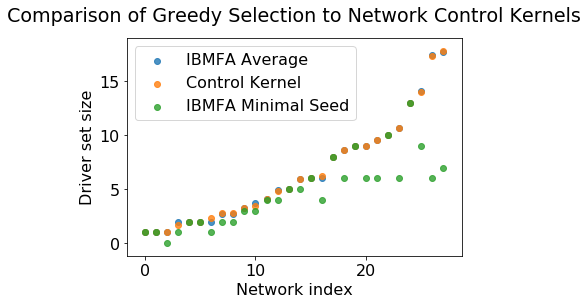

In [68]:
#compare mean control kernel size to our mean driver set size
xvalues=range(len(drivers))
#sort networks for better visualization (based on mean control kernel size)
sorted_networks=sorted(drivers,key=lambda x: drivers[x]['kernel'])
#for n in sorted_networks: print n,control_kernels[n.lower()]['mean control kernel size']
yvalues1=[drivers[n]['greedy'] for n in sorted_networks]
yvalues2=[drivers[n]['kernel'] for n in sorted_networks]
yvalues3=[cell_drivers[n]['size'] for x in sorted_networks for n in cell_drivers if x.lower()==n.lower()]
print len(yvalues1),len(yvalues2)
#print zip(sorted_networks,yvalues3)

plt.scatter(xvalues,yvalues1,label='IBMFA Average',alpha=0.8)
plt.scatter(xvalues,yvalues2,label='Control Kernel',alpha=0.8)
plt.scatter(xvalues,yvalues3,label='IBMFA Minimal Seed',alpha=0.8)
#plt.ylim([0,3.5])
plt.title("Comparison of Greedy Selection to Network Control Kernels", y=1.05)
plt.ylabel("Driver set size")
plt.xlabel("Network index")
plt.legend()

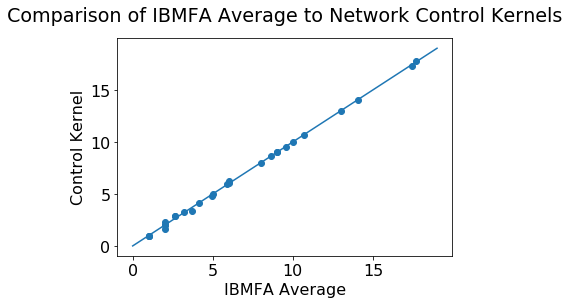

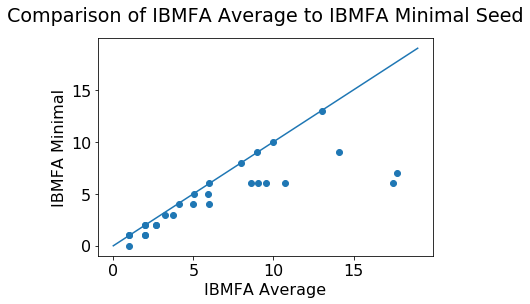

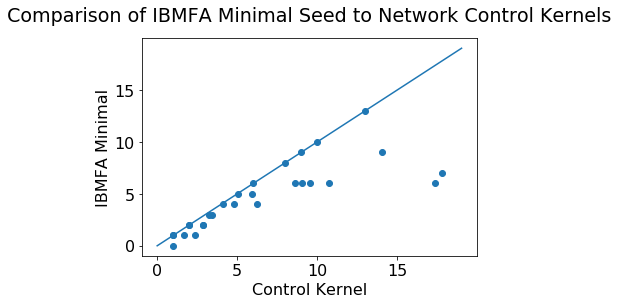

In [77]:
#alternate 1x1 plots
plt.scatter(yvalues1,yvalues2)
plt.plot(xvalues[:20],xvalues[:20]) #x=y line, also acts as an axis limit
plt.xlabel("IBMFA Average")
plt.ylabel("Control Kernel")
plt.title("Comparison of IBMFA Average to Network Control Kernels", y=1.05)
plt.show()

plt.scatter(yvalues1,yvalues3)
plt.plot(xvalues[:20],xvalues[:20]) #x=y line, also acts as an axis limit
plt.xlabel("IBMFA Average")
plt.ylabel("IBMFA Minimal")
plt.title("Comparison of IBMFA Average to IBMFA Minimal Seed", y=1.05)
plt.show()

plt.scatter(yvalues2,yvalues3)
plt.plot(xvalues[:20],xvalues[:20]) #x=y line, also acts as an axis limit
plt.xlabel("Control Kernel")
plt.ylabel("IBMFA Minimal")
plt.title("Comparison of IBMFA Minimal Seed to Network Control Kernels", y=1.05)
plt.show()